In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import copy
import matplotlib.pyplot as plt
import glob
from pathlib import Path
import os
import plotly.express as px
from matplotlib import cm
import matplotlib as mpl
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
import matplotlib as mpl
from matplotlib import cm
import cartopy.crs as ccrs
import cartopy
import random
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from scipy.stats import gaussian_kde
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from sklearn import tree
from sklearn.model_selection import cross_validate
import geopandas as gpd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from pathos.threading import ThreadPool as Pool
from sklearn import datasets, linear_model
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [2]:
work_dir=Path("/mnt/u/LSM root zone/global_sr")
fig_dir=Path('/mnt/c/Users/fransjevanoors/surfdrive - Fransje van Oorschot@surfdrive.surf.nl/Fransje/global_SR/global_sr_paper/figures')

In [3]:
data_sources = 'gswp-p_gleam-ep_gswp-t'

In [4]:
# performance metrics
def rmse(y,y_pred):
    rmse = np.sqrt(mean_squared_error(y,y_pred))
    return rmse

def r2_adj(y,y_pred,features):
    r2 = r2_score(y, y_pred)
    r2_adj = 1-(((1-r2)*(len(y)-1))/(len(y)-len(features)-1))
    return r2_adj

def llf_(y, X, pr):
    # return maximized log likelihood
    nobs = float(X.shape[0])
    nobs2 = nobs / 2.0
    nobs = float(nobs)
    resid = y - pr
    ssr = np.sum((resid)**2)
    llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
    return llf

def aic(y, X, pr, p):
    # return aic metric
    llf = llf_(y, X, pr)
    return -2*llf+2*p

## 0. plot Sr

### make sure we use the correct catchments - final selection

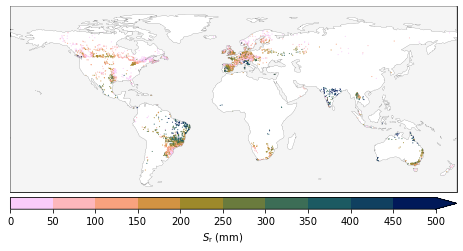

In [19]:
from cmcrameri import cm
f = f'{work_dir}/output/catchment_characteristics/master_characteristics_gswp-p_gleam-ep_gswp-t.csv'
df = pd.read_csv(f,index_col=0)
df = df.drop(columns=['idu_mean_l', 'idu_max_l', 'hpd_mean_l',
       'hpd_max_l', 'hpf_l', 'lpf_l', 'si_pl', 'phi_l', 'de_l', 'dp_l', 'dt_l',
       'sp_l', 'st_l', 'se_l', 'sd_l', 'sti_l', 'asi_l','ppd_l'])
df = df.dropna()
cmap_vd2 = cm.batlow_r

bounds = np.linspace(0,500,11)
bounds2 = np.linspace(0,500,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap_vd2.N)

# no irrigation
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.001)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.12)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(df.lon,df.lat,s=0.8,c=df['sr_20'],cmap=cmap_vd2, norm=norm,edgecolors='face',marker='o',linewidths=0.1)
cbar = plt.colorbar(s, orientation='horizontal', label='',spacing='proportional',extend='max', pad=0.012,aspect=38, norm=norm,ticks=bounds2)
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='$S_\mathrm{r}$ (mm)', size=10)
ax.set_title('',size=14)
fig.savefig(f'{fig_dir}/sr_map_t20.jpg',bbox_inches='tight',dpi=600)

## 1. CORRELATION MATRIX

In [5]:
f = f'{work_dir}/output/catchment_characteristics/master_characteristics_gswp-p_gleam-ep_gswp-t.csv'
df = pd.read_csv(f,index_col=0)
df = df.drop(columns=['stext','start_year','end_year','years','kg','lat','lon'])
df = df.drop(columns=['idu_mean_l', 'idu_max_l', 'hpd_mean_l',
       'hpd_max_l', 'hpf_l', 'lpf_l', 'si_pl', 'phi_l', 'de_l', 'dp_l', 'dt_l',
       'sp_l', 'st_l', 'se_l', 'sd_l', 'sti_l', 'asi_l','ppd_l'])
df = df.drop(columns=['sti','area'])
df = df.drop(columns=['q_mean'])
df = df.dropna()
corr = df.corr()
# corr.style.background_gradient(cmap='coolwarm').set_precision(2)
corr.style.background_gradient(cmap='coolwarm').set_precision(2).to_excel(f'{work_dir}/output/regression/correlation_matrix.xlsx')

/tmp/ipykernel_313/3758498390.py:12: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2).to_excel(f'{work_dir}/output/regression/correlation_matrix.xlsx')


## 2. PCA

In [6]:
f = f'{work_dir}/output/catchment_characteristics/master_characteristics_gswp-p_gleam-ep_gswp-t.csv'
df = pd.read_csv(f,index_col=0)
df = df.drop(columns=['stext','start_year','end_year','years','kg','lat','lon'])
df = df.drop(columns=['idu_mean_l', 'idu_max_l', 'hpd_mean_l',
       'hpd_max_l', 'hpf_l', 'lpf_l', 'si_pl', 'phi_l', 'de_l', 'dp_l', 'dt_l',
       'sp_l', 'st_l', 'se_l', 'sd_l', 'sti_l', 'asi_l','ppd_l'])
df = df.drop(columns=['q_mean'])
df = df.drop(columns=['slp_max','slp_min','slp_std','el_max','el_std','el_min','hand_max','hand_median','hand_min','sti'])
df = df.dropna()
# df.columns

In [7]:
features = df.columns
lf = len(features)
print('length of features:', lf)
X = df[features]
X = X.dropna()
X = StandardScaler().fit_transform(X) #standardize all values
X = pd.DataFrame(X,columns=features)

pca = PCA(n_components=lf)
components = pca.fit_transform(X)

loadings = pca.components_ #eigenvector, length represents variance var explains
 
# Create dataframe
pca_df = pd.DataFrame(data=components[:,0:2],columns=['PC1', 'PC2'])

pca_df_scaled = pca_df.copy()
 
scaler_df = pca_df[['PC1', 'PC2']]
scaler = 1 / (scaler_df.max() - scaler_df.min()) # WAAROM DIT?
 
for index in scaler.index:
    pca_df_scaled[index] *= scaler[index]

per_var  = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
# per_var

length of features: 49


In [8]:
ld_df = pd.DataFrame(index=features, columns=['x-loading','y-loading'])
ld_df['x-loading'] = np.round(loadings[0],2)
ld_df['y-loading'] = np.round(loadings[1],2)
ld_df['length-loading'] = np.round(np.sqrt(loadings[0]**2+loadings[1]**2),2)
# ld_df

In [9]:
ld_sort = abs(ld_df).sort_values('x-loading',ascending=False)
ld_sort = ld_sort[0:25]
ld_sort['rank'] = np.arange(1,len(ld_sort)+1,1)
ld_sort = ld_sort.drop(columns=['length-loading','y-loading'])
ld_sort['var'] = ld_sort.index
ld_sort.index = ld_sort['rank']
ld_sort = ld_sort.drop(columns='rank')
ld_sort = ld_sort[['var','x-loading']]
# ld_sort

In [10]:
ld_sort = abs(ld_df).sort_values('y-loading',ascending=False)
ld_sort = ld_sort[0:25]
ld_sort['rank'] = np.arange(1,len(ld_sort)+1,1)
ld_sort = ld_sort.drop(columns=['length-loading','x-loading'])
ld_sort['var'] = ld_sort.index
ld_sort.index = ld_sort['rank']
ld_sort = ld_sort.drop(columns='rank')
ld_sort = ld_sort[['var','y-loading']]
# ld_sort

In [11]:
ld_sort = abs(ld_df).sort_values('length-loading',ascending=False)
ld_sort = ld_sort[0:25]
ld_sort['rank'] = np.arange(1,len(ld_sort)+1,1)
ld_sort = ld_sort.drop(columns=['x-loading','y-loading'])
ld_sort['var'] = ld_sort.index
ld_sort.index = ld_sort['rank']
ld_sort = ld_sort.drop(columns='rank')
ld_sort = ld_sort[['var','length-loading']]
# ld_sort

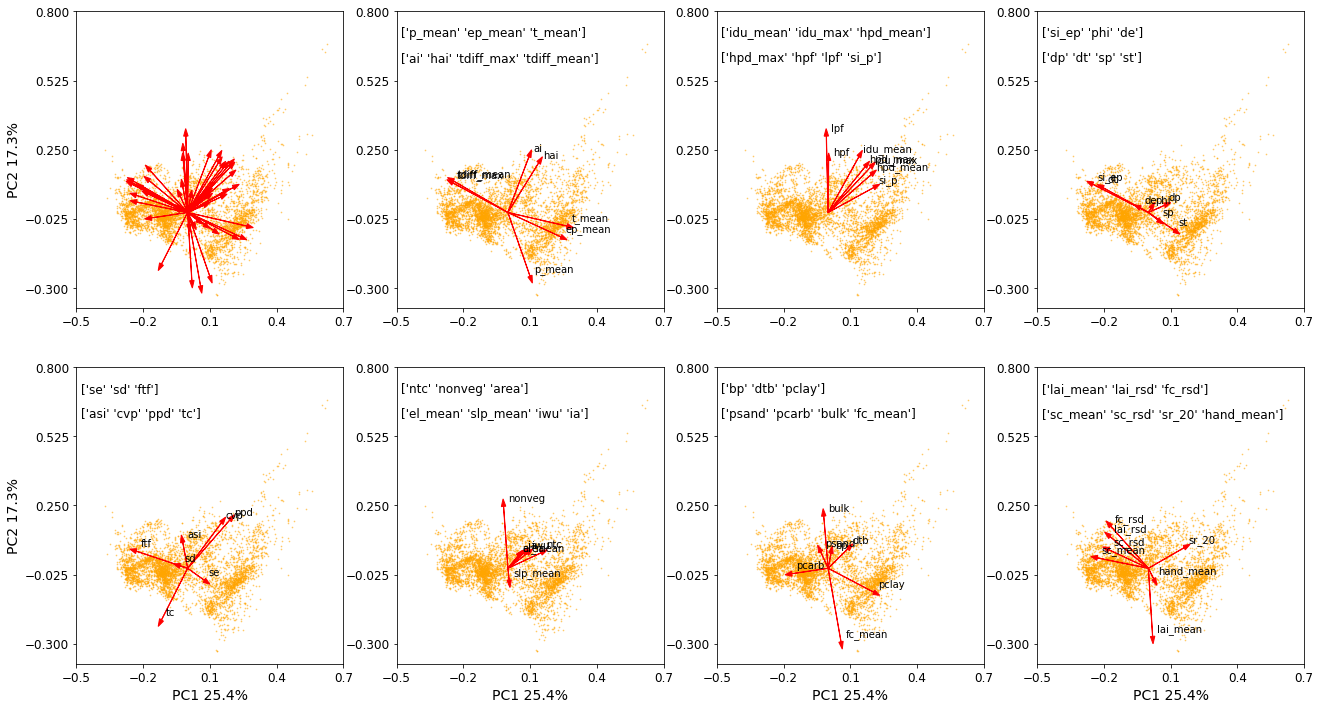

In [12]:
xs = loadings[0]
ys = loadings[1]

ld_df = pd.DataFrame(index=features, columns=['xs','ys'])
ld_df['xs'] = loadings[0]
ld_df['ys'] = loadings[1]
ld_df['len'] = np.sqrt(loadings[0]**2+loadings[1]**2)

# split features for visualization of PCA
p = int(np.round((lf/7),0))
features1=features[0:p]
features2=features[p:2*p]
features3=features[2*p:3*p]
features4=features[3*p:4*p]
features5=features[4*p:5*p]
features6=features[5*p:6*p]
features7=features[6*p:]

fig=plt.figure(figsize=(22,12))
ax = fig.add_subplot(241)
ax.scatter(pca_df_scaled.PC1,pca_df_scaled.PC2,s=0.5,alpha=0.5,color='orange')

for i, varnames in enumerate(features):
    ax.arrow(
        0, 0, # coordinates of arrow base
        ld_df.loc[features[i]]['xs'], # length of the arrow along x
        ld_df.loc[features[i]]['ys'], # length of the arrow along y
        color='r',
        head_width=0.02
        )
    # ax.text(ld_df.loc[features[i]]['xs']+0.02, ld_df.loc[features[i]]['ys']+0.02, varnames,size=10)
xticks = np.linspace(-0.5,0.7, num=5)
yticks = np.linspace(-0.3,0.8, num=5)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.tick_params(axis='both', which='major', labelsize=12)
# ax.set_xlabel(f'PC1 {per_var[0]}%')
ax.set_ylabel(f'PC2 {per_var[1]}%',size=14)

ax = fig.add_subplot(242)
ax.scatter(pca_df_scaled.PC1,pca_df_scaled.PC2,s=0.5,alpha=0.5,color='orange')
for i, varnames in enumerate(features1):
    ax.arrow(
        0, 0, # coordinates of arrow base
        ld_df.loc[features1[i]]['xs'], # length of the arrow along x
        ld_df.loc[features1[i]]['ys'], # length of the arrow along y
        color='r',
        head_width=0.02
        )
    ax.text(ld_df.loc[features1[i]]['xs']+0.02, ld_df.loc[features1[i]]['ys']+0.02, varnames,size=10)
xticks = np.linspace(-0.5,0.7, num=5)
yticks = np.linspace(-0.3,0.8, num=5)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.text(-0.48,0.7,f'{features1[0:int(len(features1)/2)].values}',size=12)
ax.text(-0.48,0.6,f'{features1[int(len(features1)/2):].values}',size=12)

ax = fig.add_subplot(243)
ax.scatter(pca_df_scaled.PC1,pca_df_scaled.PC2,s=0.5,alpha=0.5,color='orange')
for i, varnames in enumerate(features2):
    ax.arrow(
        0, 0, # coordinates of arrow base
        ld_df.loc[features2[i]]['xs'], # length of the arrow along x
        ld_df.loc[features2[i]]['ys'], # length of the arrow along y
        color='r',
        head_width=0.02
        )
    ax.text(ld_df.loc[features2[i]]['xs']+0.02, ld_df.loc[features2[i]]['ys']+0.02, varnames,size=10)
xticks = np.linspace(-0.5,0.7, num=5)
yticks = np.linspace(-0.3,0.8, num=5)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.text(-0.48,0.7,f'{features2[0:int(len(features2)/2)].values}',size=12)
ax.text(-0.48,0.6,f'{features2[int(len(features2)/2):].values}',size=12)

ax = fig.add_subplot(244)
ax.scatter(pca_df_scaled.PC1,pca_df_scaled.PC2,s=0.5,alpha=0.5,color='orange')
for i, varnames in enumerate(features3):
    ax.arrow(
        0, 0, # coordinates of arrow base
        ld_df.loc[features3[i]]['xs'], # length of the arrow along x
        ld_df.loc[features3[i]]['ys'], # length of the arrow along y
        color='r',
        head_width=0.02
        )
    ax.text(ld_df.loc[features3[i]]['xs']+0.02, ld_df.loc[features3[i]]['ys']+0.02, varnames,size=10)
xticks = np.linspace(-0.5,0.7, num=5)
yticks = np.linspace(-0.3,0.8, num=5)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.text(-0.48,0.7,f'{features3[0:int(len(features3)/2)].values}',size=12)
ax.text(-0.48,0.6,f'{features3[int(len(features3)/2):].values}',size=12)

ax = fig.add_subplot(245)
ax.scatter(pca_df_scaled.PC1,pca_df_scaled.PC2,s=0.5,alpha=0.5,color='orange')
for i, varnames in enumerate(features4):
    ax.arrow(
        0, 0, # coordinates of arrow base
        ld_df.loc[features4[i]]['xs'], # length of the arrow along x
        ld_df.loc[features4[i]]['ys'], # length of the arrow along y
        color='r',
        head_width=0.02
        )
    ax.text(ld_df.loc[features4[i]]['xs']+0.02, ld_df.loc[features4[i]]['ys']+0.02, varnames,size=10)
xticks = np.linspace(-0.5,0.7, num=5)
yticks = np.linspace(-0.3,0.8, num=5)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel(f'PC1 {per_var[0]}%',size=14)
ax.set_ylabel(f'PC2 {per_var[1]}%',size=14)
ax.text(-0.48,0.7,f'{features4[0:int(len(features4)/2)].values}',size=12)
ax.text(-0.48,0.6,f'{features4[int(len(features4)/2):].values}',size=12)

ax = fig.add_subplot(246)
ax.scatter(pca_df_scaled.PC1,pca_df_scaled.PC2,s=0.5,alpha=0.5,color='orange')
for i, varnames in enumerate(features5):
    ax.arrow(
        0, 0, # coordinates of arrow base
        ld_df.loc[features5[i]]['xs'], # length of the arrow along x
        ld_df.loc[features5[i]]['ys'], # length of the arrow along y
        color='r',
        head_width=0.02
        )
    ax.text(ld_df.loc[features5[i]]['xs']+0.02, ld_df.loc[features5[i]]['ys']+0.02, varnames,size=10) 
xticks = np.linspace(-0.5,0.7, num=5)
yticks = np.linspace(-0.3,0.8, num=5)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel(f'PC1 {per_var[0]}%',size=14)
ax.text(-0.48,0.7,f'{features5[0:int(len(features5)/2)].values}',size=12)
ax.text(-0.48,0.6,f'{features5[int(len(features5)/2):].values}',size=12)

ax = fig.add_subplot(247)
ax.scatter(pca_df_scaled.PC1,pca_df_scaled.PC2,s=0.5,alpha=0.5,color='orange')
for i, varnames in enumerate(features6):
    ax.arrow(
        0, 0, # coordinates of arrow base
        ld_df.loc[features6[i]]['xs'], # length of the arrow along x
        ld_df.loc[features6[i]]['ys'], # length of the arrow along y
        color='r',
        head_width=0.02
        )
    ax.text(ld_df.loc[features6[i]]['xs']+0.02, ld_df.loc[features6[i]]['ys']+0.02, varnames,size=10)
xticks = np.linspace(-0.5,0.7, num=5)
yticks = np.linspace(-0.3,0.8, num=5)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel(f'PC1 {per_var[0]}%',size=14)
ax.text(-0.48,0.7,f'{features6[0:int(len(features6)/2)].values}',size=12)
ax.text(-0.48,0.6,f'{features6[int(len(features6)/2):].values}',size=12)

ax = fig.add_subplot(248)
ax.scatter(pca_df_scaled.PC1,pca_df_scaled.PC2,s=0.5,alpha=0.5,color='orange')
for i, varnames in enumerate(features7):
    ax.arrow(
        0, 0, # coordinates of arrow base
        ld_df.loc[features7[i]]['xs'], # length of the arrow along x
        ld_df.loc[features7[i]]['ys'], # length of the arrow along y
        color='r',
        head_width=0.02
        )
    ax.text(ld_df.loc[features7[i]]['xs']+0.02, ld_df.loc[features7[i]]['ys']+0.02, varnames,size=10)
xticks = np.linspace(-0.5,0.7, num=5)
yticks = np.linspace(-0.3,0.8, num=5)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel(f'PC1 {per_var[0]}%',size=14)
ax.text(-0.48,0.7,f'{features7[0:int(len(features7)/2)].values}',size=12)
ax.text(-0.48,0.6,f'{features7[int(len(features7)/2):].values}',size=12)
fig.savefig(f'{work_dir}/output/figures/prediction_figures/pca/pca_scatters.jpg',bbox_inches='tight',dpi=300)


## 3. RANDOM FOREST

In [6]:
def rf_regression(df,features,n_estimators,max_features,min_samples_leaf,max_depth,random_state,plot,plot2):
    sr_rp = 'sr_20'
    df['catch_id'] = df.index

    ll = ['lat','lon','catch_id']
    f = features + ll
    dfx = df[f].values
    dfy = df[sr_rp].values

    X_train, X_test, y_train, y_test = train_test_split(dfx, dfy.reshape(-1, 1).ravel(), test_size=0.4, random_state=random_state)

    # add removed data in resampling to testset
    # ptx = pt[f].values
    # pty = pt[sr_rp].values
    # X_test = np.concatenate([X_test,ptx])
    # y_test = np.concatenate([y_test,pty.reshape(-1, 1).ravel()])

    # save lat lon columns
    lat_train = X_train[:,-3]
    lon_train = X_train[:,-2]
    lat_test = X_test[:,-3]
    lon_test = X_test[:,-2]
    catch_id_train = X_train[:,-1]
    catch_id_test = X_test[:,-1]
    # remove lat lon columns
    X_train = np.delete(X_train,-1,1)
    X_train = np.delete(X_train,-1,1)
    X_train = np.delete(X_train,-1,1)
    X_test = np.delete(X_test,-1,1)
    X_test = np.delete(X_test,-1,1)
    X_test = np.delete(X_test,-1,1)

    rf = RandomForestRegressor(criterion='absolute_error',n_estimators=n_estimators, max_features=max_features,min_samples_leaf=min_samples_leaf,max_depth=max_depth)
    rf = rf.fit(X_train, y_train)
    train_y_pred = rf.predict(X_train)
    test_y_pred = rf.predict(X_test)

    df_train = pd.DataFrame(index=catch_id_train,columns=['lat','lon','Sr_m','Sr_p','Sr_p-Sr_m','(Sr_p-Sr_m)/Sr_m'])
    df_train['lat'] = lat_train
    df_train['lon'] = lon_train
    df_train['Sr_m'] = y_train
    df_train['Sr_p'] = train_y_pred
    df_train['Sr_p-Sr_m'] = train_y_pred - y_train
    df_train['(Sr_p-Sr_m)/Sr_m'] = (train_y_pred - y_train)/train_y_pred

    df_test = pd.DataFrame(index=catch_id_test,columns=['lat','lon','Sr_m','Sr_p','Sr_p-Sr_m','(Sr_p-Sr_m)/Sr_m'])
    df_test['lat'] = lat_test
    df_test['lon'] = lon_test
    df_test['Sr_m'] = y_test
    df_test['Sr_p'] = test_y_pred
    df_test['Sr_p-Sr_m'] = test_y_pred - y_test
    df_test['(Sr_p-Sr_m)/Sr_m'] = (test_y_pred - y_test)/test_y_pred

    train_mse = int(mean_squared_error(y_train, train_y_pred))
    train_mae = int(mean_absolute_error(y_train, train_y_pred))
    train_r2 = np.round(r2_score(y_train, train_y_pred),2)
    train_r2_adj =  np.round(r2_adj(y_train, train_y_pred,features),2)
    train_rmse = int(rmse(y_train,train_y_pred))
    train_mape =  np.round(mean_absolute_percentage_error(y_train, train_y_pred),2)

    test_mse = int(mean_squared_error(y_test, test_y_pred))
    test_mae = int(mean_absolute_error(y_test, test_y_pred))
    test_r2 = np.round(r2_score(y_test, test_y_pred),2)
    test_r2_adj = np.round(r2_adj(y_test, test_y_pred,features),2)
    test_rmse = int(rmse(y_test,test_y_pred))
    test_mape = np.round(mean_absolute_percentage_error(y_test, test_y_pred),2)
    
    n_test = len(y_test)
    n_train = len(y_train)

    perm_importance = permutation_importance(rf, X_test, y_test,scoring='neg_mean_absolute_error',random_state=42)
    pi = perm_importance.importances_mean
    dd = pd.DataFrame(index=features,columns=['pi'])
    dd['pi'] = pi
    dd = dd.sort_values(by='pi')    
    sdf = pd.DataFrame(index=[0])
    sdf[features] = np.round(pi,4)
    # sdf[features] = np.round(rf.feature_importances_,2)
    sdf[['train_mse','train_rmse','train_mae','train_r2','train_r2_adj','train_mape']] = [train_mse,train_rmse,train_mae,train_r2,train_r2_adj,train_mape]
    sdf[['test_mse','test_rmse','test_mae','test_r2','test_r2_adj','test_mape']] = [test_mse,test_rmse,test_mae,test_r2,test_r2_adj,test_mape]
    sdf[['n_train','n_test']] = [n_train,n_test]
    
    if (plot==True):
        fig1 = plt.figure(figsize=(17,6))
        ax = fig1.add_subplot(131)
        ax.plot(y_train,train_y_pred,'o',markersize=1)
        ax.plot([0,800],[0,800],'k--')
        ax.set_title(f'Train, r2:{train_r2}, mae={train_mae}mm, n={n_train}')
        ax.set_xlim(-20,800)
        ax.set_ylim(-20,800)
        ax.set_xlabel('Sr memory method (mm)')
        ax.set_ylabel('Sr predicted (mm)')

        ax = fig1.add_subplot(132)
        ax.plot(y_test,test_y_pred,'o',markersize=1)
        ax.plot([0,800],[0,800],'k--')
        ax.set_title(f'Test, r2:{test_r2}, mae={test_mae}mm, n={n_test}')
        ax.set_xlim(-20,800)
        ax.set_ylim(-20,800)
        ax.set_xlabel('Sr memory method (mm)')
        ax.set_ylabel('Sr predicted (mm)')
        
        ax = fig1.add_subplot(133)
        ax.barh(dd.index,dd.pi)
        ax.set_xlabel('permutation feature importance - decrease in R2')
        
        # cmap_vd2 = cm.get_cmap('RdBu', 21)
        # cmap_rdbu = cm.get_cmap('coolwarm_r', 21)
        # cmap_vd2 = cm.get_cmap('RdBu', 21)
        # cmap_rdbu = cm.get_cmap('coolwarm_r', 21)
        cmap_rdbu = cm.get_cmap('RdYlBu', 20)
        cmap_rdbu = ListedColormap([cmap_rdbu(0),cmap_rdbu(1),cmap_rdbu(2),cmap_rdbu(3),cmap_rdbu(4),cmap_rdbu(5),cmap_rdbu(6),cmap_rdbu(7),cmap_rdbu(8),
                                    (144/255,238/255,144/255),(144/255,238/255,144/255),
                                   cmap_rdbu(11),cmap_rdbu(12),cmap_rdbu(13),cmap_rdbu(14),cmap_rdbu(15),cmap_rdbu(16),cmap_rdbu(17),cmap_rdbu(18),cmap_rdbu(19)])
        bounds = np.linspace(-100,100,21)
        bounds2 = np.linspace(-100,100,11)
        norm = mpl.colors.BoundaryNorm(bounds, cmap_rdbu.N)

        train_er = y_train - train_y_pred
        test_er = y_test- test_y_pred
        train_err = (y_train - train_y_pred)/y_train
        test_err = (y_test- test_y_pred)/y_test
        fig2 = plt.figure(figsize=(15,12))
        plt.subplots_adjust(wspace=0000.1,hspace=-0.4)
        ax = fig2.add_subplot(221,projection=ccrs.PlateCarree())
        ax.coastlines(linewidth=0.1)
        ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
        ax.set_global()
        ax.set_xlim(-180,180)
        ax.set_ylim(-60,90)
        s = ax.scatter(lon_train,lat_train,s=1,c=train_er,norm=norm,cmap=cmap_rdbu,edgecolors='face',marker='o',linewidths=0.1)
        cbar = plt.colorbar(s, orientation='horizontal', label='',spacing='proportional',extend='both', pad=0.02,aspect=30, norm=norm,ticks=bounds2)
        ax.set_title('train abs error [sr-mm - sr-pred] (mm)')

        iax = inset_axes(ax, width="22%", height="35%",loc=3)
        iax.hist(train_er,bins=bounds,width=(bounds[0]-bounds[1])*0.85)
        iax.invert_yaxis()
        iax.yaxis.tick_right()
        iax.xaxis.tick_top()

        ax = fig2.add_subplot(222,projection=ccrs.PlateCarree())
        ax.coastlines(linewidth=0.1)
        ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
        ax.set_global()
        ax.set_xlim(-180,180)
        ax.set_ylim(-60,90)
        s = ax.scatter(lon_test,lat_test,s=1,c=test_er,cmap=cmap_rdbu, norm=norm,edgecolors='face',marker='o',linewidths=0.1)
        cbar = plt.colorbar(s, orientation='horizontal', label='',spacing='proportional',extend='both', pad=0.02,aspect=30, norm=norm,ticks=bounds2)
        ax.set_title('test abs error [sr-mm - sr-pred] (mm)')

        iax = inset_axes(ax, width="22%", height="35%",loc=3)
        iax.hist(test_er,bins=bounds,width=(bounds[0]-bounds[1])*0.85)
        iax.invert_yaxis()
        iax.yaxis.tick_right()
        iax.xaxis.tick_top()

        bounds = np.linspace(-1,1,21)
        bounds2 = np.linspace(-1,1,11)
        norm = mpl.colors.BoundaryNorm(bounds, cmap_rdbu.N)

        ax = fig2.add_subplot(223,projection=ccrs.PlateCarree())
        ax.coastlines(linewidth=0.1)
        ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
        ax.set_global()
        ax.set_xlim(-180,180)
        ax.set_ylim(-60,90)
        s = ax.scatter(lon_train,lat_train,s=1,c=train_err,norm=norm,cmap=cmap_rdbu,edgecolors='face',marker='o',linewidths=0.1)
        cbar = plt.colorbar(s, orientation='horizontal', label='',spacing='proportional',extend='both', pad=0.02,aspect=30, norm=norm,ticks=bounds2)
        ax.set_title('train rel error [sr-mm - sr-pred]/sr-mm (-)')

        iax = inset_axes(ax, width="22%", height="35%",loc=3)
        iax.hist(train_err,bins=bounds,width=(bounds[0]-bounds[1])*0.85)
        iax.invert_yaxis()
        iax.yaxis.tick_right()
        iax.xaxis.tick_top()

        ax = fig2.add_subplot(224,projection=ccrs.PlateCarree())
        ax.coastlines(linewidth=0.1)
        ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
        ax.set_global()
        ax.set_xlim(-180,180)
        ax.set_ylim(-60,90)
        s = ax.scatter(lon_test,lat_test,s=1,c=test_err,cmap=cmap_rdbu, norm=norm,edgecolors='face',marker='o',linewidths=0.1)
        cbar = plt.colorbar(s, orientation='horizontal', label='',spacing='proportional',extend='both', pad=0.02,aspect=30, norm=norm,ticks=bounds2)
        ax.set_title('test rel error [sr-mm - sr-pred]/sr-mm (-)')

        iax = inset_axes(ax, width="22%", height="35%",loc=3)
        iax.hist(test_err,bins=bounds,width=(bounds[0]-bounds[1])*0.85)
        iax.invert_yaxis()
        iax.yaxis.tick_right()
        iax.xaxis.tick_top()
  
        if (plot2==True):
            fig3, ax = plt.subplots(2,5, figsize=(16,7),gridspec_kw={'height_ratios': [3, 1]})
            tree_disp = PartialDependenceDisplay.from_estimator(rf, X_train, range(len(features)),feature_names=features,kind='both', ax=ax[0][0:5],
                                                                ice_lines_kw ={'color':'grey'}, line_kw={'color':'orange','linewidth':'3'})
            plt.setp(tree_disp.deciles_vlines_, visible=False)
            ax[0,0].set_ylabel('Sr (mm)')
            ax[0,1].set_ylabel('')
            ax[0,2].set_ylabel('')
            ax[0,3].set_ylabel('')
            ax[0,4].set_ylabel('')
            ax[0,0].set_ylim(0,600)
            ax[0,1].set_ylim(0,600)
            ax[0,2].set_ylim(0,600)
            ax[0,3].set_ylim(0,600)
            ax[0,4].set_ylim(0,600)
            ax[0,0].set_xlim(np.quantile(X_train[:,0],0.05),np.quantile(X_train[:,0],0.95))
            ax[0,1].set_xlim(np.quantile(X_train[:,1],0.05),np.quantile(X_train[:,1],0.95))
            ax[0,2].set_xlim(np.quantile(X_train[:,2],0.05),np.quantile(X_train[:,2],0.95))
            ax[0,3].set_xlim(np.quantile(X_train[:,3],0.05),np.quantile(X_train[:,3],0.95))
            ax[0,4].set_xlim(np.quantile(X_train[:,4],0.05),np.quantile(X_train[:,4],0.95))
            fig3.suptitle('Train',y=0.92,fontsize=16)

            for i in range(len(features)):
                bins = np.linspace(np.quantile(X_train[:,i],0.05),np.quantile(X_train[:,i],0.95),20)
                ax[1,i].hist(X_train[:,i],bins=bins)
                ax[1,i].invert_yaxis()
                ax[1,i].xaxis.tick_top()
                ax[1,i].set_xlim(np.quantile(X_train[:,i],0.05),np.quantile(X_train[:,i],0.95))
                ax[1,i].axes.get_xaxis().set_ticklabels([])
            ax[1,0].set_ylabel('#catchments')
            
            fig4, ax = plt.subplots(2,5, figsize=(16,7),gridspec_kw={'height_ratios': [3, 1]})
            tree_disp = PartialDependenceDisplay.from_estimator(rf, X_test, range(len(features)),feature_names=features,kind='both', ax=ax[0][0:5],
                                                                ice_lines_kw ={'color':'grey'}, line_kw={'color':'orange','linewidth':'3'})
            plt.setp(tree_disp.deciles_vlines_, visible=False)
            ax[0,0].set_ylabel('Sr (mm)')
            ax[0,1].set_ylabel('')
            ax[0,2].set_ylabel('')
            ax[0,3].set_ylabel('')
            ax[0,4].set_ylabel('')
            ax[0,0].set_ylim(0,600)
            ax[0,1].set_ylim(0,600)
            ax[0,2].set_ylim(0,600)
            ax[0,3].set_ylim(0,600)
            ax[0,4].set_ylim(0,600)
            ax[0,0].set_xlim(np.quantile(X_test[:,0],0.05),np.quantile(X_test[:,0],0.95))
            ax[0,1].set_xlim(np.quantile(X_test[:,1],0.05),np.quantile(X_test[:,1],0.95))
            ax[0,2].set_xlim(np.quantile(X_test[:,2],0.05),np.quantile(X_test[:,2],0.95))
            ax[0,3].set_xlim(np.quantile(X_test[:,3],0.05),np.quantile(X_test[:,3],0.95))
            ax[0,4].set_xlim(np.quantile(X_test[:,4],0.05),np.quantile(X_test[:,4],0.95))
            fig4.suptitle('Test',y=0.92,fontsize=16)

            for i in range(len(features)):
                bins = np.linspace(np.quantile(X_test[:,i],0.05),np.quantile(X_test[:,i],0.95),20)
                ax[1,i].hist(X_test[:,i],bins=bins)
                ax[1,i].invert_yaxis()
                ax[1,i].xaxis.tick_top()
                ax[1,i].set_xlim(np.quantile(X_test[:,i],0.05),np.quantile(X_test[:,i],0.95))
                ax[1,i].axes.get_xaxis().set_ticklabels([])
            ax[1,0].set_ylabel('#catchments')
            
            return sdf,df_train,df_test,fig1,fig2,fig3,fig4
        else:
            return sdf,df_train,df_test,fig1,fig2
    else:
        return sdf,df_train,df_test

### Hyperparameter tuning

## sequential feature selection

In [ ]:
min_samples_leaf=1
max_depth=16
n_estimators=100
max_features=0.5
random_states=[12,22,32,38,41]
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}.csv',index_col=0)
df = df.drop(columns=['ppd_l'])
df = df.dropna()
df = df[df.p_mean-df.q_mean < df.ep_mean]
features = ['p_mean','ep_mean', 't_mean','tdiff_mean','idu_mean', 'lpf','si_ep','si_p', 'asi','dtb','ia','slp_mean','el_mean','tc','ntc','nonveg','pclay','psand','lai_mean','lai_rsd','sc_mean','sc_rsd']
sr_rp = 'sr_20'
f = features 
dfx = df[f].values
dfy = df[sr_rp].values

X, X_test, y, y_test = train_test_split(dfx, dfy.reshape(-1, 1).ravel(), test_size=0.4,random_state=21)
estimator=RandomForestRegressor(criterion='absolute_error',random_state=42)
sfs = SequentialFeatureSelector(estimator, n_features_to_select=4,direction="forward")
sfs.fit(X, y)

In [ ]:
sfs.get_support()

In [ ]:
sfs.transform(X).shape

In [ ]:
df = pd.DataFrame(index=f,columns=['rank'])
df['rank'] = sfs.ranking_
df.sort_values('rank')

## manual feature elimination using permutation feature importance

In [7]:
# ALL CATCHMENTS ALL VARIABLES
min_samples_leaf=1
max_depth=None
n_estimators=100
max_features=1
random_states=[12,22,32,38,41,13,23,33,39,42]
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}.csv',index_col=0)
df = df.drop(columns=['ppd_l'])
df = df.dropna()
df = df[df.p_mean-df.q_mean < df.ep_mean]
pp = []
for k in range(len(random_states)):
    random_state = random_states[k]
    features = ['p_mean','ep_mean', 't_mean','tdiff_mean','idu_mean','lpf','si_ep','si_p', 'asi','dtb','ia','slp_mean','el_mean','tc','ntc','nonveg','pclay','psand','lai_mean','lai_rsd','sc_mean','sc_rsd']
    ll = []
    for i in range(len(features)):
        sdf = rf_regression(df,features,n_estimators,max_features,min_samples_leaf,max_depth,random_state,plot=False,plot2=False)[0]
        sdff = sdf[features]
        minx = sdff.values.argmin()
        dr = features[minx]
        ll.append(dr)
        features.remove(dr)
        # print(len(features))
    ll.reverse()
    # d  = pd.DataFrame(index=range(len(ll)),columns=['rank','features'])
    # d.loc[:,'features'] = ll
    # d.loc[:,'rank'] = np.arange(0,22,1)
    d  = pd.DataFrame(index=ll,columns=['rank'])
    d.loc[:,'rank'] = np.arange(0,len(ll),1)
    pp.append(d)

In [8]:
d = pd.concat(pp,axis=1)
dm = pd.DataFrame(d.mean(axis=1))
dm = dm.sort_values(by=0)
dm

0
idu_mean     0.1
sc_mean      1.2
t_mean       1.9
p_mean       3.1
lpf          4.2
si_p         5.0
tdiff_mean   6.2
ep_mean      7.8
slp_mean     8.6
asi          8.7
pclay        9.8
si_ep       10.1
ntc         12.3
dtb         13.3
lai_rsd     14.4
lai_mean    16.4
tc          16.6
el_mean     17.0
sc_rsd      17.3
nonveg      17.5
psand       18.7
ia          20.8

### spatial resampling

3194


Text(0.5, 0, 'Sr (mm)')

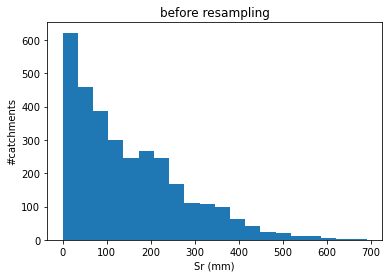

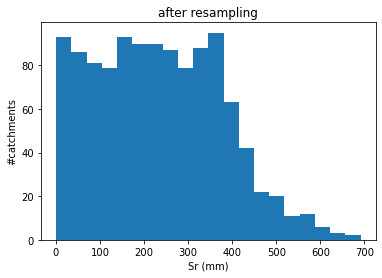

In [23]:
# sample equally for each sr bin
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}.csv',index_col=0)
df = df.drop(columns=['ppd_l'])
df = df.dropna()
df = df[df.p_mean-df.q_mean < df.ep_mean]
print(len(df))
dfs = df.sort_values(by='sr_20')
gr = np.arange(0,950,50)
gr = [  0,  50, 100, 150, 200, 250, 300, 350, 400]#, 900]
gr2 = [  0,  50, 100, 150, 200, 250, 300, 350, 400]#, 900]
l=[]
p=[]
for i in range(len(gr)-1):
    s = dfs[(dfs.sr_20>gr[i])&(dfs.sr_20<gr[i+1])]
    # print(len(s))
    ix = random.sample(np.arange(0,len(s)).tolist(),125)
    p.append(s.iloc[ix])
    l.append(len(s))
#sr larger than 400: use all
s = dfs[(dfs.sr_20>400)]
p.append(s)
pp = pd.concat(p)

plt.figure()
plt.hist(dfs.sr_20,bins=20)
plt.title('before resampling')
plt.ylabel('#catchments')
plt.xlabel('Sr (mm)')

plt.figure()
plt.hist(pp.sr_20,bins=20)
plt.title('after resampling')
plt.ylabel('#catchments')
plt.xlabel('Sr (mm)')

## Crossvalidation model to test robustness

### no hyperparameter tuning: with tuning similar performance

In [9]:
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}.csv',index_col=0)
df = df.drop(columns=['ppd_l'])
df = df[df.p_mean-df.q_mean < df.ep_mean]
df = df.dropna()
# features = ['t_mean','p_mean','idu_mean','asi']
features = ['p_mean','ep_mean', 't_mean','tdiff_mean','idu_mean', 'lpf','si_ep','si_p', 'asi','dtb','ia','slp_mean','el_mean','tc','ntc','nonveg','pclay','psand','lai_mean','lai_rsd','sc_mean','sc_rsd']
sr_rp = 'sr_20'
f = features 
dfx = df[f].values
dfy = df[sr_rp].values

# here split dataset into 'temp' and 'test'
cv_outer = 4 # the number of outer cross validations
sdf = pd.DataFrame(index=range(cv_outer), columns=['n_estimators','max_depth','min_samples_leaf','max_features','train_mae','train_r2_adj','test_mae','test_r2_adj','n_train','n_test','fold'])
l = []

kf = KFold(n_splits=cv_outer,shuffle=True,random_state=0)
df = dfy.reshape(-1, 1).ravel()
i=0
cv_train_ix = []
cv_test_ix = []
for train_ix, test_ix in kf.split(dfx):
    cv_train_ix.append(train_ix)
    cv_test_ix.append(test_ix)
    X = dfx[train_ix]
    y = dfy[train_ix]
    X_test = dfx[test_ix]
    y_test = dfy[test_ix]

    # run rf model with full 'temp' set and test set using the best inner cross validation
    rf = RandomForestRegressor(criterion='absolute_error',random_state=42)
    rf.fit(X,y)
    test_y_pred = rf.predict(X_test)
    train_y_pred = rf.predict(X)
    n_train,n_test = len(y),len(y_test)

    train_mae = np.round(mean_absolute_error(y, train_y_pred),2)
    train_r2_adj =  np.round(r2_adj(y, train_y_pred,features),2)

    test_mae = np.round(mean_absolute_error(y_test, test_y_pred),2)
    test_r2_adj = np.round(r2_adj(y_test, test_y_pred,features),2)

    # save scores in dataframe
    # sdf.loc[i][['n_estimators','max_depth','min_samples_leaf','max_features']] = [n_estimators,max_depth,min_samples_leaf,max_features]
    sdf.loc[i]['fold'] = i
    sdf.loc[i][['train_mae','train_r2_adj']] = [train_mae,train_r2_adj]
    sdf.loc[i][['test_mae','test_r2_adj']] = [test_mae,test_r2_adj]
    sdf.loc[i][['n_train','n_test']] = [n_train,n_test]
    print(i)

    i+=1

# sdf.to_csv(f'{work_dir}/cross_validation/output/sdf_kinner{cv_inner}_kouter{cv_outer}_var{len(features)}_v2.csv')

0
1
2
3


In [10]:
sdf

n_estimators max_depth min_samples_leaf max_features train_mae train_r2_adj  \
0          NaN       NaN              NaN          NaN     13.97         0.97   
1          NaN       NaN              NaN          NaN     14.04         0.97   
2          NaN       NaN              NaN          NaN     14.01         0.97   
3          NaN       NaN              NaN          NaN     14.31         0.97   

  test_mae test_r2_adj n_train n_test fold  
0    36.34        0.82    2395    799    0  
1     37.6         0.8    2395    799    1  
2    37.22         0.8    2396    798    2  
3    37.31         0.8    2396    798    3

## Manual feature elimination with cross validation

In [ ]:
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}.csv',index_col=0)
df = df.drop(columns=['ppd_l'])
df = df[df.p_mean-df.q_mean < df.ep_mean]
df = df.dropna()
# features = ['t_mean','p_mean','idu_mean','asi']
features = ['p_mean','ep_mean', 't_mean','tdiff_mean','idu_mean', 'lpf','si_ep','si_p', 'asi','dtb','ia','slp_mean','el_mean','tc','ntc','nonveg','pclay','psand','lai_mean','lai_rsd','sc_mean','sc_rsd']
sr_rp = 'sr_20'
f = features 
dfx = df[f].values
dfy = df[sr_rp].values
cv_outer = 4 # the number of outer cross validations
l = []
pp = []
kf = KFold(n_splits=cv_outer,shuffle=True,random_state=0)
i=0
for train_ix, test_ix in kf.split(dfx):
    features = ['p_mean','ep_mean', 't_mean','tdiff_mean','idu_mean','lpf','si_ep','si_p', 'asi','dtb','ia','slp_mean','el_mean','tc','ntc','nonveg','pclay','psand','lai_mean','lai_rsd','sc_mean','sc_rsd']
    f = features
    ll = []
    for i in range(len(f)):
        dfx = df[features].values
        dfy = df[sr_rp].values
        X = dfx[train_ix]
        y = dfy[train_ix]
        X_test = dfx[test_ix]
        y_test = dfy[test_ix]
        
        rf = RandomForestRegressor(criterion='absolute_error',random_state=42)
        rf.fit(X,y)
        test_y_pred = rf.predict(X_test)
        train_y_pred = rf.predict(X)
        n_train,n_test = len(y),len(y_test)

        train_mae = np.round(mean_absolute_error(y, train_y_pred),2)
        train_r2_adj =  np.round(r2_adj(y, train_y_pred,features),2)

        test_mae = np.round(mean_absolute_error(y_test, test_y_pred),2)
        test_r2_adj = np.round(r2_adj(y_test, test_y_pred,features),2)
        
        perm_importance = permutation_importance(rf, X_test, y_test,scoring='neg_mean_absolute_error',random_state=42)
        pi = perm_importance.importances_mean
        dd = pd.DataFrame(index=features,columns=['pi'])
        dd['pi'] = pi
        dd = dd.sort_values(by='pi')    
        sdf = pd.DataFrame(index=[0])
        sdf[features] = np.round(pi,4)
    
        sdff = sdf[features]
        minx = sdff.values.argmin()
        dr = features[minx]
        ll.append(dr)
        features.remove(dr)   
    
    ll.reverse()
    d  = pd.DataFrame(index=ll,columns=['rank'])
    d.loc[:,'rank'] = np.arange(0,len(ll),1)
    pp.append(d)    


In [41]:
d = pd.concat(pp,axis=1)
dm = pd.DataFrame(d.mean(axis=1))
ds = d.std(axis=1)
dm = dm.sort_values(by=0)
dm['mean'] = dm[0]
dm['std'] = ds
dm = dm.drop(columns=0)
dm

mean       std
idu_mean     0.00  0.000000
t_mean       1.00  0.000000
tdiff_mean   2.50  1.000000
p_mean       3.25  0.957427
lpf          3.50  1.000000
sc_mean      4.75  0.500000
asi          6.25  0.500000
ep_mean      7.00  0.816497
slp_mean     8.00  0.816497
pclay        9.50  0.577350
si_p         9.75  1.707825
lai_rsd     12.00  0.816497
lai_mean    13.50  1.914854
ntc         13.75  3.862210
dtb         14.00  2.581989
si_ep       14.25  2.362908
nonveg      15.50  1.290994
el_mean     16.50  2.081666
sc_rsd      17.75  0.500000
tc          18.75  3.862210
psand       19.00  0.816497
ia          20.50  0.577350

## RF interpretation

In [11]:
min_samples_leaf=1
max_depth=None
n_estimators=100
max_features=1
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}.csv',index_col=0)
df = df.drop(columns=['ppd_l'])
df = df[df.p_mean-df.q_mean < df.ep_mean]
df = df.dropna()
# features = ['t_mean','p_mean','idu_mean','asi','slp_mean']
# features = ['t_mean','p_mean','idu_mean','asi']
# features = ['tdiff_mean','lpf','idu_mean','t_mean']
features = ['p_mean','ep_mean', 't_mean','tdiff_mean','idu_mean', 'lpf','si_ep','si_p', 'asi','dtb','ia','slp_mean','el_mean','tc','ntc','nonveg','pclay','psand','lai_mean','lai_rsd','sc_mean','sc_rsd']

In [12]:
df

p_mean   ep_mean    q_mean     t_mean        ai       hai  \
ca_0002351  1.590253  1.401269  0.455940   0.643260  0.881161  0.419085   
cz_0000019  2.285853  1.484881  0.972639   7.528472  0.649596  0.593821   
br_0001191  4.152597  3.260944  1.209388  24.602384  0.785278  0.956434   
br_0000469  4.944120  3.258352  1.958321  26.827793  0.659036  0.875518   
bw_0000006  1.358820  2.669859  0.077338  20.623299  1.964836  2.449571   
...              ...       ...       ...        ...       ...       ...   
in_0000089  3.441414  2.745652  0.979561  25.608996  0.797827  1.172824   
br_0000128  5.936997  4.090981  2.370459  27.015993  0.689066  0.734160   
ca_0000419  2.655707  1.932424  1.425366   4.734362  0.727650  0.457049   
in_0000016  2.526809  2.758476  0.915937  26.032707  1.091684  1.628218   
es_0000295  3.104931  1.965884  1.158912  10.646137  0.633149  0.555933   

            tdiff_max  tdiff_mean  idu_mean  idu_max  ...  lai_mean   lai_rsd  \
ca_0002351  32.852726   25.221876      5.05    22.43  ...  0.950806  0.641162   
cz_0000019  28.280451   22.165638      3.81    20.90  ...  1.885474  0.753561   
br_0001191   5.747533    4.562576      2.67    12.20  ...  2.808409  0.113255   
br_0000469   3.563315    2.495693      6.62    43.07  ...  1.862262  0.252759   
bw_0000006  12.241637   10.890681     12.46   131.85  ...  0.581395  0.657466   
...               ...         ...       ...      ...  ...       ...       ...   
in_0000089  17.002852   14.829664     16.92    68.04  ...  0.903943  0.637682   
br_0000128   3.681301    2.138738      4.50    23.93  ...  5.570754  0.016118   
ca_0000419  34.849674   31.055583      3.20    15.85  ...  2.142158  0.828244   
in_0000016  16.066249   14.215958     22.23   122.46  ...  0.678283  0.707684   
es_0000295  18.534686   16.186555      4.04    23.55  ...  1.257364  0.524027   

              fc_rsd    sc_mean    sc_rsd       sr_20     hand_max  \
ca_0002351  0.572026  41.416667  0.833385   86.685585  1501.171875   
cz_0000019  0.597933  25.416667  1.311083   51.682482   939.671875   
br_0001191  0.052783   0.000000  0.000000  173.824040   522.171875   
br_0000469  0.175812   0.000000  0.000000  333.062414   217.156250   
bw_0000006  0.548385   0.000000  0.000000  221.777925  1271.609375   
...              ...        ...       ...         ...          ...   
in_0000089  0.562167   0.000000  0.000000  579.886473   720.734375   
br_0000128  0.008920   0.000000  0.000000  417.746791   243.781250   
ca_0000419  0.602794  35.750000  1.228926   72.704485    94.609375   
in_0000016  0.660581   0.000000  0.000000  373.351268   388.796875   
es_0000295  0.421732  12.333333  1.258638  189.217162  1795.546875   

             hand_mean  hand_median  hand_min  
ca_0002351  161.245301    76.216726  1.984375  
cz_0000019  120.060104    85.911332  1.015625  
br_0001191   60.038479    41.895014  5.281250  
br_0000469   30.572604    24.476506  1.171875  
bw_0000006   24.544601    19.774955  2.156250  
...                ...          ...       ...  
in_0000089   33.167393    22.004360  0.000000  
br_0000128   23.816584    21.490157  2.140625  
ca_0000419   28.260328    25.263614  0.000000  
in_0000016   25.614706    20.983718  1.359375  
es_0000295  172.522666   108.005634  0.000000  

[3194 rows x 84 columns]

In [13]:
sr_rp = 'sr_20'
df['catch_id'] = df.index
ll = ['lat','lon','catch_id']
f = features + ll
dfx = df[f].values
dfy = df[sr_rp].values

train_ix = cv_train_ix[0]
test_ix = cv_test_ix[0]

# X_train, X_test, y_train, y_test = train_test_split(dfx, dfy.reshape(-1, 1).ravel(), test_size=0.3, random_state=42)
X_train = dfx[train_ix]
y_train = dfy[train_ix]
X_test = dfx[test_ix]
y_test = dfy[test_ix]

# save lat lon columns
lat_train = X_train[:,-3]
lon_train = X_train[:,-2]
lat_test = X_test[:,-3]
lon_test = X_test[:,-2]
catch_id_train = X_train[:,-1]
catch_id_test = X_test[:,-1]
# remove lat lon columns
X_train = np.delete(X_train,-1,1)
X_train = np.delete(X_train,-1,1)
X_train = np.delete(X_train,-1,1)
X_test = np.delete(X_test,-1,1)
X_test = np.delete(X_test,-1,1)
X_test = np.delete(X_test,-1,1)

rf = RandomForestRegressor(criterion='absolute_error',random_state=42)
# rf = RandomForestRegressor(criterion='squared_error',random_state=42,min_samples_leaf=min_samples_leaf,max_depth=max_depth,oob_score=True)
rf = rf.fit(X_train, y_train)
train_y_pred = rf.predict(X_train)
test_y_pred = rf.predict(X_test)

df_train = pd.DataFrame(index=catch_id_train,columns=['lat','lon','Sr_m','Sr_p','Sr_p-Sr_m','(Sr_p-Sr_m)/Sr_m'])
df_train['lat'] = lat_train
df_train['lon'] = lon_train
df_train['Sr_m'] = y_train
df_train['Sr_p'] = train_y_pred
df_train['Sr_p-Sr_m'] = train_y_pred - y_train
df_train['(Sr_p-Sr_m)/Sr_m'] = (train_y_pred - y_train)/train_y_pred

df_test = pd.DataFrame(index=catch_id_test,columns=['lat','lon','Sr_m','Sr_p','Sr_p-Sr_m','(Sr_p-Sr_m)/Sr_m'])
df_test['lat'] = lat_test
df_test['lon'] = lon_test
df_test['Sr_m'] = y_test
df_test['Sr_p'] = test_y_pred
df_test['Sr_p-Sr_m'] = test_y_pred - y_test
df_test['(Sr_p-Sr_m)/Sr_m'] = (test_y_pred - y_test)/test_y_pred

train_mse = int(mean_squared_error(y_train, train_y_pred))
train_mae = int(np.round(mean_absolute_error(y_train, train_y_pred),0))
train_r2 = np.round(r2_score(y_train, train_y_pred),2)
train_r2_adj =  np.round(r2_adj(y_train, train_y_pred,features),2)
train_rmse = int(rmse(y_train,train_y_pred))
train_mape =  np.round(mean_absolute_percentage_error(y_train, train_y_pred),2)

test_mse = int(mean_squared_error(y_test, test_y_pred))
test_mae = int(np.round(mean_absolute_error(y_test, test_y_pred),0))
test_r2 = np.round(r2_score(y_test, test_y_pred),2)
test_r2_adj = np.round(r2_adj(y_test, test_y_pred,features),2)
test_rmse = int(rmse(y_test,test_y_pred))
test_mape = np.round(mean_absolute_percentage_error(y_test, test_y_pred),2)

n_test = len(y_test)
n_train = len(y_train)

perm_importance = permutation_importance(rf, X_test, y_test,scoring='neg_mean_absolute_error',n_repeats=10,random_state=42)
pi = perm_importance.importances_mean
dd = pd.DataFrame(index=features,columns=['pi_mean','pi_std'])
dd['pi_mean'] = pi
dd['pi_std'] = perm_importance.importances_std
dd = dd.sort_values(by='pi_mean') 

perm_importance = permutation_importance(rf, X_train, y_train,scoring='neg_mean_absolute_error',n_repeats=10,random_state=42)
pi = perm_importance.importances_mean
ddtr = pd.DataFrame(index=features,columns=['pi_mean','pi_std'])
ddtr['pi_mean'] = pi
ddtr['pi_std'] = perm_importance.importances_std
ddtr = ddtr.sort_values(by='pi_mean')    

sdf = pd.DataFrame(index=[0])
sdf[features] = np.round(pi,4)
# sdf[features] = np.round(rf.feature_importances_,2)
sdf[['train_mse','train_rmse','train_mae','train_r2','train_r2_adj','train_mape']] = [train_mse,train_rmse,train_mae,train_r2,train_r2_adj,train_mape]
sdf[['test_mse','test_rmse','test_mae','test_r2','test_r2_adj','test_mape']] = [test_mse,test_rmse,test_mae,test_r2,test_r2_adj,test_mape]
sdf[['n_train','n_test']] = [n_train,n_test]


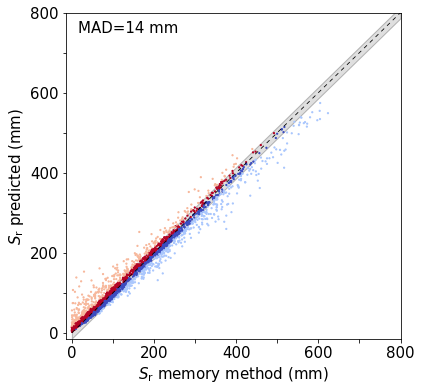

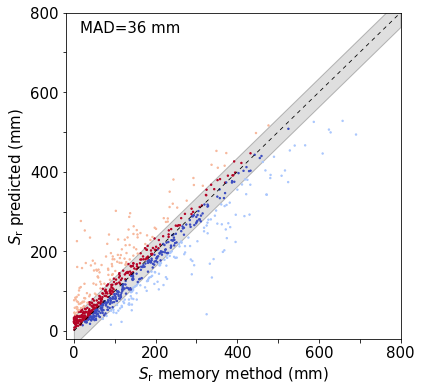

In [41]:
# scatter plots
x = np.linspace(0,800,100)
y = x
cmap_rdbu = cm.get_cmap('coolwarm_r', 4)
cmap_rdbu = ListedColormap([cmap_rdbu(1),cmap_rdbu(0),cmap_rdbu(3),cmap_rdbu(2)])
bounds = np.linspace(0, 4, 5)
bounds2 = bounds
norm = mpl.colors.BoundaryNorm(bounds, cmap_rdbu.N)

# color catchments in scatter plot based on error and use same colors on a map
df_train['group'] = np.nan
ix2 = df_train[(df_train['Sr_p-Sr_m']<train_mae)&(df_train['Sr_p-Sr_m']>0)].index
ix1 = df_train[(df_train['Sr_p-Sr_m']>train_mae)].index
ix3 = df_train[(df_train['Sr_p-Sr_m']>-train_mae)&(df_train['Sr_p-Sr_m']<0)].index
ix4 = df_train[(df_train['Sr_p-Sr_m']<-train_mae)].index
df_train.loc[ix1,'group'] = 0
df_train.loc[ix2,'group'] = 1
df_train.loc[ix3,'group'] = 2
df_train.loc[ix4,'group'] = 3

df_test['group'] = np.nan
ix2 = df_test[(df_test['Sr_p-Sr_m']<test_mae)&(df_test['Sr_p-Sr_m']>0)].index
ix1 = df_test[(df_test['Sr_p-Sr_m']>test_mae)].index
ix3 = df_test[(df_test['Sr_p-Sr_m']>-test_mae)&(df_test['Sr_p-Sr_m']<0)].index
ix4 = df_test[(df_test['Sr_p-Sr_m']<-test_mae)].index
df_test.loc[ix1,'group'] = 0
df_test.loc[ix2,'group'] = 1
df_test.loc[ix3,'group'] = 2
df_test.loc[ix4,'group'] = 3

fig1 = plt.figure(figsize=(6,6))
ax = fig1.add_subplot(111)
plt.subplots_adjust(wspace=0.15)
s=ax.scatter(df_train.Sr_m,df_train.Sr_p,c=df_train.group,s=1.5,cmap=cmap_rdbu,norm=norm,zorder=10)
# ax.plot(y_train,train_y_pred,'o',color='tab:blue',markersize=0.8)
ax.plot(x,y,color='k',linestyle=(0, (5, 5)),linewidth=0.8,zorder=11)
plt.fill_between(x, y-train_mae, y+train_mae, alpha=0.25, edgecolor='k', facecolor='grey')
# ax.set_title(f'Train, MAD={train_mae} mm, $n$={n_train}',size=15)
ax.text(15,750,f'MAD={train_mae} mm',fontsize=15)
ax.set_xlim(-15,800)
ax.set_ylim(-15,800)
ax.set_yticks([0,100,200,300,400,500,600,700,800])
ax.set_xticks([0,100,200,300,400,500,600,700,800])
ax.set_yticklabels([0,'',200,'',400,'',600,'',800])
ax.set_xticklabels([0,'',200,'',400,'',600,'',800])
ax.set_xlabel('$S_\mathrm{r}$ memory method (mm)',size=15)
ax.set_ylabel('$S_\mathrm{r}$ predicted (mm)',size=15)
ax.tick_params(axis='both', labelsize=15)
fig1.savefig(f'{work_dir}/output/regression/figures/interpretation/scatter_train.jpg',bbox_inches='tight',dpi=300)


fig1 = plt.figure(figsize=(6,6))
ax = fig1.add_subplot(111)
# ax.plot(y_test,test_y_pred,'o',color='tab:orange',markersize=1)
s=ax.scatter(df_test.Sr_m,df_test.Sr_p,c=df_test.group,s=2,cmap=cmap_rdbu,norm=norm,zorder=10)
ax.plot(x,y,color='k',linestyle=(0, (5, 5)),linewidth=0.8,zorder=11)
plt.fill_between(x, y-test_mae, y+test_mae, alpha=0.25, edgecolor='k', facecolor='grey')
# ax.set_title(f'Test, MAD={test_mae} mm, $n$={n_test}',size=15)
ax.text(15,750,f'MAD={test_mae} mm',fontsize=15)
ax.set_xlim(-20,800)
ax.set_ylim(-20,800)
ax.set_yticks([0,100,200,300,400,500,600,700,800])
ax.set_xticks([0,100,200,300,400,500,600,700,800])
ax.set_yticklabels([0,'',200,'',400,'',600,'',800])
ax.set_xticklabels([0,'',200,'',400,'',600,'',800])
ax.set_xlabel('$S_\mathrm{r}$ memory method (mm)',size=15)
ax.set_ylabel('$S_\mathrm{r}$ predicted (mm)',size=15)
ax.tick_params(axis='both', labelsize=15)
fig1.savefig(f'{work_dir}/output/regression/figures/interpretation/scatter_test.jpg',bbox_inches='tight',dpi=300)

# # feature importances
# fig1 = plt.figure(figsize=(13,6))
# ax = fig1.add_subplot(121)
# ax.barh(ddtr.index,ddtr.pi_mean)
# ax.errorbar(ddtr.pi_mean,ddtr.index, xerr=ddtr.pi_std, fmt=".", color="r")
# ax.set_title('Train permutation feature importance',size=14)
# ax.set_xlabel('decrease in MAD (mm)',size=14)
# ax.tick_params(axis='both', labelsize=13)

# ax = fig1.add_subplot(122)
# ax.barh(dd.index,dd.pi_mean)
# ax.errorbar(dd.pi_mean,dd.index, xerr=dd.pi_std,  fmt=".", color="r")
# ax.set_title('Test permutation feature importance',size=14)
# ax.set_xlabel('decrease in MAD (mm)',size=14)
# ax.tick_params(axis='both', labelsize=13)
# fig1.savefig(f'{work_dir}/output/regression/figures/interpretation/rf_regression_feature_importance.jpg',bbox_inches='tight',dpi=300)



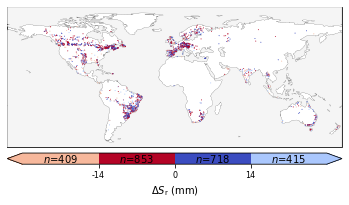

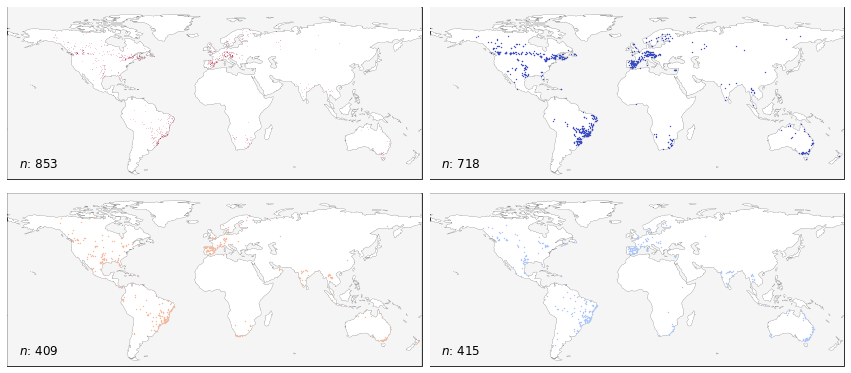

In [23]:
# maps
# cmap_vd2 = cm.get_cmap('RdBu', 21)
# cmap_rdbu = cm.get_cmap('coolwarm_r', 4)
cmap=cmap_rdbu
bounds = np.linspace(0, 4, 5)
bounds2 = bounds
norm = mpl.colors.BoundaryNorm(bounds, cmap_rdbu.N)

# TRAIN
fig2 = plt.figure(figsize=(6,6))
# plt.subplots_adjust(wspace=0000.1,hspace=-0.4)
ax = fig2.add_subplot(111,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s=ax.scatter(lon_train,lat_train,s=0.7,c=df_train.group,edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_rdbu,norm=norm,zorder=101)
cbar = plt.colorbar(s, orientation='horizontal',spacing='proportional',extend='both', pad=0.02,aspect=30, norm=norm)
cbar.set_label('$\Delta$$S_\mathrm{r}$ (mm)')
cbar.set_ticks([1,2,3])
cbar.set_ticklabels([f'-{train_mae}','0',f'{train_mae}'],size=8)
for j, lab in enumerate([f'$n$={len(df_train[df_train.group==0])}',f'$n$={len(df_train[df_train.group==1])}',f'$n$={len(df_train[df_train.group==2])}',f'$n$={len(df_train[df_train.group==3])}']):
    cbar.ax.text((j + 0.5), 0.5, lab, ha='center', va='center')

# ax.set_title('train abs error [sr-mm - sr-pred] (mm)')
fig2.savefig(f'{work_dir}/output/regression/figures/interpretation/rf_regression_5var_allcatch_maps.jpg',bbox_inches='tight',dpi=300)

# train maps
fig2 = plt.figure(figsize=(15,12))
plt.subplots_adjust(wspace=0.02,hspace=-0.6)
ax = fig2.add_subplot(221,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
gr = 1
ax.scatter(df_train[df_train.group==gr].lon,df_train[df_train.group==gr].lat,s=0.1,color=cmap(gr),edgecolors='face',marker='o',linewidths=0.1,cmap=cmap,norm=norm,zorder=101)
ax.text(-170,-50,f'$n$: {len(df_train[df_train.group==gr])}',fontsize=12,zorder=1001)

ax = fig2.add_subplot(222,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
gr = 2
ax.scatter(df_train[df_train.group==gr].lon,df_train[df_train.group==gr].lat,s=1.5,color=cmap(gr),edgecolors='face',marker='o',linewidths=0.1,cmap=cmap,norm=norm,zorder=101)
ax.text(-170,-50,f'$n$: {len(df_train[df_train.group==gr])}',fontsize=12,zorder=1001)

ax = fig2.add_subplot(223,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
gr = 0
ax.scatter(df_train[df_train.group==gr].lon,df_train[df_train.group==gr].lat,s=1.5,color=cmap(gr),edgecolors='face',marker='o',linewidths=0.1,cmap=cmap,norm=norm,zorder=101)
ax.text(-170,-50,f'$n$: {len(df_train[df_train.group==gr])}',fontsize=12,zorder=1001)

ax = fig2.add_subplot(224,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
gr = 3
ax.scatter(df_train[df_train.group==gr].lon,df_train[df_train.group==gr].lat,s=1.5,color=cmap(gr),edgecolors='face',marker='o',linewidths=0.1,cmap=cmap,norm=norm,zorder=101)
ax.text(-170,-50,f'$n$: {len(df_train[df_train.group==gr])}',fontsize=12,zorder=1001)
fig2.savefig(f'{work_dir}/output/regression/figures/interpretation/rf_regression_5var_allcatch_mapsd.jpg',bbox_inches='tight',dpi=300)



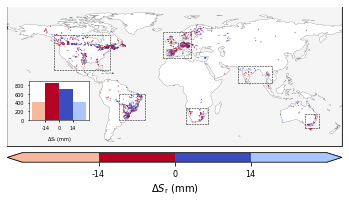

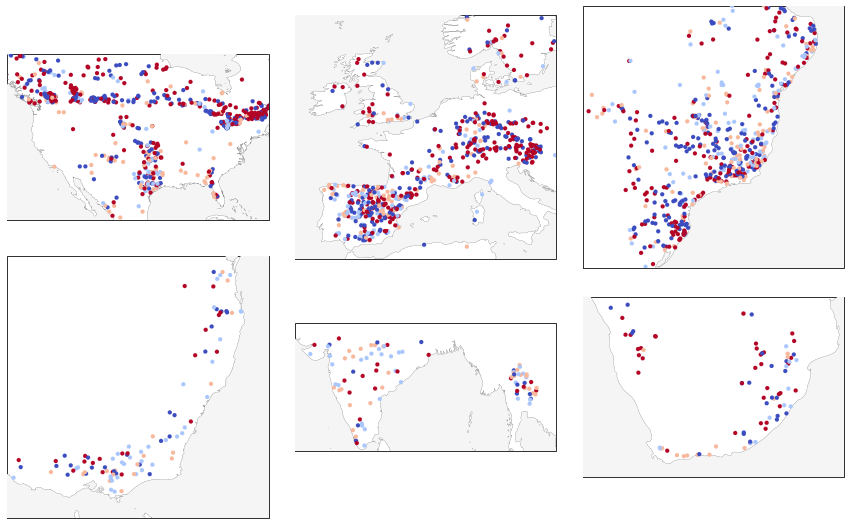

In [33]:
#Europe
lat_min_e, lat_max_e = 35,63 # 36,46 only spain cluster
lon_min_e, lon_max_e = -12,18 # -10,5 only spain cluster

#Asia
lat_min_a, lat_max_a = 8,26
lon_min_a, lon_max_a = 68,105

#us
lat_min_u, lat_max_u = 22,60
lon_min_u, lon_max_u = -130,-70

#south america
lat_min_s, lat_max_s = -32,-4
lon_min_s, lon_max_s = -60,-32

#south africa
lat_min_f, lat_max_f = -36,-19.5
lon_min_f, lon_max_f = 12,36

#australia
lat_min_t, lat_max_t = -40,-25
lon_min_t, lon_max_t = 140,155

# TRAIN
fig2 = plt.figure(figsize=(6,6))
# plt.subplots_adjust(wspace=0000.1,hspace=-0.4)
ax = fig2.add_subplot(111,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s=ax.scatter(lon_train,lat_train,s=0.7,c=df_train.group,edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_rdbu,norm=norm,zorder=102)
# cbar = plt.colorbar(s, orientation='vertical',spacing='proportional',extend='both', pad=0.02,aspect=15, norm=norm,shrink=0.35)
cbar = plt.colorbar(s, orientation='horizontal',spacing='proportional',extend='both', pad=0.02,aspect=35, norm=norm)
cbar.set_label('$\Delta$$S_\mathrm{r}$ (mm)')
cbar.set_ticks([1,2,3])
cbar.set_ticklabels([f'-{train_mae}','0',f'{train_mae}'],size=8)
# for j, lab in enumerate([f'$n$={len(df_train[df_train.group==0])}',f'$n$={len(df_train[df_train.group==1])}',f'$n$={len(df_train[df_train.group==2])}',f'$n$={len(df_train[df_train.group==3])}']):
#     cbar.ax.text((j + 0.5), 0.5, lab, ha='center', va='center')
# for j, lab in enumerate([f'$n$={len(df_train[df_train.group==0])}',f'$n$={len(df_train[df_train.group==1])}',f'$n$={len(df_train[df_train.group==2])}',f'$n$={len(df_train[df_train.group==3])}']):
#     cbar.ax.text(0.5,(j + 0.5), lab, ha='center', va='center',rotation=90,size=6)
ax.plot([lon_min_a,lon_max_a],[lat_max_a,lat_max_a],'k--',zorder=101,linewidth=0.5)
ax.plot([lon_min_a,lon_max_a],[lat_min_a,lat_min_a],'k--',zorder=101,linewidth=0.5)
ax.plot([lon_min_a,lon_min_a],[lat_min_a,lat_max_a],'k--',zorder=101,linewidth=0.5)
ax.plot([lon_max_a,lon_max_a],[lat_min_a,lat_max_a],'k--',zorder=101,linewidth=0.5)

ax.plot([lon_min_e,lon_max_e],[lat_max_e,lat_max_e],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_e,lon_max_e],[lat_min_e,lat_min_e],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_e,lon_min_e],[lat_min_e,lat_max_e],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_max_e,lon_max_e],[lat_min_e,lat_max_e],'k--',linewidth=0.5,zorder=101)

ax.plot([lon_min_u,lon_max_u],[lat_max_u,lat_max_u],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_u,lon_max_u],[lat_min_u,lat_min_u],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_u,lon_min_u],[lat_min_u,lat_max_u],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_max_u,lon_max_u],[lat_min_u,lat_max_u],'k--',linewidth=0.5,zorder=101)

ax.plot([lon_min_s,lon_max_s],[lat_max_s,lat_max_s],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_s,lon_max_s],[lat_min_s,lat_min_s],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_s,lon_min_s],[lat_min_s,lat_max_s],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_max_s,lon_max_s],[lat_min_s,lat_max_s],'k--',linewidth=0.5,zorder=101)

ax.plot([lon_min_t,lon_max_t],[lat_max_t,lat_max_t],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_t,lon_max_t],[lat_min_t,lat_min_t],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_t,lon_min_t],[lat_min_t,lat_max_t],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_max_t,lon_max_t],[lat_min_t,lat_max_t],'k--',linewidth=0.5,zorder=101)

ax.plot([lon_min_f,lon_max_f],[lat_max_f,lat_max_f],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_f,lon_max_f],[lat_min_f,lat_min_f],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_f,lon_min_f],[lat_min_f,lat_max_f],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_max_f,lon_max_f],[lat_min_f,lat_max_f],'k--',linewidth=0.5,zorder=101)

iax = inset_axes(ax, width="18%", height="28%",loc=3,bbox_transform=ax.transAxes,bbox_to_anchor=(0.05,0.15,1,1))
plt.setp(list(iax.spines.values()),linewidth=0.5)
bins = [df_train['Sr_p-Sr_m'].quantile(0.01),-train_mae,0,train_mae,df_train['Sr_p-Sr_m'].quantile(0.99)]
n = [len(df_train[df_train.group==0]['Sr_p-Sr_m']),len(df_train[df_train.group==1]['Sr_p-Sr_m']),len(df_train[df_train.group==2]['Sr_p-Sr_m']),len(df_train[df_train.group==3]['Sr_p-Sr_m'])]
iax.bar([0,1,2,3],n,width=1,color=[cmap_rdbu(0),cmap_rdbu(1),cmap_rdbu(2),cmap_rdbu(3)])
iax.set_xticks([0.5,1.5,2.5])
iax.set_yticks([0,200,400,600,800])
iax.set_xticklabels([f'-{train_mae}','0',f'{train_mae}'])
iax.set_xlabel('$\Delta$$S_\mathrm{r}$ (mm)',size=5)
# iax.invert_yaxis()
# iax.yaxis.tick_right()
# iax.set_ylabel('$n$',size=6)
# iax.yaxis.set_label_position("right")
# iax.xaxis.tick_top()
iax.tick_params(axis='both',length=1.5, labelsize=5)

# ax.set_title('train abs error [sr-mm - sr-pred] (mm)')
fig2.savefig(f'{work_dir}/output/regression/figures/interpretation/train_maps.jpg',bbox_inches='tight',dpi=300)

fig2 = plt.figure(figsize=(15,10))
ax = fig2.add_subplot(231,projection=ccrs.PlateCarree())
plt.subplots_adjust(wspace=0.1,hspace=-0.15)
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_ylim(lat_min_u,lat_max_u)
ax.set_xlim(lon_min_u,lon_max_u)
s=ax.scatter(lon_train,lat_train,s=17,c=df_train.group,edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_rdbu,norm=norm,zorder=101)

# fig2 = plt.figure(figsize=(6,6))
ax = fig2.add_subplot(232,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_ylim(lat_min_e,lat_max_e)
ax.set_xlim(lon_min_e,lon_max_e)
s=ax.scatter(lon_train,lat_train,s=17,c=df_train.group,edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_rdbu,norm=norm,zorder=101)

# fig2 = plt.figure(figsize=(6,6))
ax = fig2.add_subplot(233,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_ylim(lat_min_s,lat_max_s)
ax.set_xlim(lon_min_s,lon_max_s)
s=ax.scatter(lon_train,lat_train,s=17,c=df_train.group,edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_rdbu,norm=norm,zorder=101)

# fig2 = plt.figure(figsize=(6,6))
ax = fig2.add_subplot(234,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_ylim(lat_min_t,lat_max_t)
ax.set_xlim(lon_min_t,lon_max_t)
s=ax.scatter(lon_train,lat_train,s=17,c=df_train.group,edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_rdbu,norm=norm,zorder=101)

# fig2 = plt.figure(figsize=(6,6))
ax = fig2.add_subplot(235,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_ylim(lat_min_a,lat_max_a)
ax.set_xlim(lon_min_a,lon_max_a)
s=ax.scatter(lon_train,lat_train,s=17,c=df_train.group,edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_rdbu,norm=norm,zorder=101)

# fig2 = plt.figure(figsize=(6,6))
ax = fig2.add_subplot(236,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_ylim(lat_min_f,lat_max_f)
ax.set_xlim(lon_min_f,lon_max_f)
s=ax.scatter(lon_train,lat_train,s=17,c=df_train.group,edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_rdbu,norm=norm,zorder=101)
fig2.savefig(f'{work_dir}/output/regression/figures/interpretation/train_maps_zoomed.jpg',bbox_inches='tight',dpi=300)


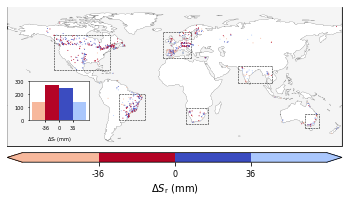

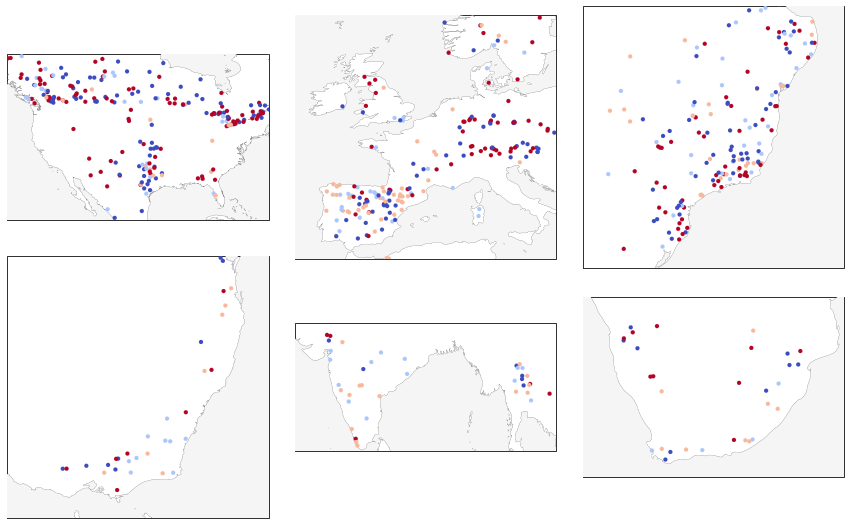

In [34]:
#Europe
lat_min_e, lat_max_e = 35,63 # 36,46 only spain cluster
lon_min_e, lon_max_e = -12,18 # -10,5 only spain cluster

#Asia
lat_min_a, lat_max_a = 8,26
lon_min_a, lon_max_a = 68,105

#us
lat_min_u, lat_max_u = 22,60
lon_min_u, lon_max_u = -130,-70

#south america
lat_min_s, lat_max_s = -32,-4
lon_min_s, lon_max_s = -60,-32

#south africa
lat_min_f, lat_max_f = -36,-19.5
lon_min_f, lon_max_f = 12,36

#australia
lat_min_t, lat_max_t = -40,-25
lon_min_t, lon_max_t = 140,155

# TEST
fig2 = plt.figure(figsize=(6,6))
# plt.subplots_adjust(wspace=0000.1,hspace=-0.4)
ax = fig2.add_subplot(111,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s=ax.scatter(lon_test,lat_test,s=0.7,c=df_test.group,edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_rdbu,norm=norm,zorder=102)
# cbar = plt.colorbar(s, orientation='vertical',spacing='proportional',extend='both', pad=0.02,aspect=15, norm=norm,shrink=0.35)
cbar = plt.colorbar(s, orientation='horizontal',spacing='proportional',extend='both', pad=0.02,aspect=35, norm=norm)
cbar.set_label('$\Delta$$S_\mathrm{r}$ (mm)')
cbar.set_ticks([1,2,3])
cbar.set_ticklabels([f'-{test_mae}','0',f'{test_mae}'],size=8)
# for j, lab in enumerate([f'$n$={len(df_test[df_test.group==0])}',f'$n$={len(df_test[df_test.group==1])}',f'$n$={len(df_test[df_test.group==2])}',f'$n$={len(df_test[df_test.group==3])}']):
#     cbar.ax.text((j + 0.5), 0.5, lab, ha='center', va='center')
# for j, lab in enumerate([f'$n$={len(df_test[df_test.group==0])}',f'$n$={len(df_test[df_test.group==1])}',f'$n$={len(df_test[df_test.group==2])}',f'$n$={len(df_test[df_test.group==3])}']):
#     cbar.ax.text(0.5,(j + 0.5), lab, ha='center', va='center',rotation=90,size=6)
ax.plot([lon_min_a,lon_max_a],[lat_max_a,lat_max_a],'k--',zorder=101,linewidth=0.5)
ax.plot([lon_min_a,lon_max_a],[lat_min_a,lat_min_a],'k--',zorder=101,linewidth=0.5)
ax.plot([lon_min_a,lon_min_a],[lat_min_a,lat_max_a],'k--',zorder=101,linewidth=0.5)
ax.plot([lon_max_a,lon_max_a],[lat_min_a,lat_max_a],'k--',zorder=101,linewidth=0.5)

ax.plot([lon_min_e,lon_max_e],[lat_max_e,lat_max_e],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_e,lon_max_e],[lat_min_e,lat_min_e],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_e,lon_min_e],[lat_min_e,lat_max_e],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_max_e,lon_max_e],[lat_min_e,lat_max_e],'k--',linewidth=0.5,zorder=101)

ax.plot([lon_min_u,lon_max_u],[lat_max_u,lat_max_u],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_u,lon_max_u],[lat_min_u,lat_min_u],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_u,lon_min_u],[lat_min_u,lat_max_u],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_max_u,lon_max_u],[lat_min_u,lat_max_u],'k--',linewidth=0.5,zorder=101)

ax.plot([lon_min_s,lon_max_s],[lat_max_s,lat_max_s],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_s,lon_max_s],[lat_min_s,lat_min_s],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_s,lon_min_s],[lat_min_s,lat_max_s],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_max_s,lon_max_s],[lat_min_s,lat_max_s],'k--',linewidth=0.5,zorder=101)

ax.plot([lon_min_t,lon_max_t],[lat_max_t,lat_max_t],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_t,lon_max_t],[lat_min_t,lat_min_t],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_t,lon_min_t],[lat_min_t,lat_max_t],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_max_t,lon_max_t],[lat_min_t,lat_max_t],'k--',linewidth=0.5,zorder=101)

ax.plot([lon_min_f,lon_max_f],[lat_max_f,lat_max_f],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_f,lon_max_f],[lat_min_f,lat_min_f],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_min_f,lon_min_f],[lat_min_f,lat_max_f],'k--',linewidth=0.5,zorder=101)
ax.plot([lon_max_f,lon_max_f],[lat_min_f,lat_max_f],'k--',linewidth=0.5,zorder=101)

iax = inset_axes(ax, width="18%", height="28%",loc=3,bbox_transform=ax.transAxes,bbox_to_anchor=(0.05,0.15,1,1))
plt.setp(list(iax.spines.values()),linewidth=0.5)
bins = [df_test['Sr_p-Sr_m'].quantile(0.01),-test_mae,0,test_mae,df_test['Sr_p-Sr_m'].quantile(0.99)]
n = [len(df_test[df_test.group==0]['Sr_p-Sr_m']),len(df_test[df_test.group==1]['Sr_p-Sr_m']),len(df_test[df_test.group==2]['Sr_p-Sr_m']),len(df_test[df_test.group==3]['Sr_p-Sr_m'])]
iax.bar([0,1,2,3],n,width=1,color=[cmap_rdbu(0),cmap_rdbu(1),cmap_rdbu(2),cmap_rdbu(3)])
iax.set_xticks([0.5,1.5,2.5])
iax.set_yticks([0,100,200,300])
iax.set_xticklabels([f'-{test_mae}','0',f'{test_mae}'])
iax.set_xlabel('$\Delta$$S_\mathrm{r}$ (mm)',size=5)
# iax.invert_yaxis()
# iax.yaxis.tick_right()
# iax.set_ylabel('$n$',size=6)
# iax.yaxis.set_label_position("right")
# iax.xaxis.tick_top()
iax.tick_params(axis='both',length=1.5, labelsize=5)

# ax.set_title('test abs error [sr-mm - sr-pred] (mm)')
fig2.savefig(f'{work_dir}/output/regression/figures/interpretation/test_maps.jpg',bbox_inches='tight',dpi=300)

fig2 = plt.figure(figsize=(15,10))
ax = fig2.add_subplot(231,projection=ccrs.PlateCarree())
plt.subplots_adjust(wspace=0.1,hspace=-0.15)
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_ylim(lat_min_u,lat_max_u)
ax.set_xlim(lon_min_u,lon_max_u)
s=ax.scatter(lon_test,lat_test,s=17,c=df_test.group,edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_rdbu,norm=norm,zorder=101)

# fig2 = plt.figure(figsize=(6,6))
ax = fig2.add_subplot(232,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_ylim(lat_min_e,lat_max_e)
ax.set_xlim(lon_min_e,lon_max_e)
s=ax.scatter(lon_test,lat_test,s=17,c=df_test.group,edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_rdbu,norm=norm,zorder=101)

# fig2 = plt.figure(figsize=(6,6))
ax = fig2.add_subplot(233,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_ylim(lat_min_s,lat_max_s)
ax.set_xlim(lon_min_s,lon_max_s)
s=ax.scatter(lon_test,lat_test,s=17,c=df_test.group,edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_rdbu,norm=norm,zorder=101)

# fig2 = plt.figure(figsize=(6,6))
ax = fig2.add_subplot(234,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_ylim(lat_min_t,lat_max_t)
ax.set_xlim(lon_min_t,lon_max_t)
s=ax.scatter(lon_test,lat_test,s=17,c=df_test.group,edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_rdbu,norm=norm,zorder=101)

# fig2 = plt.figure(figsize=(6,6))
ax = fig2.add_subplot(235,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_ylim(lat_min_a,lat_max_a)
ax.set_xlim(lon_min_a,lon_max_a)
s=ax.scatter(lon_test,lat_test,s=17,c=df_test.group,edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_rdbu,norm=norm,zorder=101)

# fig2 = plt.figure(figsize=(6,6))
ax = fig2.add_subplot(236,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_ylim(lat_min_f,lat_max_f)
ax.set_xlim(lon_min_f,lon_max_f)
s=ax.scatter(lon_test,lat_test,s=17,c=df_test.group,edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_rdbu,norm=norm,zorder=101)
fig2.savefig(f'{work_dir}/output/regression/figures/interpretation/test_maps_zoomed.jpg',bbox_inches='tight',dpi=300)


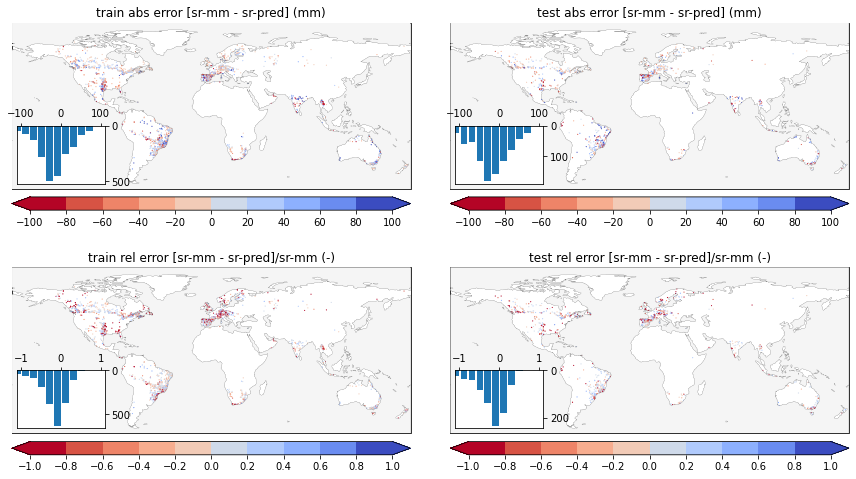

In [17]:
# maps
cmap_vd2 = cm.get_cmap('RdBu', 21)
cmap_rdbu = cm.get_cmap('coolwarm_r', 21)
# cmap_rdbu = cm.get_cmap('RdYlBu', 20)
# cmap_rdbu = cm.get_cmap('RdYlBu', 20)
# cmap_rdbu = ListedColormap([cmap_rdbu(0),cmap_rdbu(1),cmap_rdbu(2),cmap_rdbu(3),cmap_rdbu(4),cmap_rdbu(5),cmap_rdbu(6),cmap_rdbu(7),cmap_rdbu(8),
#                             (144/255,238/255,144/255),(144/255,238/255,144/255),
#                            cmap_rdbu(11),cmap_rdbu(12),cmap_rdbu(13),cmap_rdbu(14),cmap_rdbu(15),cmap_rdbu(16),cmap_rdbu(17),cmap_rdbu(18),cmap_rdbu(19)])

# cmap_rdbu = ListedColormap([cmap_rdbu(2),cmap_rdbu(3)])
bounds = np.linspace(-100,100,11)
bounds2 = np.linspace(-100,100,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap_rdbu.N)

train_er = y_train - train_y_pred
test_er = y_test- test_y_pred
train_err = (y_train - train_y_pred)/y_train
test_err = (y_test- test_y_pred)/y_test
fig2 = plt.figure(figsize=(15,12))
plt.subplots_adjust(wspace=0000.1,hspace=-0.4)
ax = fig2.add_subplot(221,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(lon_train,lat_train,s=1,c=train_er,norm=norm,cmap=cmap_rdbu,edgecolors='face',marker='o',linewidths=0.1)
cbar = plt.colorbar(s, orientation='horizontal', label='',spacing='proportional',extend='both', pad=0.02,aspect=30, norm=norm,ticks=bounds2)
ax.set_title('train abs error [sr-mm - sr-pred] (mm)')

iax = inset_axes(ax, width="22%", height="35%",loc=3)
iax.hist(train_er,bins=bounds,width=(bounds[0]-bounds[1])*0.85)
iax.invert_yaxis()
iax.yaxis.tick_right()
iax.xaxis.tick_top()

ax = fig2.add_subplot(222,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(lon_test,lat_test,s=1,c=test_er,cmap=cmap_rdbu, norm=norm,edgecolors='face',marker='o',linewidths=0.1)
cbar = plt.colorbar(s, orientation='horizontal', label='',spacing='proportional',extend='both', pad=0.02,aspect=30, norm=norm,ticks=bounds2)
ax.set_title('test abs error [sr-mm - sr-pred] (mm)')

iax = inset_axes(ax, width="22%", height="35%",loc=3)
iax.hist(test_er,bins=bounds,width=(bounds[0]-bounds[1])*0.85)
iax.invert_yaxis()
iax.yaxis.tick_right()
iax.xaxis.tick_top()

bounds = np.linspace(-1,1,11)
bounds2 = np.linspace(-1,1,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap_rdbu.N)

ax = fig2.add_subplot(223,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(lon_train,lat_train,s=1,c=train_err,norm=norm,cmap=cmap_rdbu,edgecolors='face',marker='o',linewidths=0.1)
cbar = plt.colorbar(s, orientation='horizontal', label='',spacing='proportional',extend='both', pad=0.02,aspect=30, norm=norm,ticks=bounds2)
ax.set_title('train rel error [sr-mm - sr-pred]/sr-mm (-)')

iax = inset_axes(ax, width="22%", height="35%",loc=3)
iax.hist(train_err,bins=bounds,width=(bounds[0]-bounds[1])*0.85)
iax.invert_yaxis()
iax.yaxis.tick_right()
iax.xaxis.tick_top()

ax = fig2.add_subplot(224,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(lon_test,lat_test,s=1,c=test_err,cmap=cmap_rdbu, norm=norm,edgecolors='face',marker='o',linewidths=0.1)
cbar = plt.colorbar(s, orientation='horizontal', label='',spacing='proportional',extend='both', pad=0.02,aspect=30, norm=norm,ticks=bounds2)
ax.set_title('test rel error [sr-mm - sr-pred]/sr-mm (-)')

iax = inset_axes(ax, width="22%", height="35%",loc=3)
iax.hist(test_err,bins=bounds,width=(bounds[0]-bounds[1])*0.85)
iax.invert_yaxis()
iax.yaxis.tick_right()
iax.xaxis.tick_top()
fig2.savefig(f'{work_dir}/output/regression/figures/interpretation/rf_regression_5var_allcatch_maps.jpg',bbox_inches='tight',dpi=300)


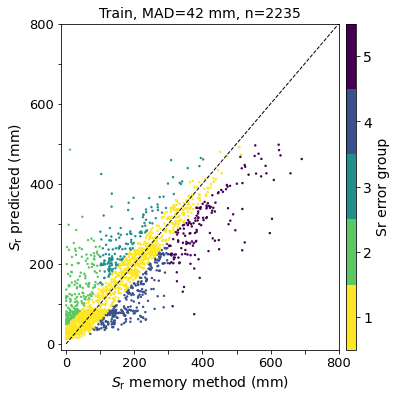

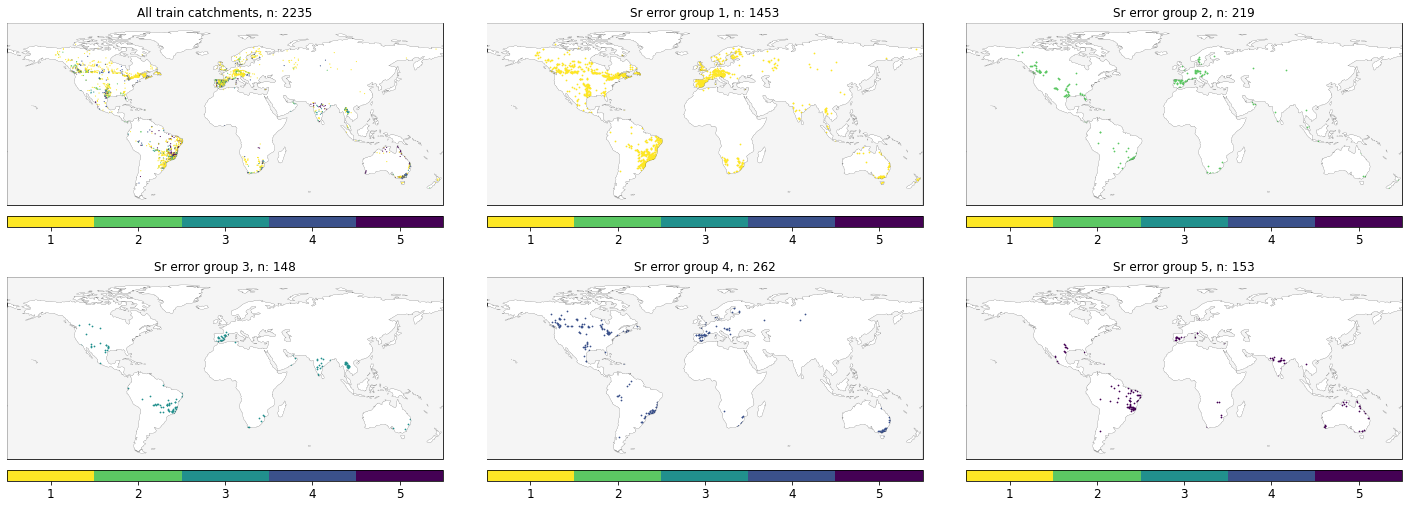

In [10]:
# color catchments in scatter plot based on error and use same colors on a map
df_train['group'] = np.nan
ix1 = df_train[(df_train['Sr_p-Sr_m']<train_mae) | (df_train['Sr_p-Sr_m']>-train_mae)].index
ix2 = df_train[(df_train['Sr_p-Sr_m']>train_mae) & (df_train['Sr_m']<100)].index
ix3 = df_train[(df_train['Sr_p-Sr_m']>train_mae) & (df_train['Sr_m']>100)].index
ix4 = df_train[(df_train['Sr_p-Sr_m']<-train_mae) & (df_train['Sr_m']<300)].index
ix5 = df_train[(df_train['Sr_p-Sr_m']<-train_mae) & (df_train['Sr_m']>300)].index

df_train.loc[ix1,'group'] = 0
df_train.loc[ix2,'group'] = 1
df_train.loc[ix3,'group'] = 2
df_train.loc[ix4,'group'] = 3
df_train.loc[ix5,'group'] = 4

# c2=(230/255,159/255,0/255)
# c3=(86/255,180/255,233/255)
# c4=(0/255,158/255,115/255)
# c5=(240/255,228/255,66/255)
# c6=(0/255,114/255,178/255)
# c7=(213/255,94/255,0/255)
# c8=(204/255,121/255,167/255)
# c = [c2,c4,c3,c5,c6]
# cml = ListedColormap(c)

# define the bins and normalize
bounds = np.linspace(0, 5, 6)
cmap = cm.get_cmap('viridis_r', 5)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig1 = plt.figure(figsize=(6,6))
ax = fig1.add_subplot(111)
s=ax.scatter(df_train.Sr_m,df_train.Sr_p,c=df_train.group,s=2,cmap=cmap,norm=norm)
ax.plot([0,800],[0,800],'k--',linewidth=1)
ax.set_title(f'Train, MAD={train_mae} mm, n={n_train}',size=14)
ax.set_xlim(-15,800)
ax.set_ylim(-15,800)
ax.set_yticks([0,100,200,300,400,500,600,700,800])
ax.set_xticks([0,100,200,300,400,500,600,700,800])
ax.set_yticklabels([0,'',200,'',400,'',600,'',800])
ax.set_xticklabels([0,'',200,'',400,'',600,'',800])
ax.set_xlabel('$S_\mathrm{r}$ memory method (mm)',size=14)
ax.set_ylabel('$S_\mathrm{r}$ predicted (mm)',size=14)
ax.tick_params(axis='both', labelsize=13)
cbar = plt.colorbar(s, orientation='vertical',spacing='proportional',extend='neither', pad=0.02,aspect=30,norm=norm, ticks=bounds, boundaries=bounds)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_yticks([0.5,1.5,2.5,3.5,4.5])
cbar.ax.set_yticklabels(['1','2','3','4','5'])
cbar.set_label(label='Sr error group', size=14)
fig1.savefig(f'{work_dir}/output/regression/figures/interpretation/scatter_train_grouped.jpg',bbox_inches='tight',dpi=300)

# maps
fig2 = plt.figure(figsize=(25,25))
ax = fig2.add_subplot(231,projection=ccrs.PlateCarree())
plt.subplots_adjust(wspace=0.1,hspace=-0.77)
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
s=ax.scatter(lon_train,lat_train,s=1,c=df_train.group,edgecolors='face',marker='o',linewidths=0.1,cmap=cmap,norm=norm)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
cbar = plt.colorbar(s, ax=ax, orientation='horizontal', label='',spacing='proportional',extend='neither', pad=0.01,aspect=40,norm=norm, ticks=bounds, boundaries=bounds)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_xticks([0.5,1.5,2.5,3.5,4.5])
cbar.ax.set_xticklabels(['1','2','3','4','5'])
ax.set_title(f'All train catchments, n: {len(df_train)}',size=12)

ax = fig2.add_subplot(232,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
ax.scatter(df_train[df_train.group==0].lon,df_train[df_train.group==0].lat,s=2.5,color=cmap(0),edgecolors='face',marker='o',linewidths=0.1,cmap=cmap,norm=norm)
cbar = plt.colorbar(s, ax=ax, orientation='horizontal', label='',spacing='proportional',extend='neither', pad=0.01,aspect=40,norm=norm, ticks=bounds, boundaries=bounds)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_xticks([0.5,1.5,2.5,3.5,4.5])
cbar.ax.set_xticklabels(['1','2','3','4','5'])
ax.set_title(f'Sr error group 1, n: {len(df_train[df_train.group==0])}',size=12)

ax = fig2.add_subplot(233,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
ax.scatter(df_train[df_train.group==1].lon,df_train[df_train.group==1].lat,s=2.5,color=cmap(1),edgecolors='face',marker='o',linewidths=0.1,cmap=cmap,norm=norm)
cbar = plt.colorbar(s, ax=ax, orientation='horizontal', label='',spacing='proportional',extend='neither', pad=0.01,aspect=40,norm=norm, ticks=bounds, boundaries=bounds)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_xticks([0.5,1.5,2.5,3.5,4.5])
cbar.ax.set_xticklabels(['1','2','3','4','5'])
ax.set_title(f'Sr error group 2, n: {len(df_train[df_train.group==1])}',size=12)

ax = fig2.add_subplot(234,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
ax.scatter(df_train[df_train.group==2].lon,df_train[df_train.group==2].lat,s=2.5,color=cmap(2),edgecolors='face',marker='o',linewidths=0.1,cmap=cmap,norm=norm)
cbar = plt.colorbar(s, ax=ax, orientation='horizontal', label='',spacing='proportional',extend='neither', pad=0.01,aspect=40,norm=norm, ticks=bounds, boundaries=bounds)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_xticks([0.5,1.5,2.5,3.5,4.5])
cbar.ax.set_xticklabels(['1','2','3','4','5'])
ax.set_title(f'Sr error group 3, n: {len(df_train[df_train.group==2])}',size=12)

ax = fig2.add_subplot(235,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
ax.scatter(df_train[df_train.group==3].lon,df_train[df_train.group==3].lat,s=2.5,color=cmap(3),edgecolors='face',marker='o',linewidths=0.1,cmap=cmap,norm=norm)
cbar = plt.colorbar(s, ax=ax,orientation='horizontal', label='',spacing='proportional',extend='neither', pad=0.01,aspect=40,norm=norm, ticks=bounds, boundaries=bounds)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_xticks([0.5,1.5,2.5,3.5,4.5])
cbar.ax.set_xticklabels(['1','2','3','4','5'])
ax.set_title(f'Sr error group 4, n: {len(df_train[df_train.group==3])}',size=12)

ax = fig2.add_subplot(236,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
ax.scatter(df_train[df_train.group==4].lon,df_train[df_train.group==4].lat,s=2.5,color=cmap(4),edgecolors='face',marker='o',linewidths=0.1,cmap=cmap,norm=norm)
cbar = plt.colorbar(s, ax=ax, orientation='horizontal', label='',spacing='proportional',extend='neither', pad=0.01,aspect=40,norm=norm, ticks=bounds, boundaries=bounds)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_xticks([0.5,1.5,2.5,3.5,4.5])
cbar.ax.set_xticklabels(['1','2','3','4','5'])
ax.set_title(f'Sr error group 5, n: {len(df_train[df_train.group==4])}',size=12)

fig2.savefig(f'{work_dir}/output/regression/figures/interpretation/maps_train_grouped.jpg',bbox_inches='tight',dpi=300)



In [47]:
# select catchments from test data to zoom in
# cid0 = 'za_0000220'
# cid1 = 'us_0005588'
# cid2 = 'ca_0004008'
# cid3 = 'es_0001098'
# cid4 = '410057'
# cid5 = 'br_0000292'

# without resampled points added to test
# cid0='br_0002638'
# cid1='es_0000236'
# cid2='ca_0005958'
# cid3='br_0001272'
# cid4='us_0006149'
# cid5='G8210010'

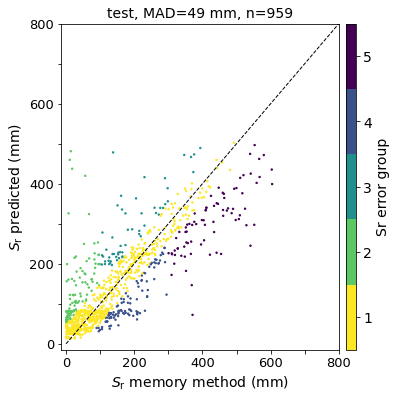

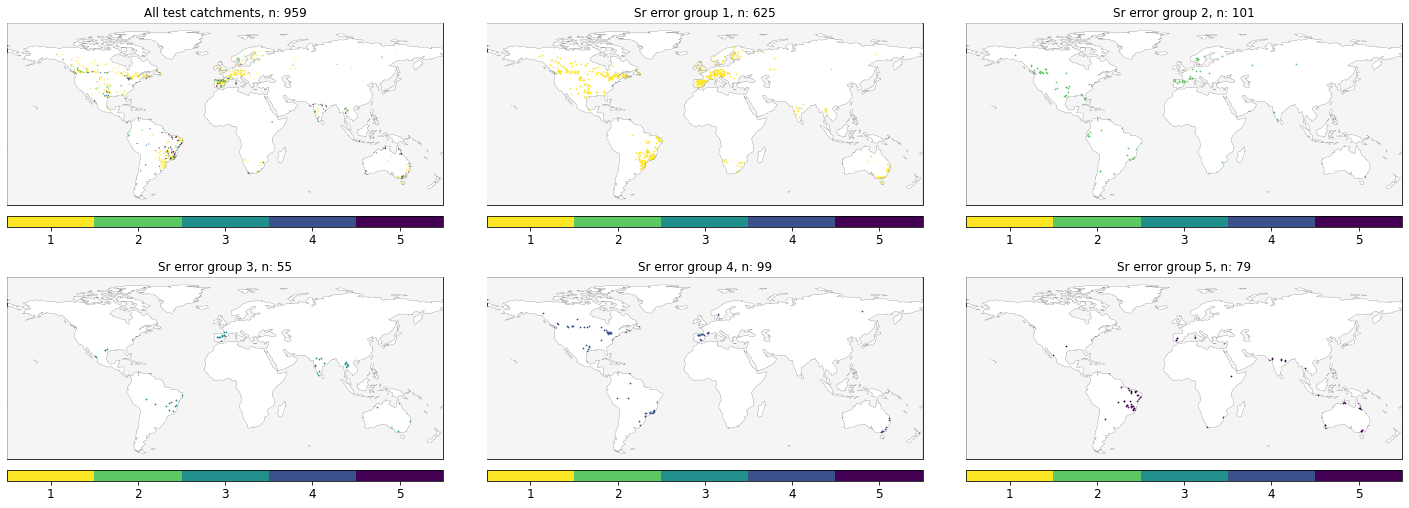

In [48]:
# color catchments in scatter plot based on error and use same colors on a map
df_test['group'] = np.nan
ix1 = df_test[(df_test['Sr_p-Sr_m']<test_mae) | (df_test['Sr_p-Sr_m']>-test_mae)].index
ix2 = df_test[(df_test['Sr_p-Sr_m']>test_mae) & (df_test['Sr_m']<100)].index
ix3 = df_test[(df_test['Sr_p-Sr_m']>test_mae) & (df_test['Sr_m']>100)].index
ix4 = df_test[(df_test['Sr_p-Sr_m']<-test_mae) & (df_test['Sr_m']<300)].index
ix5 = df_test[(df_test['Sr_p-Sr_m']<-test_mae) & (df_test['Sr_m']>300)].index

df_test.loc[ix1,'group'] = 0
df_test.loc[ix2,'group'] = 1
df_test.loc[ix3,'group'] = 2
df_test.loc[ix4,'group'] = 3
df_test.loc[ix5,'group'] = 4

# c2=(230/255,159/255,0/255)
# c3=(86/255,180/255,233/255)
# c4=(0/255,158/255,115/255)
# c5=(240/255,228/255,66/255)
# c6=(0/255,114/255,178/255)
# c7=(213/255,94/255,0/255)
# c8=(204/255,121/255,167/255)
# c = [c2,c4,c3,c5,c6]
# cml = ListedColormap(c)

# define the bins and normalize
bounds = np.linspace(0, 5, 6)
cmap = cm.get_cmap('viridis_r', 5)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig1 = plt.figure(figsize=(6,6))
ax = fig1.add_subplot(111)
s=ax.scatter(df_test.Sr_m,df_test.Sr_p,c=df_test.group,s=2,cmap=cmap,norm=norm)
ax.plot([0,800],[0,800],'k--',linewidth=1)
ax.set_title(f'test, MAD={test_mae} mm, n={n_test}',size=14)
ax.set_xlim(-15,800)
ax.set_ylim(-15,800)
ax.set_yticks([0,100,200,300,400,500,600,700,800])
ax.set_xticks([0,100,200,300,400,500,600,700,800])
ax.set_yticklabels([0,'',200,'',400,'',600,'',800])
ax.set_xticklabels([0,'',200,'',400,'',600,'',800])
ax.set_xlabel('$S_\mathrm{r}$ memory method (mm)',size=14)
ax.set_ylabel('$S_\mathrm{r}$ predicted (mm)',size=14)
ax.tick_params(axis='both', labelsize=13)
cbar = plt.colorbar(s, orientation='vertical',spacing='proportional',extend='neither', pad=0.02,aspect=30,norm=norm, ticks=bounds, boundaries=bounds)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_yticks([0.5,1.5,2.5,3.5,4.5])
cbar.ax.set_yticklabels(['1','2','3','4','5'])
cbar.set_label(label='Sr error group', size=14)
fig1.savefig(f'{work_dir}/output/regression/figures/interpretation/scatter_test_grouped.jpg',bbox_inches='tight',dpi=300)

# maps
fig2 = plt.figure(figsize=(25,25))
ax = fig2.add_subplot(231,projection=ccrs.PlateCarree())
plt.subplots_adjust(wspace=0.1,hspace=-0.77)
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
s=ax.scatter(lon_test,lat_test,s=1,c=df_test.group,edgecolors='face',marker='o',linewidths=0.1,cmap=cmap,norm=norm)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
cbar = plt.colorbar(s, ax=ax, orientation='horizontal', label='',spacing='proportional',extend='neither', pad=0.01,aspect=40,norm=norm, ticks=bounds, boundaries=bounds)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_xticks([0.5,1.5,2.5,3.5,4.5])
cbar.ax.set_xticklabels(['1','2','3','4','5'])
ax.set_title(f'All test catchments, n: {len(df_test)}',size=12)

ax = fig2.add_subplot(232,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
ax.scatter(df_test[df_test.group==0].lon,df_test[df_test.group==0].lat,s=2.5,color=cmap(0),edgecolors='face',marker='o',linewidths=0.1,cmap=cmap,norm=norm)
cbar = plt.colorbar(s, ax=ax, orientation='horizontal', label='',spacing='proportional',extend='neither', pad=0.01,aspect=40,norm=norm, ticks=bounds, boundaries=bounds)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_xticks([0.5,1.5,2.5,3.5,4.5])
cbar.ax.set_xticklabels(['1','2','3','4','5'])
ax.set_title(f'Sr error group 1, n: {len(df_test[df_test.group==0])}',size=12)

ax = fig2.add_subplot(233,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
ax.scatter(df_test[df_test.group==1].lon,df_test[df_test.group==1].lat,s=2.5,color=cmap(1),edgecolors='face',marker='o',linewidths=0.1,cmap=cmap,norm=norm)
cbar = plt.colorbar(s, ax=ax, orientation='horizontal', label='',spacing='proportional',extend='neither', pad=0.01,aspect=40,norm=norm, ticks=bounds, boundaries=bounds)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_xticks([0.5,1.5,2.5,3.5,4.5])
cbar.ax.set_xticklabels(['1','2','3','4','5'])
ax.set_title(f'Sr error group 2, n: {len(df_test[df_test.group==1])}',size=12)

ax = fig2.add_subplot(234,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
ax.scatter(df_test[df_test.group==2].lon,df_test[df_test.group==2].lat,s=2.5,color=cmap(2),edgecolors='face',marker='o',linewidths=0.1,cmap=cmap,norm=norm)
cbar = plt.colorbar(s, ax=ax, orientation='horizontal', label='',spacing='proportional',extend='neither', pad=0.01,aspect=40,norm=norm, ticks=bounds, boundaries=bounds)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_xticks([0.5,1.5,2.5,3.5,4.5])
cbar.ax.set_xticklabels(['1','2','3','4','5'])
ax.set_title(f'Sr error group 3, n: {len(df_test[df_test.group==2])}',size=12)

ax = fig2.add_subplot(235,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
ax.scatter(df_test[df_test.group==3].lon,df_test[df_test.group==3].lat,s=2.5,color=cmap(3),edgecolors='face',marker='o',linewidths=0.1,cmap=cmap,norm=norm)
cbar = plt.colorbar(s, ax=ax,orientation='horizontal', label='',spacing='proportional',extend='neither', pad=0.01,aspect=40,norm=norm, ticks=bounds, boundaries=bounds)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_xticks([0.5,1.5,2.5,3.5,4.5])
cbar.ax.set_xticklabels(['1','2','3','4','5'])
ax.set_title(f'Sr error group 4, n: {len(df_test[df_test.group==3])}',size=12)

ax = fig2.add_subplot(236,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
ax.scatter(df_test[df_test.group==4].lon,df_test[df_test.group==4].lat,s=2.5,color=cmap(4),edgecolors='face',marker='o',linewidths=0.1,cmap=cmap,norm=norm)
cbar = plt.colorbar(s, ax=ax, orientation='horizontal', label='',spacing='proportional',extend='neither', pad=0.01,aspect=40,norm=norm, ticks=bounds, boundaries=bounds)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_xticks([0.5,1.5,2.5,3.5,4.5])
cbar.ax.set_xticklabels(['1','2','3','4','5'])
ax.set_title(f'Sr error group 5, n: {len(df_test[df_test.group==4])}',size=12)

fig2.savefig(f'{work_dir}/output/regression/figures/interpretation/maps_test_grouped.jpg',bbox_inches='tight',dpi=300)


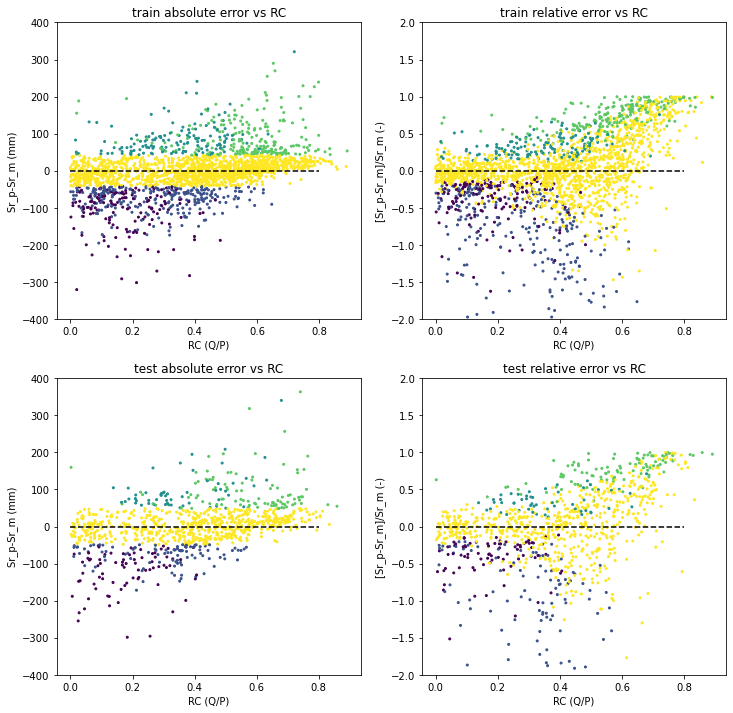

In [49]:
# plot error vs runoff coefficient
dff = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}.csv',index_col=0)

df_test['rc'] = dff['q_mean']/dff['p_mean']
df_train['rc'] = dff['q_mean']/dff['p_mean']

# define the bins and normalize
bounds = np.linspace(0, 5, 6)
cmap = cm.get_cmap('viridis_r', 5)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(221)
ax.scatter(df_train['rc'],df_train['Sr_p-Sr_m'],c=df_train['group'],s=4,cmap=cmap,norm=norm)
ax.plot([0,0.8],[0,0],'k--')
ax.set_ylim(-400,400)
ax.set_xlabel('RC (Q/P)')
ax.set_ylabel('Sr_p-Sr_m (mm)')
ax.set_title('train absolute error vs RC')

ax = fig.add_subplot(222)
ax.scatter(df_train['rc'],df_train['(Sr_p-Sr_m)/Sr_m'],c=df_train['group'],s=4,cmap=cmap,norm=norm)
ax.plot([0,0.8],[0,0],'k--')
ax.set_ylim(-2,2)
ax.set_xlabel('RC (Q/P)')
ax.set_ylabel('[Sr_p-Sr_m]/Sr_m (-)')
ax.set_title('train relative error vs RC')

ax = fig.add_subplot(223)
ax.scatter(df_test['rc'],df_test['Sr_p-Sr_m'],c=df_test['group'],s=4,cmap=cmap,norm=norm)
ax.set_ylim(-400,400)
ax.plot([0,0.8],[0,0],'k--')
ax.set_xlabel('RC (Q/P)')
ax.set_ylabel('Sr_p-Sr_m (mm)')
ax.set_title('test absolute error vs RC')

ax = fig.add_subplot(224)
ax.scatter(df_test['rc'],df_test['(Sr_p-Sr_m)/Sr_m'],c=df_test['group'],s=4,cmap=cmap,norm=norm)
ax.plot([0,0.8],[0,0],'k--')
ax.set_ylim(-2,2)
ax.set_xlabel('RC (Q/P)')
ax.set_ylabel('[Sr_p-Sr_m]/Sr_m (-)')
ax.set_title('test relative error vs RC')

fig.savefig(f'{work_dir}/output/regression/figures/interpretation/error_groups_rc.jpg',bbox_inches='tight',dpi=300)

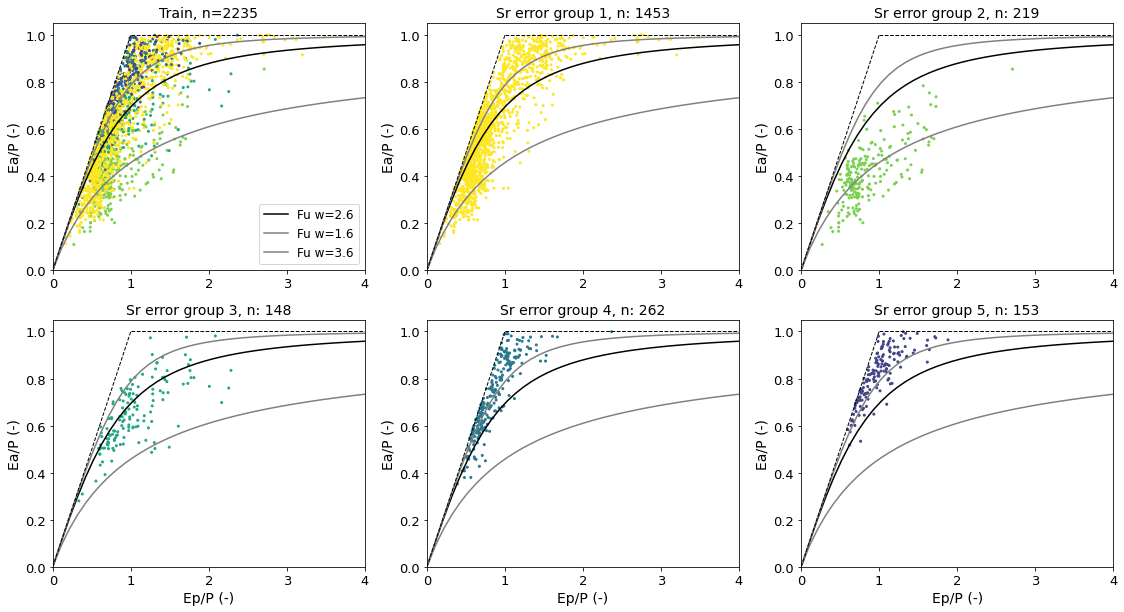

In [50]:
# plot in budyko
dff = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}.csv',index_col=0)

df_train['bud_x'] = dff['ep_mean']/dff['p_mean']
df_train['bud_y'] = (dff['p_mean']-dff['q_mean'])/dff['p_mean']

ai = np.linspace(0.01,5,50)
budy_s = 1-np.exp(-ai)
budy_o = ai*np.tanh(1/ai)
budy_b = np.sqrt(ai*(np.tanh(1/ai)*(1-np.exp(-ai))))
budy_t = 1/(np.sqrt(0.9+((1/ai)**2)))
w=2.6
budy_f = 1 + ai - (1 + ai**w)**(1/w)
w = 1.6
budy_f1 = 1 + ai - (1 + ai**w)**(1/w)
w=3.6
budy_f2 = 1 + ai - (1 + ai**w)**(1/w)

# define the bins and normalize
bounds = np.linspace(0, 6, 7)
cmap = cm.get_cmap('viridis_r', 6)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig = plt.figure(figsize=(19,10))
ax = fig.add_subplot(231)
ax.scatter(df_train['bud_x'],df_train['bud_y'],c=df_train['group'],s=4,cmap=cmap,norm=norm)
ax.plot(ai,budy_f, label='Fu w=2.6', color='k',linewidth=1.5)
ax.plot(ai,budy_f1, label='Fu w=1.6', color='grey',linewidth=1.5)
ax.plot(ai,budy_f2, label='Fu w=3.6', color='grey',linewidth=1.5)
ax.plot([0,1],[0,1],'k--',linewidth=1)
ax.plot([1,12],[1,1],'k--',linewidth=1)
ax.plot([0,12],[0,0],'k--',linewidth=1)
ax.set_title(f'Train, n={n_train}',size=14)
ax.set_xlim(0,4)
ax.set_ylim(0,1.05)
# ax.set_xlabel('Ep/P (-)',size=14)
ax.set_ylabel('Ea/P (-)',size=14)
ax.tick_params(axis='both', labelsize=13)
ax.legend(fontsize=12)

ax = fig.add_subplot(232)
ax.scatter(df_train[df_train.group==0]['bud_x'],df_train[df_train.group==0]['bud_y'],c=df_train[df_train.group==0]['group'],s=4,cmap=cmap,norm=norm)
ax.plot(ai,budy_f, label='Fu w=2.6', color='k',linewidth=1.5)
ax.plot(ai,budy_f1, label='Fu w=1.6', color='grey',linewidth=1.5)
ax.plot(ai,budy_f2, label='Fu w=3.6', color='grey',linewidth=1.5)
ax.plot([0,1],[0,1],'k--',linewidth=1)
ax.plot([1,12],[1,1],'k--',linewidth=1)
ax.plot([0,12],[0,0],'k--',linewidth=1)
ax.set_title(f'Train, n={n_train}',size=14)
ax.set_xlim(0,4)
ax.set_ylim(0,1.05)
# ax.set_xlabel('Ep/P (-)',size=14)
ax.set_ylabel('Ea/P (-)',size=14)
ax.tick_params(axis='both', labelsize=13)
ax.set_title(f'Sr error group 1, n: {len(df_train[df_train.group==0])}',size=14)

ax = fig.add_subplot(233)
ax.scatter(df_train[df_train.group==1]['bud_x'],df_train[df_train.group==1]['bud_y'],c=df_train[df_train.group==1]['group'],s=4,cmap=cmap,norm=norm)
ax.plot(ai,budy_f, label='Fu w=2.6', color='k',linewidth=1.5)
ax.plot(ai,budy_f1, label='Fu w=1.6', color='grey',linewidth=1.5)
ax.plot(ai,budy_f2, label='Fu w=3.6', color='grey',linewidth=1.5)
ax.plot([0,1],[0,1],'k--',linewidth=1)
ax.plot([1,12],[1,1],'k--',linewidth=1)
ax.plot([0,12],[0,0],'k--',linewidth=1)
ax.set_xlim(0,4)
ax.set_ylim(0,1.05)
# ax.set_xlabel('Ep/P (-)',size=14)
ax.set_ylabel('Ea/P (-)',size=14)
ax.tick_params(axis='both', labelsize=13)
ax.set_title(f'Sr error group 2, n: {len(df_train[df_train.group==1])}',size=14)

ax = fig.add_subplot(234)
ax.scatter(df_train[df_train.group==2]['bud_x'],df_train[df_train.group==2]['bud_y'],c=df_train[df_train.group==2]['group'],s=4,cmap=cmap,norm=norm)
ax.plot(ai,budy_f, label='Fu w=2.6', color='k',linewidth=1.5)
ax.plot(ai,budy_f1, label='Fu w=1.6', color='grey',linewidth=1.5)
ax.plot(ai,budy_f2, label='Fu w=3.6', color='grey',linewidth=1.5)
ax.plot([0,1],[0,1],'k--',linewidth=1)
ax.plot([1,12],[1,1],'k--',linewidth=1)
ax.plot([0,12],[0,0],'k--',linewidth=1)
ax.set_xlim(0,4)
ax.set_ylim(0,1.05)
ax.set_xlabel('Ep/P (-)',size=14)
ax.set_ylabel('Ea/P (-)',size=14)
ax.tick_params(axis='both', labelsize=13)
ax.set_title(f'Sr error group 3, n: {len(df_train[df_train.group==2])}',size=14)

ax = fig.add_subplot(235)
ax.scatter(df_train[df_train.group==3]['bud_x'],df_train[df_train.group==3]['bud_y'],c=df_train[df_train.group==3]['group'],s=4,cmap=cmap,norm=norm)
ax.plot(ai,budy_f, label='Fu w=2.6', color='k',linewidth=1.5)
ax.plot(ai,budy_f1, label='Fu w=1.6', color='grey',linewidth=1.5)
ax.plot(ai,budy_f2, label='Fu w=3.6', color='grey',linewidth=1.5)
ax.plot([0,1],[0,1],'k--',linewidth=1)
ax.plot([1,12],[1,1],'k--',linewidth=1)
ax.plot([0,12],[0,0],'k--',linewidth=1)
ax.set_xlim(0,4)
ax.set_ylim(0,1.05)
ax.set_xlabel('Ep/P (-)',size=14)
ax.set_ylabel('Ea/P (-)',size=14)
ax.tick_params(axis='both', labelsize=13)
ax.set_title(f'Sr error group 4, n: {len(df_train[df_train.group==3])}',size=14)

ax = fig.add_subplot(236)
ax.scatter(df_train[df_train.group==4]['bud_x'],df_train[df_train.group==4]['bud_y'],c=df_train[df_train.group==4]['group'],s=4,cmap=cmap,norm=norm)
ax.plot(ai,budy_f, label='Fu w=2.6', color='k',linewidth=1.5)
ax.plot(ai,budy_f1, label='Fu w=1.6', color='grey',linewidth=1.5)
ax.plot(ai,budy_f2, label='Fu w=3.6', color='grey',linewidth=1.5)
ax.plot([0,1],[0,1],'k--',linewidth=1)
ax.plot([1,12],[1,1],'k--',linewidth=1)
ax.plot([0,12],[0,0],'k--',linewidth=1)
ax.set_xlim(0,4)
ax.set_ylim(0,1.05)
ax.set_xlabel('Ep/P (-)',size=14)
ax.set_ylabel('Ea/P (-)',size=14)
ax.tick_params(axis='both', labelsize=13)
ax.set_title(f'Sr error group 5, n: {len(df_train[df_train.group==4])}',size=14)

fig.savefig(f'{work_dir}/output/regression/figures/interpretation/error_groups_budyko_train.jpg',bbox_inches='tight',dpi=300)


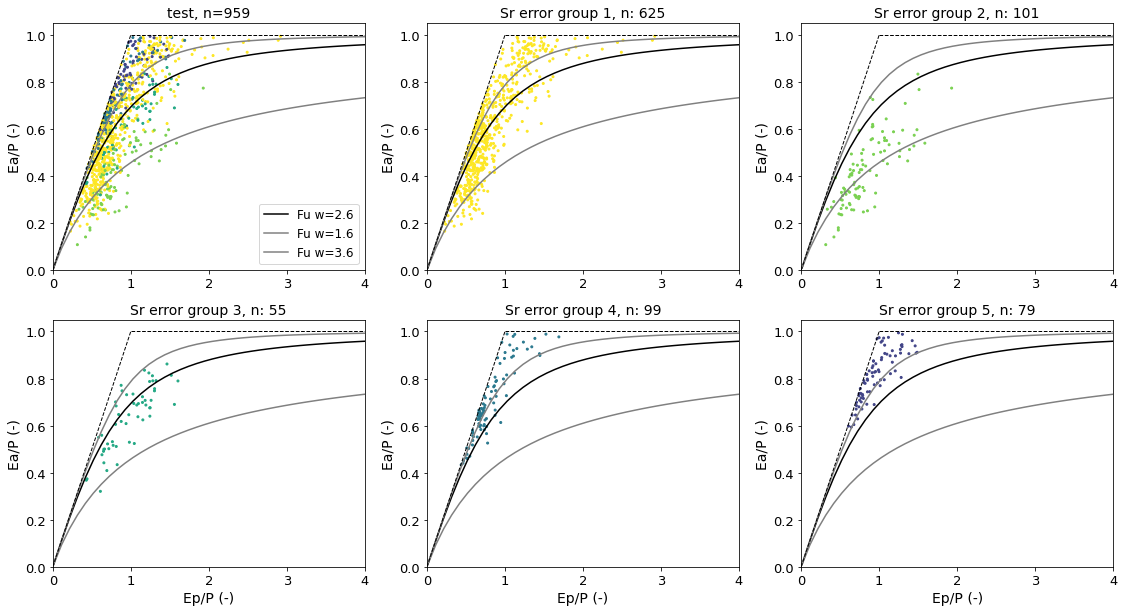

In [51]:
# plot in budyko
dff = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}.csv',index_col=0)

df_test['bud_x'] = dff['ep_mean']/dff['p_mean']
df_test['bud_y'] = (dff['p_mean']-dff['q_mean'])/dff['p_mean']

# define the bins and normalize
bounds = np.linspace(0, 6, 7)
cmap = cm.get_cmap('viridis_r', 6)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig = plt.figure(figsize=(19,10))
ax = fig.add_subplot(231)
ax.scatter(df_test['bud_x'],df_test['bud_y'],c=df_test['group'],s=4,cmap=cmap,norm=norm)
ax.plot(ai,budy_f, label='Fu w=2.6', color='k',linewidth=1.5)
ax.plot(ai,budy_f1, label='Fu w=1.6', color='grey',linewidth=1.5)
ax.plot(ai,budy_f2, label='Fu w=3.6', color='grey',linewidth=1.5)
ax.plot([0,1],[0,1],'k--',linewidth=1)
ax.plot([1,12],[1,1],'k--',linewidth=1)
ax.plot([0,12],[0,0],'k--',linewidth=1)
ax.set_title(f'test, n={n_test}',size=14)
ax.set_xlim(0,4)
ax.set_ylim(0,1.05)
# ax.set_xlabel('Ep/P (-)',size=14)
ax.set_ylabel('Ea/P (-)',size=14)
ax.tick_params(axis='both', labelsize=13)
ax.legend(fontsize=12)

ax = fig.add_subplot(232)
ax.scatter(df_test[df_test.group==0]['bud_x'],df_test[df_test.group==0]['bud_y'],c=df_test[df_test.group==0]['group'],s=4,cmap=cmap,norm=norm)
ax.plot(ai,budy_f, label='Fu w=2.6', color='k',linewidth=1.5)
ax.plot(ai,budy_f1, label='Fu w=1.6', color='grey',linewidth=1.5)
ax.plot(ai,budy_f2, label='Fu w=3.6', color='grey',linewidth=1.5)
ax.plot([0,1],[0,1],'k--',linewidth=1)
ax.plot([1,12],[1,1],'k--',linewidth=1)
ax.plot([0,12],[0,0],'k--',linewidth=1)
ax.set_title(f'test, n={n_test}',size=14)
ax.set_xlim(0,4)
ax.set_ylim(0,1.05)
# ax.set_xlabel('Ep/P (-)',size=14)
ax.set_ylabel('Ea/P (-)',size=14)
ax.tick_params(axis='both', labelsize=13)
ax.set_title(f'Sr error group 1, n: {len(df_test[df_test.group==0])}',size=14)

ax = fig.add_subplot(233)
ax.scatter(df_test[df_test.group==1]['bud_x'],df_test[df_test.group==1]['bud_y'],c=df_test[df_test.group==1]['group'],s=4,cmap=cmap,norm=norm)
ax.plot(ai,budy_f, label='Fu w=2.6', color='k',linewidth=1.5)
ax.plot(ai,budy_f1, label='Fu w=1.6', color='grey',linewidth=1.5)
ax.plot(ai,budy_f2, label='Fu w=3.6', color='grey',linewidth=1.5)
ax.plot([0,1],[0,1],'k--',linewidth=1)
ax.plot([1,12],[1,1],'k--',linewidth=1)
ax.plot([0,12],[0,0],'k--',linewidth=1)
ax.set_xlim(0,4)
ax.set_ylim(0,1.05)
# ax.set_xlabel('Ep/P (-)',size=14)
ax.set_ylabel('Ea/P (-)',size=14)
ax.tick_params(axis='both', labelsize=13)
ax.set_title(f'Sr error group 2, n: {len(df_test[df_test.group==1])}',size=14)

ax = fig.add_subplot(234)
ax.scatter(df_test[df_test.group==2]['bud_x'],df_test[df_test.group==2]['bud_y'],c=df_test[df_test.group==2]['group'],s=4,cmap=cmap,norm=norm)
ax.plot(ai,budy_f, label='Fu w=2.6', color='k',linewidth=1.5)
ax.plot(ai,budy_f1, label='Fu w=1.6', color='grey',linewidth=1.5)
ax.plot(ai,budy_f2, label='Fu w=3.6', color='grey',linewidth=1.5)
ax.plot([0,1],[0,1],'k--',linewidth=1)
ax.plot([1,12],[1,1],'k--',linewidth=1)
ax.plot([0,12],[0,0],'k--',linewidth=1)
ax.set_xlim(0,4)
ax.set_ylim(0,1.05)
ax.set_xlabel('Ep/P (-)',size=14)
ax.set_ylabel('Ea/P (-)',size=14)
ax.tick_params(axis='both', labelsize=13)
ax.set_title(f'Sr error group 3, n: {len(df_test[df_test.group==2])}',size=14)

ax = fig.add_subplot(235)
ax.scatter(df_test[df_test.group==3]['bud_x'],df_test[df_test.group==3]['bud_y'],c=df_test[df_test.group==3]['group'],s=4,cmap=cmap,norm=norm)
ax.plot(ai,budy_f, label='Fu w=2.6', color='k',linewidth=1.5)
ax.plot(ai,budy_f1, label='Fu w=1.6', color='grey',linewidth=1.5)
ax.plot(ai,budy_f2, label='Fu w=3.6', color='grey',linewidth=1.5)
ax.plot([0,1],[0,1],'k--',linewidth=1)
ax.plot([1,12],[1,1],'k--',linewidth=1)
ax.plot([0,12],[0,0],'k--',linewidth=1)
ax.set_xlim(0,4)
ax.set_ylim(0,1.05)
ax.set_xlabel('Ep/P (-)',size=14)
ax.set_ylabel('Ea/P (-)',size=14)
ax.tick_params(axis='both', labelsize=13)
ax.set_title(f'Sr error group 4, n: {len(df_test[df_test.group==3])}',size=14)

ax = fig.add_subplot(236)
ax.scatter(df_test[df_test.group==4]['bud_x'],df_test[df_test.group==4]['bud_y'],c=df_test[df_test.group==4]['group'],s=4,cmap=cmap,norm=norm)
ax.plot(ai,budy_f, label='Fu w=2.6', color='k',linewidth=1.5)
ax.plot(ai,budy_f1, label='Fu w=1.6', color='grey',linewidth=1.5)
ax.plot(ai,budy_f2, label='Fu w=3.6', color='grey',linewidth=1.5)
ax.plot([0,1],[0,1],'k--',linewidth=1)
ax.plot([1,12],[1,1],'k--',linewidth=1)
ax.plot([0,12],[0,0],'k--',linewidth=1)
ax.set_xlim(0,4)
ax.set_ylim(0,1.05)
ax.set_xlabel('Ep/P (-)',size=14)
ax.set_ylabel('Ea/P (-)',size=14)
ax.tick_params(axis='both', labelsize=13)
ax.set_title(f'Sr error group 5, n: {len(df_test[df_test.group==4])}',size=14)

fig.savefig(f'{work_dir}/output/regression/figures/interpretation/error_groups_budyko_test.jpg',bbox_inches='tight',dpi=300)

In [52]:
def plot_timeseries(cid,df_test):
    ms = pd.read_csv(f'{work_dir}/output/forcing_timeseries/mswep_p/mean_p_1981_2010.csv',index_col=0)
    eph = pd.read_csv(f'{work_dir}/output/forcing_timeseries/ep_hs_mean_catchments.csv',index_col=0)
    df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}.csv',index_col=0)
    df['mswep_pmean'] = ms.mswep_pmean
    ts = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f0.9ia/sd/{cid}_f0.9ia.csv',index_col=0)
    # ts2 = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/snow/sd/{cid}_nosnow.csv',index_col=0)
    ts.index = pd.to_datetime(ts.index)
    # ts2.index = pd.to_datetime(ts2.index)   
    ts = ts.groupby(pd.Grouper(freq="M")).mean()
    # ts2 = ts2.groupby(pd.Grouper(freq="M")).mean()
    
    sr = int(df_test.loc[cid].Sr_m)
    srp = int(df_test.loc[cid].Sr_p)
    epmhs = int(eph.loc[cid].ep_hs_mean*365)
    
    fig = plt.figure(figsize=(18,7))
    ax = fig.add_subplot(311)
    if ('sd2' in ts.columns):
        ax.plot(ts.index,ts.sd2,label='Sd (mm)')
    else:
        ax.plot(ts.index,ts.Sd,label='Sd (mm)')
    # ax.plot(ts2.index,ts2.Sd,label='Sd no snow (mm)')
    ax.set_title(f'{cid}, Srm: {sr} mm, Srp: {srp} mm, p_m-gswp={int(df.loc[cid].p_mean*365)} mm/y, p_m-mswep={int(df.loc[cid].mswep_pmean*365)} mm/y, q_m={int(df.loc[cid].q_mean*365)} mm/y, ep_m_gleam={int(df.loc[cid].ep_mean*365)} mm/y, ep_m_hs={epmhs}mm/y',size=14)
    ax.legend(fontsize=15)
    ax.tick_params(labelsize=14)

    ax = fig.add_subplot(312)
    ax.plot(ts.index,ts.ep, label='Ep (mm/d)')
    ax.plot(ts.index,ts.Et, label='Et (mm/d)')
    ax.legend(fontsize=15)
    ax.tick_params(labelsize=14)
    
    ax = fig.add_subplot(313)
    ax.plot(ts.index,ts.p, label='P (mm/d)')
    if ('ps' in ts.columns):
        ax.plot(ts.index,ts.ps, label='Ps (mm/d)')
        ax.plot(ts.index,ts.pl, label='Pl (mm/d)')
        ax.plot(ts.index,ts.pm, label='Pm (mm/d)')
    # ax.plot(ts.index,ts.Pe, label='Pe (mm/d)')
    ax.legend(fontsize=15)
    ax.tick_params(labelsize=14)
    fig.savefig(f'{work_dir}/output/regression/figures/interpretation/test_timeseries_{cid}.jpg',bbox_inches='tight',dpi=300)
    
    fig = plt.figure(figsize=(8,8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines(linewidth=0.1)
    ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
    ax.set_global()
    ax.set_xlim(-180,180)
    ax.set_ylim(-60,90)
    ax.plot(df.loc[cid].lon,df.loc[cid].lat,'ro',zorder=101)
    sr = int(df.loc[cid].sr_20)
    srp = int(df_test.loc[cid].Sr_p)
    ax.set_title(f'Sr memory method: {sr} mm, Sr predicted: {srp} mm')

In [53]:
# plot_timeseries(cid0,df_test)
# plot_timeseries(cid1,df_test)
# plot_timeseries(cid2,df_test)
# plot_timeseries(cid3,df_test)
# plot_timeseries(cid4,df_test)
# plot_timeseries(cid5,df_test)

## PDP plots

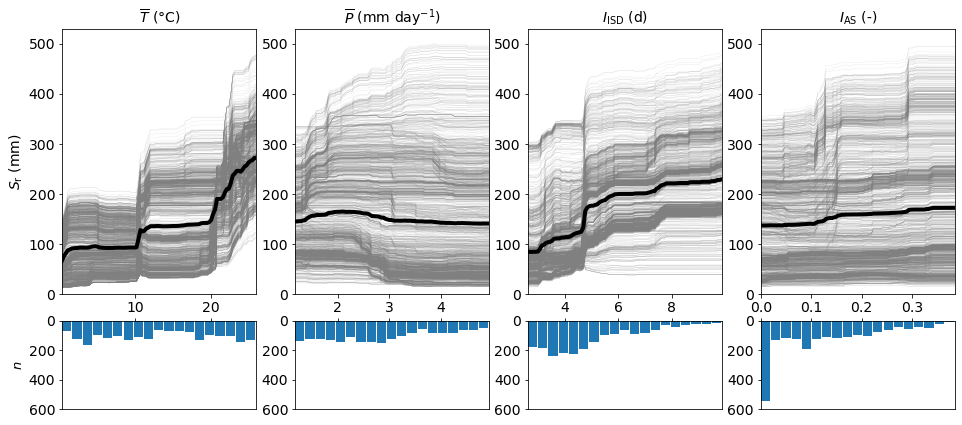

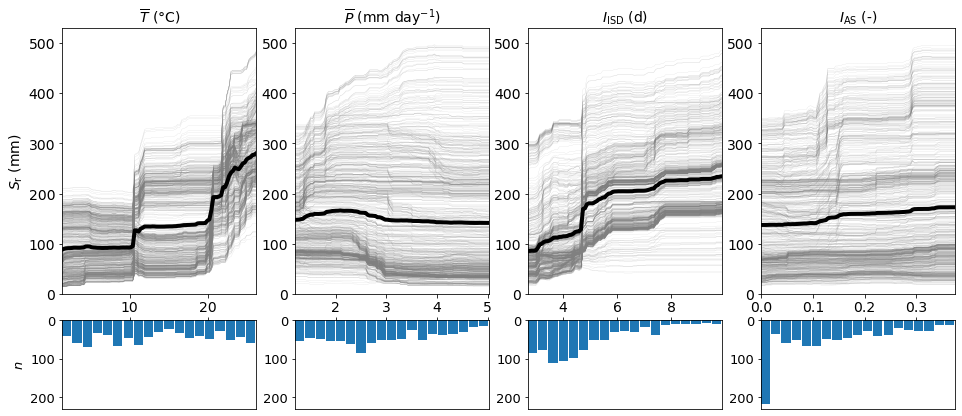

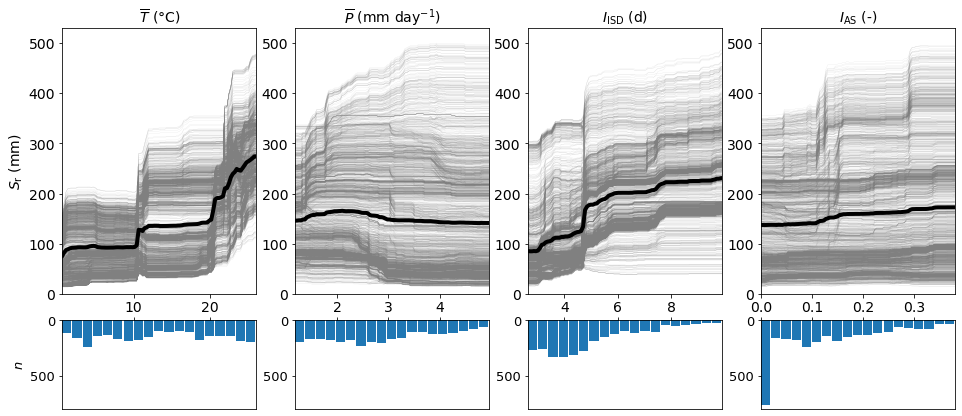

In [199]:
var = ['$\overline{T}$','$\overline{P}$','$I_\mathrm{ISD}$','$I_\mathrm{AS}$']
units = ['$\degree$C','mm $\mathrm{day}^{-1}$','d','-']

# plot pdp TRAIN
fig3, ax = plt.subplots(2,len(features), figsize=(16,7),gridspec_kw={'height_ratios': [3, 1]})
plt.subplots_adjust(hspace=0.15)
for k in range(len(features)):
    a = partial_dependence(rf, features=[k], X=X_train, percentiles=(0.05, 0.95), grid_resolution=100, kind='both')
    pdp = pd.DataFrame(index=['average'],data = a['average'],columns=a['values'][0])
    ice = pd.DataFrame(index=df_train.index, data = a['individual'][0],columns=a['values'][0])
    for i in ice.index:
        ax[0,k].plot(ice.columns.values, ice.loc[i],color='grey',linestyle='-',linewidth=0.07)
    ax[0,k].plot(pdp.columns.values, pdp.loc['average'],color='k',linestyle='-',linewidth=4)
    ax[0,k].set_title(f'{var[k]} ({units[k]})',size=14)
    # ax[0,k].xaxis.set_label_position('top')
    ax[0,0].set_ylabel('$S_\mathrm{r}$ (mm)',size=14)
    ax[0,k].set_ylim(0,530)
    ax[0,k].set_xlim(np.quantile(X_train[:,k],0.05),np.quantile(X_train[:,k],0.95))
    ax[0,k].tick_params(axis='both', labelsize=14)
       
    bins = np.linspace(np.quantile(X_train[:,k],0.05),np.quantile(X_train[:,k],0.95),20)
    ax[1,k].hist(X_train[:,k],bins=bins,width=0.9*(bins[1]-bins[0]))
    ax[1,k].invert_yaxis()
    ax[1,k].xaxis.tick_top()
    ax[1,k].set_xlim(np.quantile(X_train[:,k],0.05),np.quantile(X_train[:,k],0.95))
    ax[1,k].axes.get_xaxis().set_ticklabels([])
    ax[1,0].set_ylabel('$n$',size=13)
    ax[1,k].tick_params(axis='both', labelsize=14)
    ax[1,k].set_ylim(600,0)
fig3.savefig(f'{work_dir}/output/regression/figures/interpretation/pdp_train.jpg',bbox_inches='tight',dpi=300)

    
# plot pdp TEST
fig3, ax = plt.subplots(2,len(features), figsize=(16,7),gridspec_kw={'height_ratios': [3, 1]})
plt.subplots_adjust(hspace=0.15)
for k in range(len(features)):
    a = partial_dependence(rf, features=[k], X=X_test, percentiles=(0.05, 0.95),grid_resolution=100, kind='both')
    pdp = pd.DataFrame(index=['average'],data = a['average'],columns=a['values'][0])
    ice = pd.DataFrame(index=df_test.index, data = a['individual'][0],columns=a['values'][0])

    for i in ice.index:
        ax[0,k].plot(ice.columns.values, ice.loc[i],color='grey',linestyle='-',linewidth=0.07)
    ax[0,k].plot(pdp.columns.values, pdp.loc['average'],color='k',linestyle='-',linewidth=4)
    ax[0,k].set_title(f'{var[k]} ({units[k]})',size=14)
    # ax[0,k].xaxis.set_label_position('top')
    ax[0,0].set_ylabel('$S_\mathrm{r}$ (mm)',size=14)
    ax[0,k].set_ylim(0,530)
    ax[0,k].set_xlim(np.quantile(X_test[:,k],0.05),np.quantile(X_test[:,k],0.95))
    ax[0,k].tick_params(axis='both', labelsize=14)
       
    bins = np.linspace(np.quantile(X_test[:,k],0.05),np.quantile(X_test[:,k],0.95),20)
    ax[1,k].hist(X_test[:,k],bins=bins,width=0.9*(bins[1]-bins[0]))
    ax[1,k].invert_yaxis()
    ax[1,k].xaxis.tick_top()
    ax[1,k].set_xlim(np.quantile(X_test[:,k],0.05),np.quantile(X_test[:,k],0.95))
    ax[1,k].axes.get_xaxis().set_ticklabels([])
    ax[1,0].set_ylabel('$n$',size=13)
    ax[1,k].tick_params(axis='both', labelsize=13)
    ax[1,k].set_ylim(230,0)
fig3.savefig(f'{work_dir}/output/regression/figures/interpretation/pdp_test.jpg',bbox_inches='tight',dpi=300)


# plot pdp TRAIN+TEST
X = np.concatenate([X_train,X_test])
ddf = pd.concat([df_train,df_test])
fig3, ax = plt.subplots(2,len(features), figsize=(16,7),gridspec_kw={'height_ratios': [3, 1]})
plt.subplots_adjust(hspace=0.15)
for k in range(len(features)):
    a = partial_dependence(rf, features=[k], X=X, percentiles=(0.05, 0.95),grid_resolution=100, kind='both')
    pdp = pd.DataFrame(index=['average'],data = a['average'],columns=a['values'][0])
    ice = pd.DataFrame(index=ddf.index, data = a['individual'][0],columns=a['values'][0])

    for i in ice.index:
        ax[0,k].plot(ice.columns.values, ice.loc[i],color='grey',linestyle='-',linewidth=0.05)
    ax[0,k].plot(pdp.columns.values, pdp.loc['average'],color='k',linestyle='-',linewidth=4)
    ax[0,k].set_title(f'{var[k]} ({units[k]})',size=14)
    # ax[0,k].xaxis.set_label_position('top')
    ax[0,0].set_ylabel('$S_\mathrm{r}$ (mm)',size=14)
    ax[0,k].set_ylim(0,530)
    ax[0,k].set_xlim(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95))
    ax[0,k].tick_params(axis='both', labelsize=14)
       
    bins = np.linspace(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95),20)
    ax[1,k].hist(X[:,k],bins=bins,width=0.9*(bins[1]-bins[0]))
    ax[1,k].invert_yaxis()
    ax[1,k].xaxis.tick_top()
    ax[1,k].set_xlim(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95))
    ax[1,k].axes.get_xaxis().set_ticklabels([])
    ax[1,0].set_ylabel('$n$',size=13)
    ax[1,k].tick_params(axis='both', labelsize=13)
    ax[1,k].set_ylim(800,0)
fig3.savefig(f'{work_dir}/output/regression/figures/interpretation/pdp_traintest.jpg',bbox_inches='tight',dpi=300)

## MAKE MANUAL SPLITS

In [240]:
c1 = '#FF1F5B'
c2 = '#009ADE'
c3 = '#AF58BA'
c4 = '#FFC61E'

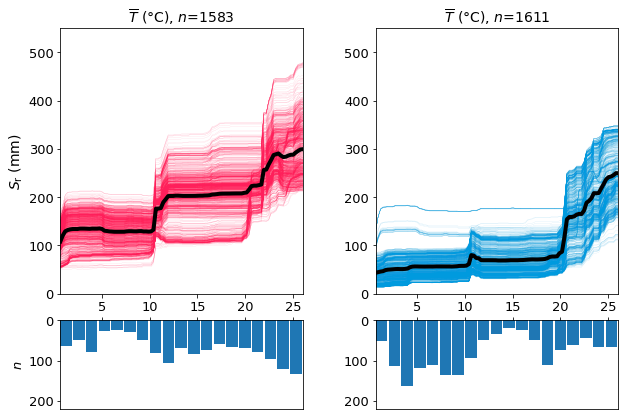

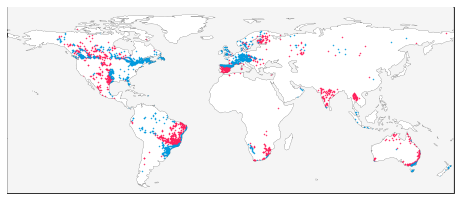

In [259]:
# t_mean
fig, ax = plt.subplots(2,2, figsize=(10,7),gridspec_kw={'height_ratios': [3, 1]})
plt.subplots_adjust(wspace=0.3,hspace=0.15)
k = 0 # 't_mean'
a = partial_dependence(rf, features=[k], X=X, percentiles=(0.05, 0.95),grid_resolution=100, kind='both')
pdp = pd.DataFrame(index=['average'],data = a['average'],columns=a['values'][0])
ice = pd.DataFrame(index=ddf.index, data = a['individual'][0],columns=a['values'][0])

# define groups
pos = []
neg = []
slp = (ice.iloc[:,-1] - ice.iloc[:,0])/(ice.columns[-1] - ice.columns[0])
for i in ice.index:
    if (slp.loc[i]>0):
        pos.append(i)
    if (slp.loc[i]<0):
        neg.append(i)

pm = slp.loc[pos].mean()
gr1 = slp[slp>pm].index
gr2 = slp[(slp<=pm) & (slp>0)].index
gr1=[]
gr2=[]
for i in pos:
    if ((ice.loc[i].iloc[50] - ice.loc[i].iloc[0])/(ice.columns[50] - ice.columns[0]) > 3.7): # (ice.loc[i].iloc[50] - ice.loc[i].iloc[0])/(ice.columns[50] - ice.columns[0])): # 
        gr1.append(i)
    else:
        gr2.append(i)

# plot pdps
cmap_rdbu = cm.get_cmap('PuOr_r', 4)
if (len(gr1)>0):
    gr = gr1
    j = 0
    for i in gr:
        ax[0,j].plot(ice.columns.values, ice.loc[i],color=c1,linestyle='-',linewidth=0.05)
    ax[0,j].plot(ice.columns.values, ice.loc[gr].mean(),color='k',linestyle='-',linewidth=4)
    ax[0,j].set_title(f'{var[k]} ({units[k]}), $n$={len(gr)}',size=14)
    ax[0,0].set_ylabel('$S_\mathrm{r}$ (mm)',size=14)
    ax[0,j].set_ylim(0,550)
    ax[0,j].set_xlim(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95))
    ax[0,j].tick_params(axis='both', labelsize=13)
       
    bins = np.linspace(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95),20)
    ax[1,j].hist(df.loc[gr,features[k]],bins=bins,width=0.9*(bins[1]-bins[0]))
    ax[1,j].invert_yaxis()
    ax[1,j].xaxis.tick_top()
    ax[1,j].set_xlim(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95))
    ax[1,j].axes.get_xaxis().set_ticklabels([])
    ax[1,j].set_ylabel('$n$',size=13)
    ax[1,j].tick_params(axis='both', labelsize=13)
    ax[1,j].set_ylim(220,0)
    
if (len(gr2)>0):
    gr = gr2
    j = 1
    for i in gr:
        ax[0,j].plot(ice.columns.values, ice.loc[i],color=c2,linestyle='-',linewidth=0.05)
    ax[0,j].plot(ice.columns.values, ice.loc[gr].mean(),color='k',linestyle='-',linewidth=4)
    ax[0,j].set_title(f'{var[k]} ({units[k]}), $n$={len(gr)}',size=14)
    # ax[0,j].set_ylabel('Sr (mm)',size=13)
    ax[0,j].set_ylim(0,550)
    ax[0,j].set_xlim(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95))
    ax[0,j].tick_params(axis='both', labelsize=13)
       
    bins = np.linspace(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95),20)
    ax[1,j].hist(df.loc[gr,features[k]],bins=bins,width=0.9*(bins[1]-bins[0]))
    ax[1,j].invert_yaxis()
    ax[1,j].xaxis.tick_top()
    ax[1,j].set_xlim(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95))
    ax[1,j].axes.get_xaxis().set_ticklabels([])
    # ax[1,j].set_ylabel('$n$',size=13)
    ax[1,j].tick_params(axis='both', labelsize=13)
    ax[1,j].set_ylim(220,0)
    
fig.savefig(f'{work_dir}/output/regression/figures/interpretation/pdp_train_{features[k]}_manualsplit.jpg',bbox_inches='tight',dpi=300)

# plot map
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
ddf = df.loc[ice.index]
ax.plot(ddf.loc[gr1].lon, ddf.loc[gr1].lat,'o', markeredgecolor=c1, markerfacecolor=c1,markersize=0.5)
ax.plot(ddf.loc[gr2].lon, ddf.loc[gr2].lat,'o', markeredgecolor=c2, markerfacecolor=c2,markersize=0.5)
# ax.set_title(f'{features[k]}')

fig.savefig(f'{work_dir}/output/regression/figures/interpretation/pdp_train_{features[k]}_manualsplit_map.jpg',bbox_inches='tight',dpi=300)


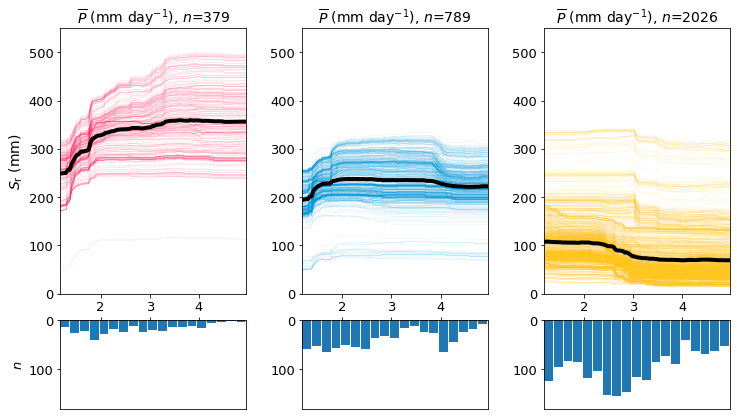

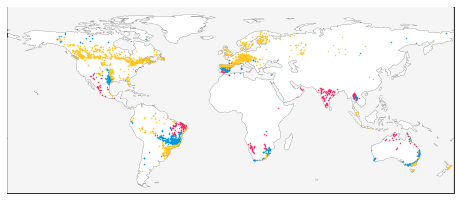

In [260]:
# p_mean
fig, ax = plt.subplots(2,3, figsize=(12,7),gridspec_kw={'height_ratios': [3, 1]})
plt.subplots_adjust(wspace=0.3,hspace=0.15)
k = 1 # 'p_mean'
a = partial_dependence(rf, features=[k], X=X, percentiles=(0.05, 0.95),grid_resolution=100, kind='both')
pdp = pd.DataFrame(index=['average'],data = a['average'],columns=a['values'][0])
ice = pd.DataFrame(index=ddf.index, data = a['individual'][0],columns=a['values'][0])

# define groups
pos = []
neg = []
slp = (ice.iloc[:,-1] - ice.iloc[:,0])/(ice.columns[-1] - ice.columns[0])
for i in ice.index:
    if (slp.loc[i]>0):
        pos.append(i)
    if (slp.loc[i]<0):
        neg.append(i)

pm = slp.loc[pos].mean()
nm = slp.loc[neg].mean()
gr1 = slp[slp>pm].index
gr2 = slp[(slp<=pm) & (slp>0)].index
gr3 = slp[(slp>=0.8*nm) & (slp<0)].index
gr4 = slp[slp<0.8*nm].index

p = np.concatenate([gr2,gr3])
gr2=[]
gr3=[]
for i in p:
    # if (((ice.loc[i].iloc[40] - ice.loc[i].iloc[0])/(ice.columns[40] - ice.columns[0]) > 0) & ((ice.loc[i].iloc[99] - ice.loc[i].iloc[70])/(ice.columns[99] - ice.columns[70]) < 0)): # (ice.loc[i].iloc[50] - ice.loc[i].iloc[0])/(ice.columns[50] - ice.columns[0]))
    if (((ice.loc[i].iloc[23] - ice.loc[i].iloc[0])/(ice.columns[23] - ice.columns[0]) > 20)): # (ice.loc[i].iloc[50] - ice.loc[i].iloc[0])/(ice.columns[50] - ice.columns[0]))
        gr2.append(i)
    else:
        gr3.append(i)
# gr1=[]
# gr2=[]
# for i in pos:
#     if ((ice.loc[i].iloc[50] - ice.loc[i].iloc[0])/(ice.columns[50] - ice.columns[0]) > 4): # (ice.loc[i].iloc[50] - ice.loc[i].iloc[0])/(ice.columns[50] - ice.columns[0])): # 
#         gr1.append(i)
#     else:
#         gr2.append(i)

gr3 = np.concatenate([gr3,gr4])

# plot pdps
cmap_rdbu = cm.get_cmap('coolwarm_r', 4)
if (len(gr1)>0):
    gr = gr1
    j = 0
    for i in gr:
        ax[0,j].plot(ice.columns.values, ice.loc[i],color=c1,linestyle='-',linewidth=0.05)
    ax[0,j].plot(ice.columns.values, ice.loc[gr].mean(),color='k',linestyle='-',linewidth=4)
    ax[0,j].set_title(f'{var[k]} ({units[k]}), $n$={len(gr)}',size=14)
    ax[0,0].set_ylabel('$S_\mathrm{r}$ (mm)',size=14)
    ax[0,j].set_ylim(0,550)
    ax[0,j].set_xlim(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95))
    ax[0,j].tick_params(axis='both', labelsize=13)
       
    # bins = np.linspace(np.quantile(df.loc[gr,features[k]],0.05),np.quantile(df.loc[gr,features[k]],0.95),20)
    bins = np.linspace(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95),20)
    ax[1,j].hist(df.loc[gr,features[k]],bins=bins,width=0.9*(bins[1]-bins[0]))
    ax[1,j].invert_yaxis()
    ax[1,j].xaxis.tick_top()
    ax[1,j].set_xlim(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95))
    ax[1,j].axes.get_xaxis().set_ticklabels([])
    ax[1,j].set_ylabel('$n$',size=13)
    ax[1,j].tick_params(axis='both', labelsize=13)
    ax[1,j].set_ylim(180,0)
if (len(gr2)>0):
    gr = gr2
    j = 1
    for i in gr:
        ax[0,j].plot(ice.columns.values, ice.loc[i],color=c2,linestyle='-',linewidth=0.05)
    ax[0,j].plot(ice.columns.values, ice.loc[gr].mean(),color='k',linestyle='-',linewidth=4)
    ax[0,j].set_title(f'{var[k]} ({units[k]}), $n$={len(gr)}',size=14)
    # ax[0,j].set_ylabel('Sr (mm)',size=13)
    ax[0,j].set_ylim(0,550)
    ax[0,j].set_xlim(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95))
    ax[0,j].tick_params(axis='both', labelsize=13)
       
    bins = np.linspace(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95),20)
    ax[1,j].hist(df.loc[gr,features[k]],bins=bins,width=0.9*(bins[1]-bins[0]))
    ax[1,j].invert_yaxis()
    ax[1,j].xaxis.tick_top()
    ax[1,j].set_xlim(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95))
    ax[1,j].axes.get_xaxis().set_ticklabels([])
    # ax[1,j].set_ylabel('n',size=13)
    ax[1,j].tick_params(axis='both', labelsize=13)
    ax[1,j].set_ylim(180,0)
if (len(gr3)>0):
    gr = gr3
    j = 2
    for i in gr:
        ax[0,j].plot(ice.columns.values, ice.loc[i],color=c4,linestyle='-',linewidth=0.05)
    ax[0,j].plot(ice.columns.values, ice.loc[gr].mean(),color='k',linestyle='-',linewidth=4)
    ax[0,j].set_title(f'{var[k]} ({units[k]}), $n$={len(gr)}',size=14)
    # ax[0,j].set_ylabel('Sr (mm)',size=13)
    ax[0,j].set_ylim(0,550)
    ax[0,j].set_xlim(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95))
    ax[0,j].tick_params(axis='both', labelsize=13)
       
    bins = np.linspace(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95),20)
    ax[1,j].hist(df.loc[gr,features[k]],bins=bins,width=0.9*(bins[1]-bins[0]))
    ax[1,j].invert_yaxis()
    ax[1,j].xaxis.tick_top()
    ax[1,j].set_xlim(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95))
    ax[1,j].axes.get_xaxis().set_ticklabels([])
    # ax[1,j].set_ylabel('n',size=13)
    ax[1,j].tick_params(axis='both', labelsize=13)
    ax[1,j].set_ylim(180,0)
# if (len(gr4)>0):
#     gr = gr4
#     j = 3
#     for i in gr:
#         ax[0,j].plot(ice.columns.values, ice.loc[i],color=c4,linestyle='-',linewidth=0.05)
#     ax[0,j].plot(ice.columns.values, ice.loc[gr].mean(),color='k',linestyle='-',linewidth=4)
#     ax[0,j].set_title(f'{var[k]} ({units[k]}), $n$={len(gr)}',size=14)
#     # ax[0,j].set_ylabel('Sr (mm)',size=13)
#     ax[0,j].set_ylim(0,600)
#     ax[0,j].set_xlim(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95))
#     ax[0,j].tick_params(axis='both', labelsize=13)
       
#     bins = np.linspace(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95),20)
#     ax[1,j].hist(df.loc[gr,features[k]],bins=bins,width=0.9*(bins[1]-bins[0]))
#     ax[1,j].invert_yaxis()
#     ax[1,j].xaxis.tick_top()
#     ax[1,j].set_xlim(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95))
#     ax[1,j].axes.get_xaxis().set_ticklabels([])
#     # ax[1,j].set_ylabel('n',size=13)
#     ax[1,j].tick_params(axis='both', labelsize=13)
#     ax[1,j].set_ylim(150,0)
    
fig.savefig(f'{work_dir}/output/regression/figures/interpretation/pdp_train_{features[k]}_manualsplit.jpg',bbox_inches='tight',dpi=300)

# plot map
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
ddf = df.loc[ice.index]
ax.plot(ddf.loc[gr1].lon, ddf.loc[gr1].lat,'o', markeredgecolor=c1, markerfacecolor=c1,markersize=0.5)
ax.plot(ddf.loc[gr2].lon, ddf.loc[gr2].lat,'o', markeredgecolor=c2, markerfacecolor=c2,markersize=0.5)
ax.plot(ddf.loc[gr3].lon, ddf.loc[gr3].lat,'o', markeredgecolor=c4, markerfacecolor=c4,markersize=0.5)
# ax.plot(ddf.loc[gr4].lon, ddf.loc[gr4].lat,'o', markeredgecolor=c4, markerfacecolor=c4,markersize=0.5)
# ax.set_title(f'{features[k]}')

fig.savefig(f'{work_dir}/output/regression/figures/interpretation/pdp_train_{features[k]}_manualsplit_map.jpg',bbox_inches='tight',dpi=300)





In [256]:
ice.iloc[:,15:25]

1.756352    1.794628    1.832904    1.871180    1.909456  \
br_0002809  241.968446  247.814511  248.946228  250.167582  251.196528   
br_0000534  317.072147  333.735664  343.529307  344.330420  344.330420   
es_0000573  303.143916  309.621110  310.831424  316.929744  325.076961   
es_0000488  247.178768  256.925995  258.599915  260.050242  265.971270   
ca_0004451   81.108762   81.108762   80.696650   80.696650   80.696650   
...                ...         ...         ...         ...         ...   
116006B     260.093746  271.280330  275.653890  277.264215  277.899820   
405209      112.862406  112.862406  112.525456  112.525456  112.525456   
us_0001002  110.757351  110.757351  110.420401  110.420401  110.420401   
fr_0001288  128.911215  129.179316  128.842366  128.842366  128.842366   
ca_0000377   70.309049   70.309049   69.604419   69.604419   69.604419   

              1.947731    1.986007    2.024283    2.062559    2.100835  
br_0002809  251.196528  251.196528  251.478065  251.478065  251.478065  
br_0000534  345.583001  346.502952  347.212374  349.344063  352.682673  
es_0000573  326.985587  328.079811  328.079811  328.079811  328.079811  
es_0000488  269.034018  270.128242  271.887296  271.887296  272.653516  
ca_0004451   81.309527   81.034526   81.034526   81.034526   81.034526  
...                ...         ...         ...         ...         ...  
116006B     279.074443  279.994394  281.782913  282.895487  284.357630  
405209      114.519560  114.519560  114.519560  114.519560  114.519560  
us_0001002  112.765304  112.765304  112.765304  112.765304  112.765304  
fr_0001288  130.836470  130.836470  130.836470  130.836470  130.836470  
ca_0000377   70.217296   70.582802   70.582802   70.582802   70.582802  

[3194 rows x 10 columns]

In [244]:
# f = f'{work_dir}/output/catchment_characteristics/master_characteristics_gswp-p_gleam-ep_gswp-t.csv'
# df = pd.read_csv(f,index_col=0)
# ff = features
# ff.append('sr_20')
# df = df[ff]
# df = df.loc[df_train.index]
# df.loc[gr1,'gr'] = 0
# df.loc[gr2,'gr'] = 1
# df.loc[gr3,'gr'] = 2
# df.loc[gr4,'gr'] = 3

# X = df[features]
# X = X.dropna()
# X = StandardScaler().fit_transform(X) #standardize all values
# X = pd.DataFrame(X,columns=ff)
# pca = PCA(n_components=len(ff))
# components = pca.fit_transform(X)
# loadings = pca.components_ #eigenvector, length represents variance var explains
 
# # Create dataframe
# pca_df = pd.DataFrame(data=components[:,0:2],columns=['PC1', 'PC2'])
# pca_df_scaled = pca_df.copy()
#  scaler_df = pca_df[['PC1', 'PC2']]
# scaler = 1 / (scaler_df.max() - scaler_df.min()) # WAAROM DIT?
 
# for index in scaler.index:
#     pca_df_scaled[index] *= scaler[index]

# per_var  = np.round(pca.explained_variance_ratio_ * 100, decimals=1)

# xs = loadings[0]
# ys = loadings[1]
# ld_df = pd.DataFrame(index=ff, columns=['xs','ys'])
# ld_df['xs'] = loadings[0]
# ld_df['ys'] = loadings[1]
# ld_df['len'] = np.sqrt(loadings[0]**2+loadings[1]**2)

# fig=plt.figure(figsize=(6,6))
# ax = fig.add_subplot(111)
# ax.scatter(pca_df_scaled.PC1,pca_df_scaled.PC2,s=1,alpha=0.5,c=df.gr,cmap=cmap_rdbu)
# for i, varnames in enumerate(ff):
#     ax.arrow(
#         0, 0, # coordinates of arrow base
#         ld_df.loc[ff[i]]['xs'], # length of the arrow along x
#         ld_df.loc[ff[i]]['ys'], # length of the arrow along y
#         color='r',
#         head_width=0.02
#         )
#     ax.text(ld_df.loc[ff[i]]['xs']+0.02, ld_df.loc[ff[i]]['ys']+0.02, varnames,size=10)
# xticks = np.linspace(-0.5,0.7, num=5)
# yticks = np.linspace(-0.3,0.8, num=5)
# ax.set_xticks(xticks)
# ax.set_yticks(yticks)
# ax.tick_params(axis='both', which='major', labelsize=12)
# ax.set_xlabel(f'PC1 {per_var[0]}%',size=14)
# ax.set_ylabel(f'PC2 {per_var[1]}%',size=14)

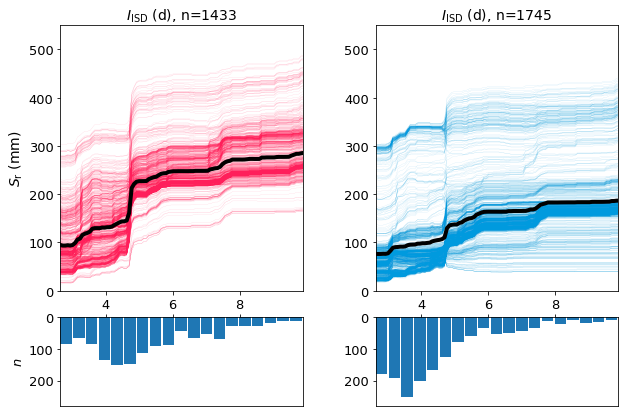

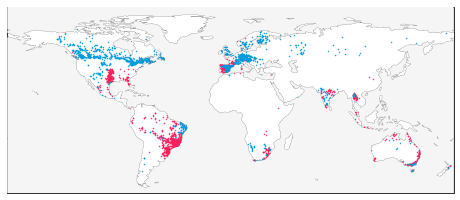

In [261]:
# idu_mean
fig, ax = plt.subplots(2,2, figsize=(10,7),gridspec_kw={'height_ratios': [3, 1]})
plt.subplots_adjust(wspace=0.3,hspace=0.15)
k = 2 # 'idu_mean'
a = partial_dependence(rf, features=[k], X=X, percentiles=(0.05, 0.95),grid_resolution=100, kind='both')
pdp = pd.DataFrame(index=['average'],data = a['average'],columns=a['values'][0])
ice = pd.DataFrame(index=ddf.index, data = a['individual'][0],columns=a['values'][0])

# define groups
pos = []
neg = []
slp = (ice.iloc[:,-1] - ice.iloc[:,0])/(ice.columns[-1] - ice.columns[0])
for i in ice.index:
    if (slp.loc[i]>0):
        pos.append(i)
    if (slp.loc[i]<0):
        neg.append(i)

pm = slp.loc[pos].mean()
gr1 = slp[slp>1*pm].index
gr2 = slp[(slp<=1*pm) & (slp>0)].index
# gr1=[]
# gr2=[]
# for i in pos:
#     if ((ice.loc[i].iloc[50] - ice.loc[i].iloc[0])/(ice.columns[50] - ice.columns[0]) > 4): # (ice.loc[i].iloc[50] - ice.loc[i].iloc[0])/(ice.columns[50] - ice.columns[0])): # 
#         gr1.append(i)
#     else:
#         gr2.append(i)

# plot pdps
cmap_rdbu = cm.get_cmap('coolwarm_r', 4)
if (len(gr1)>0):
    gr = gr1
    j = 0
    for i in gr:
        ax[0,j].plot(ice.columns.values, ice.loc[i],color=c1,linestyle='-',linewidth=0.05)
    ax[0,j].plot(ice.columns.values, ice.loc[gr].mean(),color='k',linestyle='-',linewidth=4)
    ax[0,j].set_title(f'{var[k]} ({units[k]}), n={len(gr)}',size=14)
    ax[0,j].set_ylabel('$S_\mathrm{r}$ (mm)',size=14)
    ax[0,j].set_ylim(0,550)
    ax[0,j].set_xlim(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95))
    ax[0,j].tick_params(axis='both', labelsize=13)
       
    bins = np.linspace(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95),20)
    ax[1,j].hist(df.loc[gr,features[k]],bins=bins,width=0.9*(bins[1]-bins[0]))
    ax[1,j].invert_yaxis()
    ax[1,j].xaxis.tick_top()
    ax[1,j].set_xlim(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95))
    ax[1,j].axes.get_xaxis().set_ticklabels([])
    ax[1,j].set_ylabel('$n$',size=13)
    ax[1,j].tick_params(axis='both', labelsize=13)
    ax[1,j].set_ylim(280,0)
    
if (len(gr2)>0):
    gr = gr2
    j = 1
    for i in gr:
        ax[0,j].plot(ice.columns.values, ice.loc[i],color=c2,linestyle='-',linewidth=0.05)
    ax[0,j].plot(ice.columns.values, ice.loc[gr].mean(),color='k',linestyle='-',linewidth=4)
    ax[0,j].set_title(f'{var[k]} ({units[k]}), n={len(gr)}',size=14)
    # ax[0,j].set_ylabel('Sr (mm)',size=13)
    ax[0,j].set_ylim(0,550)
    ax[0,j].set_xlim(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95))
    ax[0,j].tick_params(axis='both', labelsize=13)
       
    bins = np.linspace(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95),20)
    ax[1,j].hist(df.loc[gr,features[k]],bins=bins,width=0.9*(bins[1]-bins[0]))
    ax[1,j].invert_yaxis()
    ax[1,j].xaxis.tick_top()
    ax[1,j].set_xlim(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95))
    ax[1,j].axes.get_xaxis().set_ticklabels([])
    # ax[1,j].set_ylabel('n',size=13)
    ax[1,j].tick_params(axis='both', labelsize=13)
    ax[1,j].set_ylim(280,0)
    
fig.savefig(f'{work_dir}/output/regression/figures/interpretation/pdp_train_{features[k]}_manualsplit.jpg',bbox_inches='tight',dpi=300)

# plot map
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
ddf = df.loc[ice.index]
ax.plot(ddf.loc[gr1].lon, ddf.loc[gr1].lat,'o', markeredgecolor=c1, markerfacecolor=c1,markersize=0.5)
ax.plot(ddf.loc[gr2].lon, ddf.loc[gr2].lat,'o', markeredgecolor=c2, markerfacecolor=c2,markersize=0.5)
# ax.set_title(f'{features[k]}')

fig.savefig(f'{work_dir}/output/regression/figures/interpretation/pdp_train_{features[k]}_manualsplit_map.jpg',bbox_inches='tight',dpi=300)

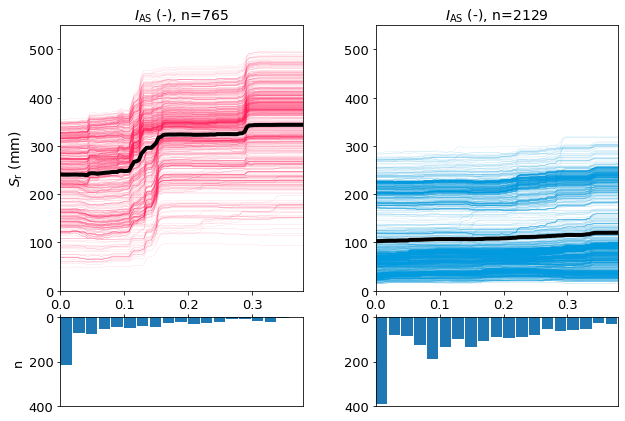

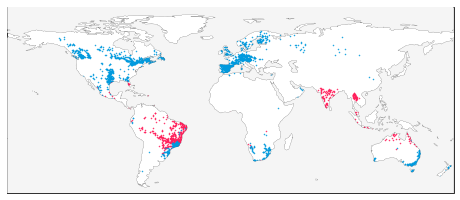

In [262]:
# asi
fig, ax = plt.subplots(2,2, figsize=(10,7),gridspec_kw={'height_ratios': [3, 1]})
plt.subplots_adjust(wspace=0.3,hspace=0.15)
k = 3 # asi
a = partial_dependence(rf, features=[k], X=X, percentiles=(0.05, 0.95),grid_resolution=100, kind='both')
pdp = pd.DataFrame(index=['average'],data = a['average'],columns=a['values'][0])
ice = pd.DataFrame(index=ddf.index, data = a['individual'][0],columns=a['values'][0])

# define groups
pos = []
neg = []
slp = (ice.iloc[:,-1] - ice.iloc[:,0])/(ice.columns[-1] - ice.columns[0])
for i in ice.index:
    if (slp.loc[i]>0):
        pos.append(i)
    if (slp.loc[i]<0):
        neg.append(i)

pm = slp.loc[pos].mean()
gr1 = slp[slp>pm].index
gr2 = slp[(slp<=pm) & (slp>0)].index

# plot pdps
cmap_rdbu = cm.get_cmap('coolwarm_r', 4)
if (len(gr1)>0):
    gr = gr1
    j = 0
    for i in gr:
        ax[0,j].plot(ice.columns.values, ice.loc[i],color=c1,linestyle='-',linewidth=0.07)
    ax[0,j].plot(ice.columns.values, ice.loc[gr].mean(),color='k',linestyle='-',linewidth=4)
    ax[0,j].set_title(f'{var[k]} ({units[k]}), n={len(gr)}',size=14)
    ax[0,j].set_ylabel('$S_\mathrm{r}$ (mm)',size=14)
    ax[0,j].set_ylim(0,550)
    ax[0,j].set_xlim(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95))
    ax[0,j].tick_params(axis='both', labelsize=13)
       
    bins = np.linspace(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95),20)
    ax[1,j].hist(df.loc[gr,features[k]],bins=bins,width=0.9*(bins[1]-bins[0]))
    ax[1,j].invert_yaxis()
    ax[1,j].xaxis.tick_top()
    ax[1,j].set_xlim(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95))
    ax[1,j].axes.get_xaxis().set_ticklabels([])
    ax[1,j].set_ylabel('n',size=13)
    ax[1,j].tick_params(axis='both', labelsize=13)
    ax[1,j].set_ylim(400,0)
    
if (len(gr2)>0):
    gr = gr2
    j = 1
    for i in gr:
        ax[0,j].plot(ice.columns.values, ice.loc[i],color=c2,linestyle='-',linewidth=0.07)
    ax[0,j].plot(ice.columns.values, ice.loc[gr].mean(),color='k',linestyle='-',linewidth=4)
    ax[0,j].set_title(f'{var[k]} ({units[k]}), n={len(gr)}',size=14)
    # ax[0,j].set_ylabel('Sr (mm)',size=13)
    ax[0,j].set_ylim(0,550)
    ax[0,j].set_xlim(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95))
    ax[0,j].tick_params(axis='both', labelsize=13)
       
    bins = np.linspace(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95),20)
    ax[1,j].hist(df.loc[gr,features[k]],bins=bins,width=0.9*(bins[1]-bins[0]))
    ax[1,j].invert_yaxis()
    ax[1,j].xaxis.tick_top()
    ax[1,j].set_xlim(np.quantile(X[:,k],0.05),np.quantile(X[:,k],0.95))
    ax[1,j].axes.get_xaxis().set_ticklabels([])
    # ax[1,j].set_ylabel('n',size=13)
    ax[1,j].tick_params(axis='both', labelsize=13)
    ax[1,j].set_ylim(400,0)
    
fig.savefig(f'{work_dir}/output/regression/figures/interpretation/pdp_train_{features[k]}_manualsplit.jpg',bbox_inches='tight',dpi=300)

# plot map
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
ddf = df.loc[ice.index]
ax.plot(ddf.loc[gr1].lon, ddf.loc[gr1].lat,'o', markeredgecolor=c1, markerfacecolor=c1,markersize=0.5)
ax.plot(ddf.loc[gr2].lon, ddf.loc[gr2].lat,'o', markeredgecolor=c2, markerfacecolor=c2,markersize=0.5)
# ax.set_title(f'{features[k]}')

fig.savefig(f'{work_dir}/output/regression/figures/interpretation/pdp_train_{features[k]}_manualsplit_map.jpg',bbox_inches='tight',dpi=300)

Text(0.5, 1.0, '')

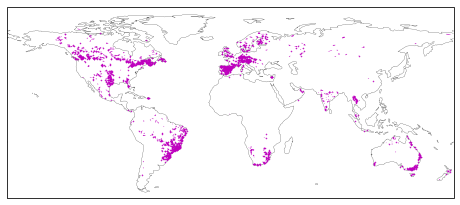

In [106]:
# plot shapes instead of points
sh = gpd.read_file(f'{work_dir}/output/geo_catchments.shp')
sh.index = sh.catch_id
sh = sh.loc[df_train.index]

area = pd.read_csv(f'{work_dir}/output/catchment_area.csv',index_col=0)
area = area.loc[df_train.index]
ixp = area[area.area<1500].index
ixs = area[area.area>1500].index
shp = sh.loc[ixs]
p = df_train.loc[ixp]

fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.2)
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
sh.plot(edgecolor=None,facecolor='m',linewidth=0.05,ax=ax)
ax.plot(p.lon,p.lat,'o', markeredgecolor='m', markerfacecolor='m',markersize=0.5)
ax.set_title(f'',size=20)

## COMPARISON LAN STOCKER

### STOCKER SR

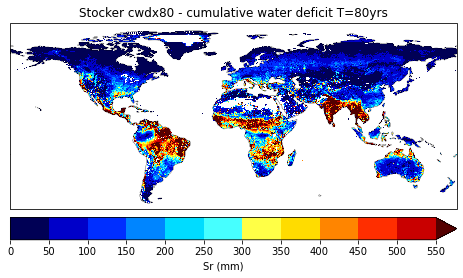

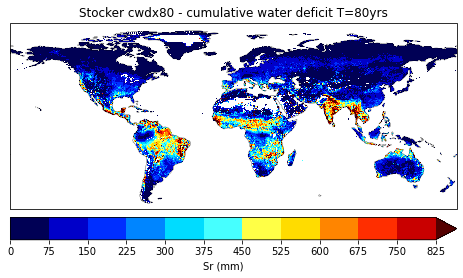

In [88]:
s = xr.open_dataset(f'{work_dir}/data/reference_sr/stocker/cwdx80.nc')
s = s.cwdx80

lvls = np.arange(0,600,50) # scale W-E paper
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
cf = s.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=10, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal', label='Sr (mm)', pad=0.02, ticks = lvls)
ax.set_title(f'Stocker cwdx80 - cumulative water deficit T=80yrs')
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_stocker_cwdx80.jpg',bbox_inches='tight',dpi=300)

lvls = np.arange(0,900,75) # scale W-E paper
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
cf = s.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=10, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal', label='Sr (mm)', pad=0.02, ticks = lvls)
ax.set_title(f'Stocker cwdx80 - cumulative water deficit T=80yrs')
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_stocker_cwdx80_v2.jpg',bbox_inches='tight',dpi=300)

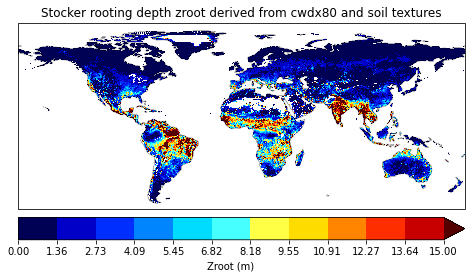

In [89]:
sd = xr.open_dataset(f'{work_dir}/data/reference_sr/stocker/zroot_cwd80.nc')
sd = sd.zroot_cwd80/1000 #convert to meters

lvls = np.linspace(0,15,12) # scale W-E paper
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
cf = sd.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=10, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal', label='Zroot (m)', pad=0.02, ticks = lvls)
ax.set_title(f'Stocker rooting depth zroot derived from cwdx80 and soil textures')
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_stocker_zroot_cwd80.jpg',bbox_inches='tight',dpi=300)

### LAN SR

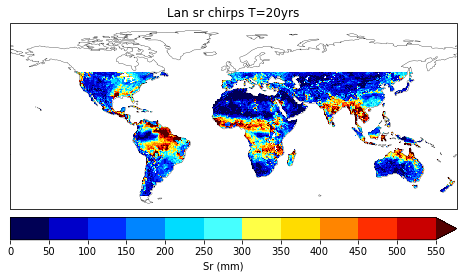

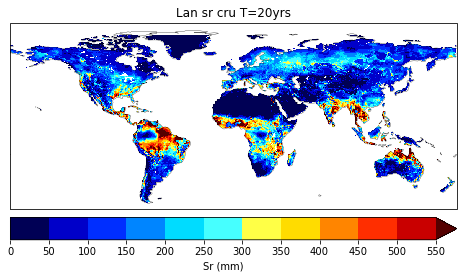

In [90]:
l = xr.open_dataset(f'{work_dir}/data/reference_sr/lan/sr_chirps_20yrs.nc')
l = l.sr_chirps_20yrs[0]

lvls = np.arange(0,600,50) # scale W-E paper
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
cf = l.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=10, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal', label='Sr (mm)', pad=0.02, ticks = lvls)
ax.set_title(f'Lan sr chirps T=20yrs')
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_lan_chirps_20yrs.jpg',bbox_inches='tight',dpi=300)

l = xr.open_dataset(f'{work_dir}/data/reference_sr/lan/sr_cru_20yrs.nc')
l = l.sr_cru_20yrs[0]

lvls = np.arange(0,600,50) # scale W-E paper
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
cf = l.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=10, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal', label='Sr (mm)', pad=0.02, ticks = lvls)
ax.set_title(f'Lan sr cru T=20yrs')
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_lan_cru_20yrs.jpg',bbox_inches='tight',dpi=300)


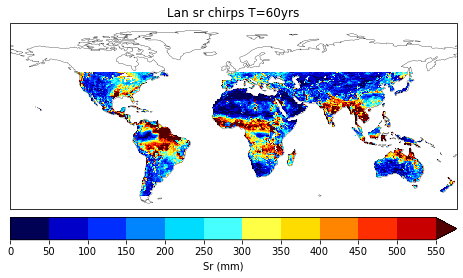

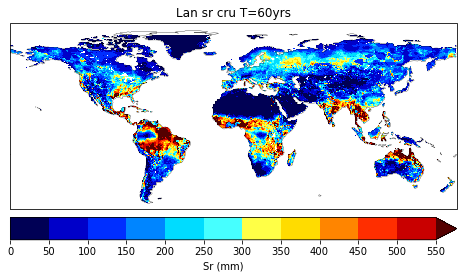

In [91]:
l = xr.open_dataset(f'{work_dir}/data/reference_sr/lan/sr_chirps_60yrs.nc')
l = l.sr_chirps_60yrs[0]

lvls = np.arange(0,600,50) # scale W-E paper
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
cf = l.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=10, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal', label='Sr (mm)', pad=0.02, ticks = lvls)
ax.set_title(f'Lan sr chirps T=60yrs')
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_lan_chirps_60yrs.jpg',bbox_inches='tight',dpi=300)


l = xr.open_dataset(f'{work_dir}/data/reference_sr/lan/sr_cru_60yrs.nc')
l = l.sr_cru_60yrs[0]

lvls = np.arange(0,600,50) # scale W-E paper
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
cf = l.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=10, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal', label='Sr (mm)', pad=0.02, ticks = lvls)
ax.set_title(f'Lan sr cru T=60yrs')
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_lan_cru_60yrs.jpg',bbox_inches='tight',dpi=300)


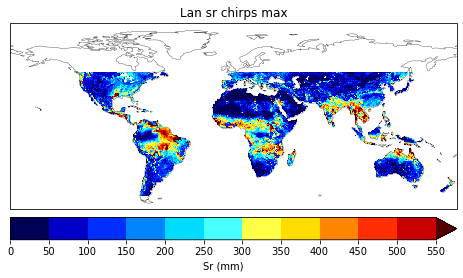

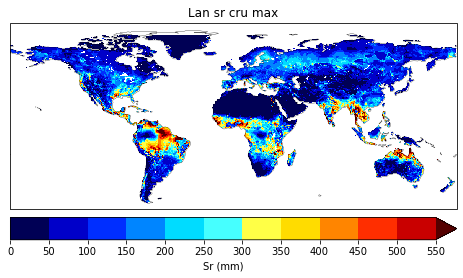

In [92]:
l = xr.open_dataset(f'{work_dir}/data/reference_sr/lan/sr_chirps_max.nc')
l = l.sr_chirps_max[0]

lvls = np.arange(0,600,50) # scale W-E paper
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
cf = l.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=10, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal', label='Sr (mm)', pad=0.02, ticks = lvls)
ax.set_title(f'Lan sr chirps max')
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_lan_chirps_max.jpg',bbox_inches='tight',dpi=300)


l = xr.open_dataset(f'{work_dir}/data/reference_sr/lan/sr_cru_max.nc')
l = l.sr_cru_max[0]

lvls = np.arange(0,600,50) # scale W-E paper
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
cf = l.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=10, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal', label='Sr (mm)', pad=0.02, ticks = lvls)
ax.set_title(f'Lan sr cru max')
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_lan_cru_max.jpg',bbox_inches='tight',dpi=300)


### SR COMPARISON

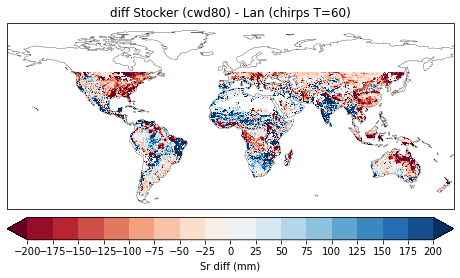

In [93]:
# diff lan-stocker
s = xr.open_dataset(f'{work_dir}/data/reference_sr/stocker/cwdx80_05grid.nc')
s = s.cwdx80

l = xr.open_dataset(f'{work_dir}/data/reference_sr/lan/sr_chirps_60yrs.nc')
l = l.sr_chirps_60yrs[0]

d = s-l

lvls = np.linspace(-200,200,17) # scale W-E paper
cmapb = mpl.cm.RdBu
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
cf = d.plot(ax=ax, cmap=cmapb, add_colorbar=False, vmin=0, vmax=10, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal', label='Sr diff (mm)', pad=0.02, ticks = lvls)
ax.set_title(f'diff Stocker (cwd80) - Lan (chirps T=60)')
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_diff_lan_chirps_60yrs_stocker_cwd80.jpg',bbox_inches='tight',dpi=300)


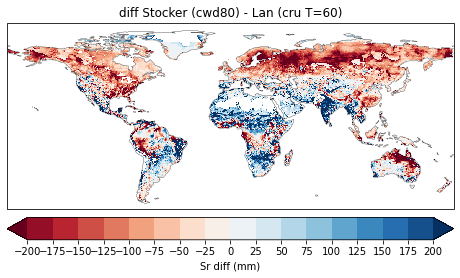

In [94]:
# diff lan-stocker
s = xr.open_dataset(f'{work_dir}/data/reference_sr/stocker/cwdx80_cru_grid.nc')
s = s.cwdx80

l = xr.open_dataset(f'{work_dir}/data/reference_sr/lan/sr_cru_60yrs.nc')
l = l.sr_cru_60yrs[0]

d = s-l

lvls = np.linspace(-200,200,17) # scale W-E paper
cmapb = mpl.cm.RdBu
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
cf = d.plot(ax=ax, cmap=cmapb, add_colorbar=False, vmin=0, vmax=10, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal', label='Sr diff (mm)', pad=0.02, ticks = lvls)
ax.set_title(f'diff Stocker (cwd80) - Lan (cru T=60)')
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_diff_lan_cru_60yrs_stocker_cwd80.jpg',bbox_inches='tight',dpi=300)


### COMPARE LAN STOCKER TO MY SR ESTIMATES

In [95]:
#shapes
sh = gpd.read_file(f'{work_dir}/output/geo_catchments_sel_area_wb.shp')
sh.index = sh.catch_id
sh['centroid'] = sh.centroid

# sr dataframe
sr_df = pd.read_csv(f'{work_dir}/output/sr_calculation/sr_all_catchments_maxmin_rzyear.csv',index_col=0)

# match sh and sr dfs
sh_sr = sh.loc[sr_df.index]
sh_sr['sr_20'] = sr_df['20']
sh_sr = sh_sr.drop(columns=['geometry'])
sh_sr = sh_sr.rename(columns={'centroid':'geometry'})

sr_df['lon'] = sh_sr.centroid.x
sr_df['lat'] = sh_sr.centroid.y

ls = pd.read_csv(f'{work_dir}/output/sr_calculation/stocker_lan_sr_df.csv',index_col=0)

a = sr_df.index.to_list()
b = ls.index.to_list()
dif = list(set(a) - set(b))
sr_df = sr_df.drop(index=dif)

ls = ls.loc[sr_df.index]

# lvls = np.linspace(0,600,13)
# fig = plt.figure(figsize=(8,6))
# # cm = plt.cm.get_cmap('jet')
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.coastlines()
# ax.set_xlim(-180,180)
# ax.set_ylim(-60,90)
# pl = sh_sr.plot(column='sr_20',ax=ax, markersize=0.8, cmap=cm,
#            k=10,vmin=0,vmax=600,
#            legend=True,
#            legend_kwds={'label': "Sr (mm)", 'orientation': "horizontal", 'pad':0.02,'ticks':lvls})
# ax.set_title(f'Sr T=20, #catchments:{len(sr_df)}',size=16)
# fig.savefig(f'{out_dir}/figures/sr_figures/sr_map_T20.jpg',bbox_inches='tight',dpi=300)

/tmp/ipykernel_403/3489674508.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sh['centroid'] = sh.centroid
/tmp/ipykernel_403/3489674508.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sr_df['lon'] = sh_sr.centroid.x
/tmp/ipykernel_403/3489674508.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sr_df['lat'] = sh_sr.centroid.y


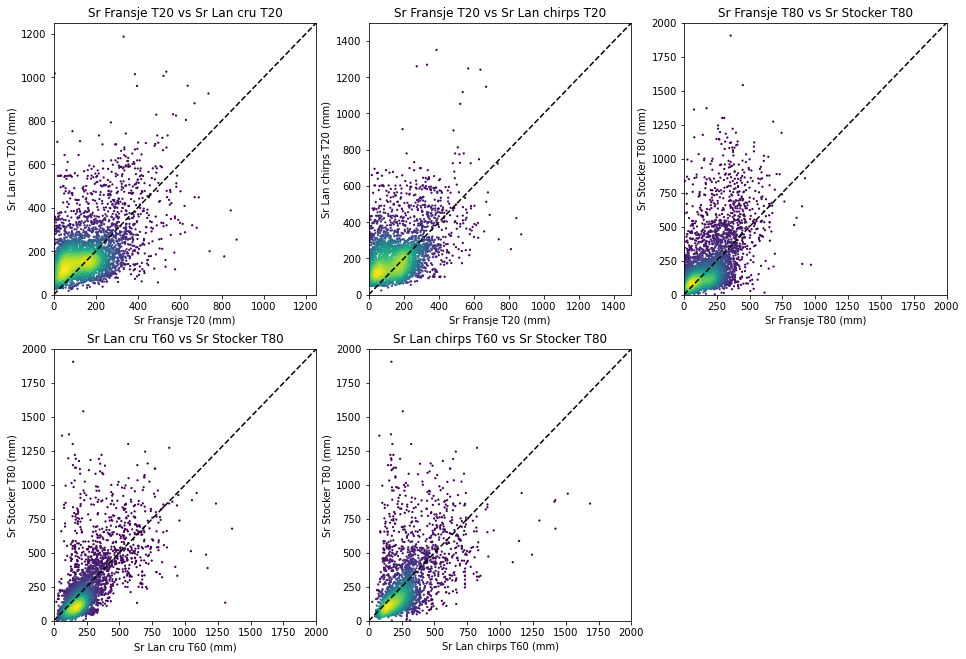

In [96]:
fig = plt.figure(figsize=(16,11))
ax = fig.add_subplot(231)
x = sr_df['20']
y = ls['lan_cru_20yrs']
y =  y.dropna()
x = x[y.index]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.scatter(x,y,c=z,s=1.5)
ax.plot([0,2000],[0,2000],'k--')
ax.set_xlim(0,1250)
ax.set_ylim(0,1250)
ax.set_xlabel('Sr Fransje T20 (mm)')
ax.set_ylabel('Sr Lan cru T20 (mm)')
ax.set_title('Sr Fransje T20 vs Sr Lan cru T20')

ax = fig.add_subplot(232)
x = sr_df['20']
y = ls['lan_chirps_20yrs']
y =  y.dropna()
x = x[y.index]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.scatter(x,y,c=z,s=1.5)
ax.plot([0,2000],[0,2000],'k--')
ax.set_xlim(0,1500)
ax.set_ylim(0,1500)
ax.set_xlabel('Sr Fransje T20 (mm)')
ax.set_ylabel('Sr Lan chirps T20 (mm)')
ax.set_title('Sr Fransje T20 vs Sr Lan chirps T20')

ax = fig.add_subplot(233)
x = sr_df['80']
y = ls['stocker_cwd80x_mm']
x = x.dropna()
y = y[x.index]
y =  y.dropna()
x = x[y.index]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.scatter(x,y,c=z,s=1.5)
ax.plot([0,2000],[0,2000],'k--')
ax.set_xlim(0,2000)
ax.set_ylim(0,2000)
ax.set_xlabel('Sr Fransje T80 (mm)')
ax.set_ylabel('Sr Stocker T80 (mm)')
ax.set_title('Sr Fransje T80 vs Sr Stocker T80')

ax = fig.add_subplot(234)
x = ls['lan_cru_60yrs']
y = ls['stocker_cwd80x_mm']
x = x.dropna()
y = y[x.index]
y =  y.dropna()
x = x[y.index]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.scatter(x,y,c=z,s=1.5)
ax.plot([0,2000],[0,2000],'k--')
ax.set_xlim(0,2000)
ax.set_ylim(0,2000)
ax.set_xlabel('Sr Lan cru T60 (mm)')
ax.set_ylabel('Sr Stocker T80 (mm)')
ax.set_title('Sr Lan cru T60 vs Sr Stocker T80')

ax = fig.add_subplot(235)
x = ls['lan_chirps_60yrs']
y = ls['stocker_cwd80x_mm']
x = x.dropna()
y = y[x.index]
y =  y.dropna()
x = x[y.index]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.scatter(x,y,c=z,s=1.5)
ax.plot([0,2000],[0,2000],'k--')
ax.set_xlim(0,2000)
ax.set_ylim(0,2000)
ax.set_xlabel('Sr Lan chirps T60 (mm)')
ax.set_ylabel('Sr Stocker T80 (mm)')
ax.set_title('Sr Lan chirps T60 vs Sr Stocker T80')
fig.savefig(f'{out_dir}/figures/sr_figures/sr_Fransje_vs_reference',bbox_inches='tight',dpi=300)


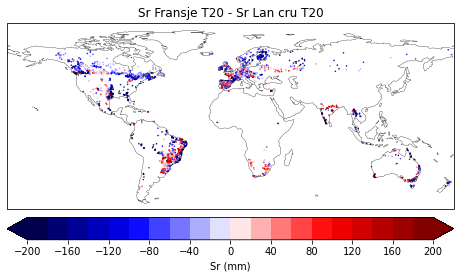

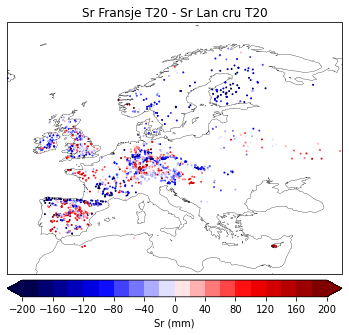

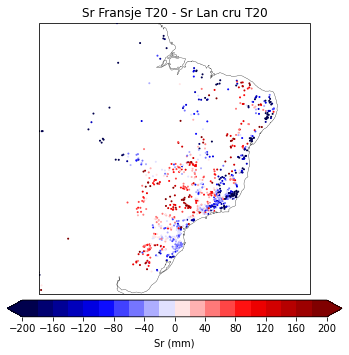

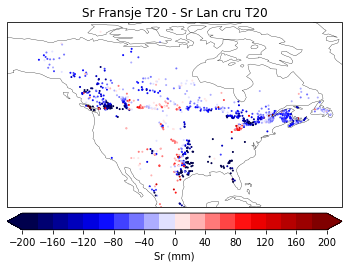

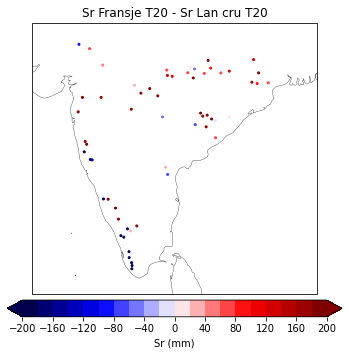

In [97]:
# Fransje vs Lan cru T20

cmap = plt.cm.seismic  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
cm2 = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(-200,200,21)
bounds2 = np.linspace(-200,200,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

dif = sr_df['20']-ls['lan_cru_20yrs']
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=0.3,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f'Sr Fransje T20 - Sr Lan cru T20',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_Fransje_vs_sr_lan_cru_T20.jpg',bbox_inches='tight',dpi=300)

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-15,45)
ax.set_ylim(30,75)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=1,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f'Sr Fransje T20 - Sr Lan cru T20',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_Fransje_vs_sr_lan_cru_T20_europe.jpg',bbox_inches='tight',dpi=300)

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-70,-30)
ax.set_ylim(-35,5)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=1,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f'Sr Fransje T20 - Sr Lan cru T20',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_Fransje_vs_sr_lan_cru_T20_brazil.jpg',bbox_inches='tight',dpi=300)

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-150,-50)
ax.set_ylim(20,75)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=1,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f'Sr Fransje T20 - Sr Lan cru T20',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_Fransje_vs_sr_lan_cru_T20_na.jpg',bbox_inches='tight',dpi=300)

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(70,90)
ax.set_ylim(7,26)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=4,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f'Sr Fransje T20 - Sr Lan cru T20',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_Fransje_vs_sr_lan_cru_T20_india.jpg',bbox_inches='tight',dpi=300)


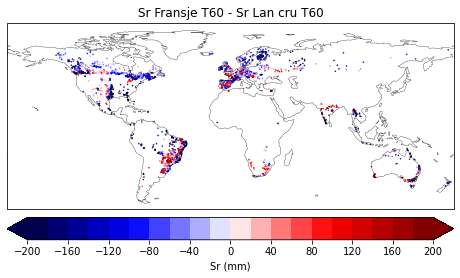

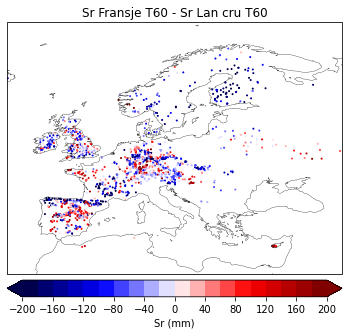

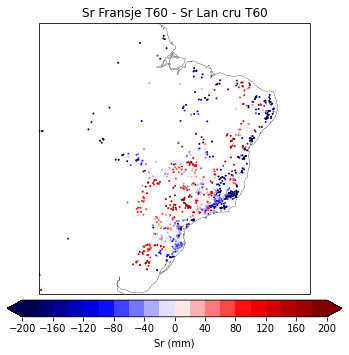

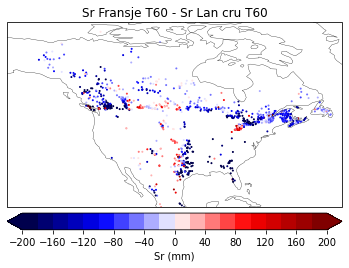

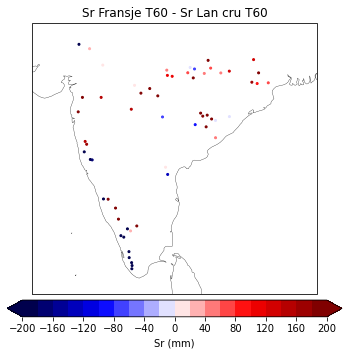

In [98]:
# Fransje vs Lan cru T60

cmap = plt.cm.seismic  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
cm2 = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(-200,200,21)
bounds2 = np.linspace(-200,200,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

dif = sr_df['60']-ls['lan_cru_60yrs']

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=0.3,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f'Sr Fransje T60 - Sr Lan cru T60',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_Fransje_vs_sr_lan_cru_T60.jpg',bbox_inches='tight',dpi=300)

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-15,45)
ax.set_ylim(30,75)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=1,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f'Sr Fransje T60 - Sr Lan cru T60',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_Fransje_vs_sr_lan_cru_T60_europe.jpg',bbox_inches='tight',dpi=300)

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-70,-30)
ax.set_ylim(-35,5)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=1,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f'Sr Fransje T60 - Sr Lan cru T60',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_Fransje_vs_sr_lan_cru_T60_brazil.jpg',bbox_inches='tight',dpi=300)

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-150,-50)
ax.set_ylim(20,75)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=1,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f'Sr Fransje T60 - Sr Lan cru T60',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_Fransje_vs_sr_lan_cru_T60_na.jpg',bbox_inches='tight',dpi=300)

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(70,90)
ax.set_ylim(7,26)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=4,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f'Sr Fransje T60 - Sr Lan cru T60',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_Fransje_vs_sr_lan_cru_T60_india.jpg',bbox_inches='tight',dpi=300)

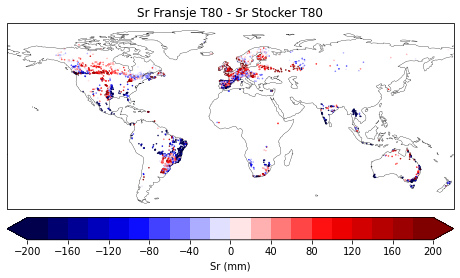

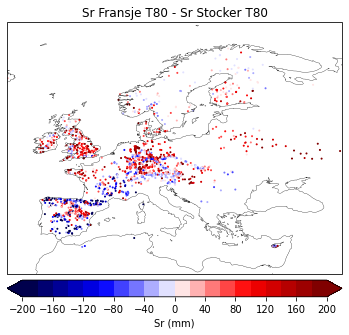

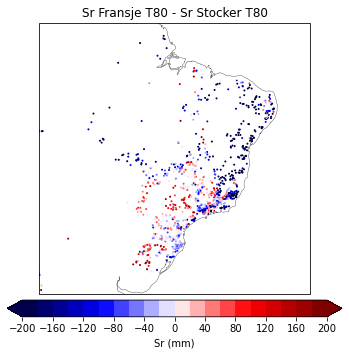

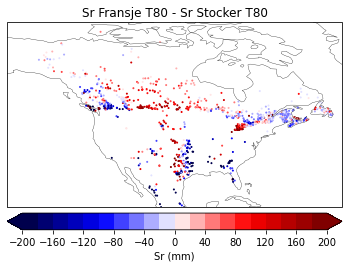

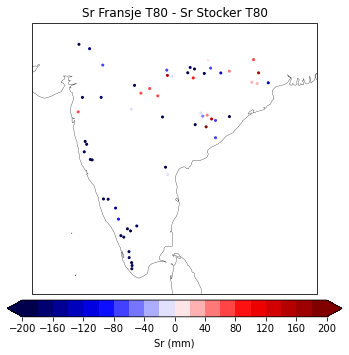

In [101]:
# Fransje vs Stocker T80

cmap = plt.cm.seismic  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
cm2 = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(-200,200,21)
bounds2 = np.linspace(-200,200,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

dif = sr_df['80']-ls['stocker_cwd80x_mm']

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=0.3,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f'Sr Fransje T80 - Sr Stocker T80',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_Fransje_vs_sr_stocker_T80.jpg',bbox_inches='tight',dpi=300)

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-15,45)
ax.set_ylim(30,75)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=1,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f'Sr Fransje T80 - Sr Stocker T80',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_Fransje_vs_sr_stocker_T80_europe.jpg',bbox_inches='tight',dpi=300)

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-70,-30)
ax.set_ylim(-35,5)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=1,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f'Sr Fransje T80 - Sr Stocker T80',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_Fransje_vs_sr_stocker_T80_brazil.jpg',bbox_inches='tight',dpi=300)

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-150,-50)
ax.set_ylim(20,75)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=1,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f'Sr Fransje T80 - Sr Stocker T80',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_Fransje_vs_sr_stocker_T80_na.jpg',bbox_inches='tight',dpi=300)

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(70,90)
ax.set_ylim(7,26)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=4,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f'Sr Fransje T80 - Sr Stocker T80',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_Fransje_vs_sr_stocker_T80_india.jpg',bbox_inches='tight',dpi=300)

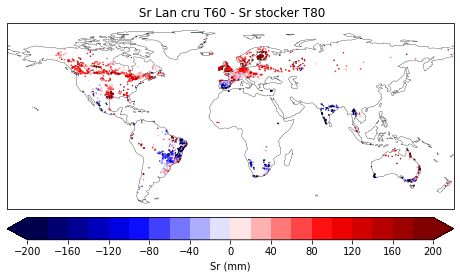

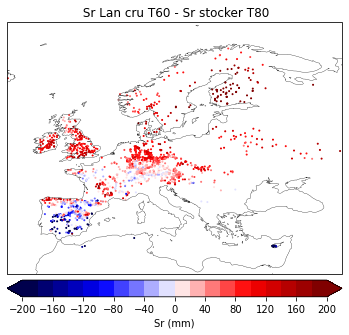

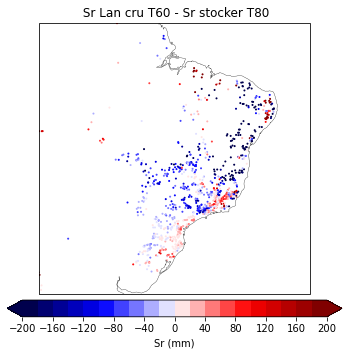

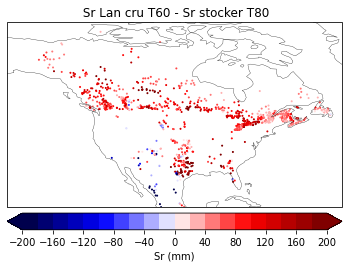

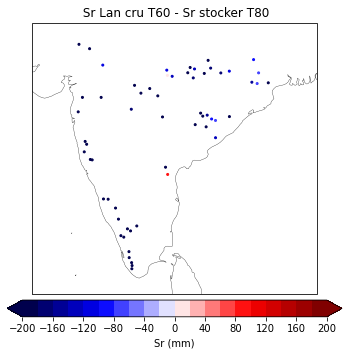

In [102]:
# Lan T60 vs Stocker T80

cmap = plt.cm.seismic  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
cm2 = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(-200,200,21)
bounds2 = np.linspace(-200,200,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

dif = ls['lan_cru_60yrs'] - ls['stocker_cwd80x_mm']

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=0.3,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f' Sr Lan cru T60 - Sr stocker T80',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_lan_cru_T60_vs_sr_stocker_T80.jpg',bbox_inches='tight',dpi=300)

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-15,45)
ax.set_ylim(30,75)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=1,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f' Sr Lan cru T60 - Sr stocker T80',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_lan_cru_T60_vs_sr_stocker_T80_europe.jpg',bbox_inches='tight',dpi=300)

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-70,-30)
ax.set_ylim(-35,5)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=1,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f' Sr Lan cru T60 - Sr stocker T80',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_lan_cru_T60_vs_sr_stocker_T80_brazil.jpg',bbox_inches='tight',dpi=300)

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-150,-50)
ax.set_ylim(20,75)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=1,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f' Sr Lan cru T60 - Sr stocker T80',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_lan_cru_T60_vs_sr_stocker_T80_na.jpg',bbox_inches='tight',dpi=300)

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(70,90)
ax.set_ylim(7,26)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=4,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f' Sr Lan cru T60 - Sr stocker T80',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_lan_cru_T60_vs_sr_stocker_T80_india.jpg',bbox_inches='tight',dpi=300)